# Sciplex Dose

In [1]:
ood_seed = 2

In [2]:
num_ood = 1

In [3]:
obs_key = "condition"

In [4]:
import warnings
import os
import sys
import gc
import warnings

In [5]:
import anndata as ad
import scanpy as sc
import copy
import torch
from pathlib import Path
import networkx as nx
from sklearn.neighbors import kneighbors_graph
import numpy as np
import scanpy as sc
import pandas as pd
import numpy as np
import sklearn
import scipy.stats
from sklearn.dummy import DummyClassifier

sys.path.append("/home/icb/kemal.inecik/work/codes/tardis")
import tardis
from tardis._utils.functions import label_transfer
tardis.config = tardis.config_server
print(f"CUDA used: {torch.cuda.is_available()}")

CUDA used: False


In [6]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
_rcparams_path = "/home/icb/kemal.inecik/work/codes/tardis/training/local/figures/rcparams.pickle"
with open(_rcparams_path, 'rb') as file:
    _rcparams = pickle.load(file)
plt.rcParams.update(_rcparams)

In [7]:
adata_file_path = os.path.join(tardis.config.io_directories["processed"], "cpa_GSM_new.h5ad")
assert os.path.isfile(adata_file_path), f"File not already exist: `{adata_file_path}`"
adata = ad.read_h5ad(adata_file_path)

adata.X = adata.layers["counts"].copy()
del adata.layers
adata.obs.loc[adata.obs["dose"] == "0.0", "dose_val"] = 0.0
d = {i: ind for ind, i in enumerate(sorted(adata.obs["dose"].astype(float).unique()))}
adata.obs["dose_training"] = [d[float(i)] for i in adata.obs["dose"]]
gc.collect()

12

In [8]:
df = adata.obs.groupby(["condition", "dose"]).size()
df2 = adata.obs.groupby(["condition"]).size()
availables = [(i, df[i]) for i in df.index if df[i] > 30 and df2[i[0]] > 200 and float(i[1])>4]
df

condition  dose 
BMS        0.0         0
           0.1       654
           0.5       542
           1.0       344
           5.0       193
           10.0      153
           50.0       34
           100.0      19
Dex        0.0         0
           0.1       327
           0.5       372
           1.0       717
           5.0       694
           10.0      704
           50.0      864
           100.0     790
Nutlin     0.0         0
           0.1       419
           0.5       359
           1.0       567
           5.0       486
           10.0      657
           50.0      265
           100.0       7
SAHA       0.0         0
           0.1       561
           0.5       519
           1.0       543
           5.0       417
           10.0      426
           50.0      604
           100.0     419
Vehicle    0.0      2155
           0.1         0
           0.5         0
           1.0         0
           5.0         0
           10.0        0
           50.0        0
        

In [9]:
availables, len(availables)

([(('BMS', '5.0'), 193),
  (('BMS', '10.0'), 153),
  (('BMS', '50.0'), 34),
  (('Dex', '5.0'), 694),
  (('Dex', '10.0'), 704),
  (('Dex', '50.0'), 864),
  (('Dex', '100.0'), 790),
  (('Nutlin', '5.0'), 486),
  (('Nutlin', '10.0'), 657),
  (('Nutlin', '50.0'), 265),
  (('SAHA', '5.0'), 417),
  (('SAHA', '10.0'), 426),
  (('SAHA', '50.0'), 604),
  (('SAHA', '100.0'), 419)],
 14)

In [10]:
def adata_ood_creator(adata, seed, size):
    df = adata.obs.groupby(["condition", "dose"]).size()
    df2 = adata.obs.groupby(["condition"]).size()
    # availables = [(i, df[i]) for i in df.index if df[i] > 200 and df2[i[0]] > 100 and float(i[1])>4]
    # rng = np.random.default_rng(seed=seed)
    # random_choices = rng.choice(np.arange(len(availables)), size=size, replace=False)
    # choices = [availables[i] for i in random_choices]
    choices = [availables[ood_seed]]
    for choice in choices:
        print(choice)
    choices_bool = np.vstack([(adata.obs["condition"] == choice[0][0]) & (adata.obs["dose"] == choice[0][1]) for choice in choices]).any(axis=0)
    print(f"\nRemoved datapoint: {choices_bool.sum()}")
    return adata[~choices_bool, :].copy(), choices_bool

adata, choices_bool = adata_ood_creator(adata, seed=ood_seed, size=num_ood)

(('BMS', '50.0'), 34)

Removed datapoint: 34


In [11]:
adata

AnnData object with n_obs × n_vars = 14777 × 4999
    obs: 'sample', 'size_factor', 'n.umi', 'hash_umis', 'pval', 'qval', 'top_to_second_best_ratio', 'top_oligo', 'drug', 'dose', 'vehicle', 'n_counts', 'log_counts', 'n_genes', 'mt_frac', 'product_dose', 'louvain', 'dose_val', 'cell_type', 'drug_dose_name', 'cov_drug_dose_name', 'condition', 'control', 'split', 'dose_training'
    var: 'id', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'dose_colors', 'drug_colors', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'product_dose_colors', 'rank_genes_groups_cov', 'umap', 'vehicle_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [12]:
dir_path = os.path.join(
    tardis.config.io_directories["models"],
    f"sciplex_cat_ood-seed-{ood_seed}_size-{num_ood}_obs-{obs_key}"
)

In [13]:
# vae = tardis.MyModel.load(dir_path, adata=adata)

In [14]:
model_level_metrics = [
    dict(
        metric_identifier = "metric_mi|dose_training",
        training_set = ["train", "validation"],
        every_n_epoch = 5,
        subsample = 1.0,
        progress_bar = True,
        metric_kwargs = dict(
            variation = "normalized",
            discretization_bins = 256,
            latent_subset=None,
            reduce=np.mean
        )
    ),
    dict(
        metric_identifier = "metric_mi|condition",
        training_set = ["train", "validation"],
        every_n_epoch = 5,
        subsample = 1.0,
        progress_bar = True,
        metric_kwargs = dict(
            variation = "normalized",
            discretization_bins = 256,
            latent_subset=None,
            reduce=np.mean
        )
    )
]

In [15]:
warmup_epoch_range = [6, 48]
dtc_w1 = 100
dtc_w2 = 10

counteractive_minibatch_settings = dict(
    method = "categorical_random",
    method_kwargs = dict(
        within_labels = False,
        within_batch = False,
        within_categorical_covs = None,
        seed = "forward",
    )
)

disentenglement_targets_configurations=[
    dict(
        obs_key = obs_key,
        n_reserved_latent = 8,
        counteractive_minibatch_settings = counteractive_minibatch_settings,
        auxillary_losses = [
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w1,
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "negative",
                transformation = "inverse", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w2, 
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "positive",
                transformation = "none",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w2 * 1,
                method = "mse_z", 
                latent_group = "unreserved_complete",
                counteractive_example = "negative",
                transformation = "none", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w1 * 1, 
                method = "mse_z", 
                latent_group = "unreserved_complete",
                counteractive_example = "positive",
                transformation = "inverse",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
        ]
    )
]

In [16]:
n_epochs_kl_warmup = 600

model_params = dict(
    n_hidden=512,
    n_layers=3, 
    n_latent=(24 + 8 * len(disentenglement_targets_configurations)),
    gene_likelihood = "nb",
    use_batch_norm = "none",
    use_layer_norm = "both",
    dropout_rate = 0.5,
    deeply_inject_disentengled_latents = True,
    include_auxillary_loss = True,
    beta_kl_weight = 0.5,
    encode_covariates=False
)

train_params = dict(
    max_epochs=600,
    train_size=0.8,
    batch_size=64,
    check_val_every_n_epoch=10,
    limit_train_batches=1.0, 
    limit_val_batches=1.0,
    learning_rate_monitor=True,
    # early stopping:
    early_stopping=False,
    early_stopping_patience=150,
    early_stopping_monitor="elbo_train",
    plan_kwargs = dict(
        n_epochs_kl_warmup=n_epochs_kl_warmup,
        lr=5e-5,
        weight_decay=1e-2,
        optimizer="AdamW",
        # lr-scheduler:
        reduce_lr_on_plateau=True,
        lr_patience=100,
        lr_scheduler_metric="elbo_train",
    )
)

dataset_params = dict(
    layer=None, 
    labels_key=None,
    batch_key=None,
    categorical_covariate_keys=None,
    disentenglement_targets_configurations=disentenglement_targets_configurations,
    model_level_metrics=model_level_metrics,
    model_level_metrics_helper_covariates=['condition', 'dose_training']
)

tardis.MyModel.setup_anndata(adata, **dataset_params)
dataset_params["adata_path"] = adata_file_path
dataset_params["adata"] = os.path.split(adata_file_path)[1]

tardis.MyModel.setup_wandb(
    wandb_configurations=tardis.config.wandb,
    hyperparams=dict(
        model_params=model_params,
        train_params=train_params,
        dataset_params=dataset_params,
    )
)

vae = tardis.MyModel(
    adata,
    **model_params
)
vae.train(**train_params)

W&B logger initialized with the following parameters: 
Entity: inecik-academic
Project: tardis_conference
ID: i0e1svn7
Name: rebel-trooper-470
Tags: tardis, conference, figures, final
Notes: Final runs for Tardis before conference.
URL: https://wandb.ai/inecik-academic/tardis_conference/runs/i0e1svn7
Directory: /lustre/groups/ml01/workspace/kemal.inecik/wandb/run-20240505_115317-i0e1svn7/files



/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_ ...


GPU available: False, used: False


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..


`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..


/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_ ...
/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Training:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch 1/600:   0%|          | 0/600 [00:00<?, ?it/s]

/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:237: UserWarning: Possible group definition indices are calculated for `condition` for `training` set. Number of elements in each group: 1516,3580,2206,2806,1714
  possible_indices = CachedPossibleGroupDefinitionIndices.get(


/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:237: UserWarning: Possible group definition indices are calculated for `condition` for `validation` set. Number of elements in each group: 389,888,554,683,441
  possible_indices = CachedPossibleGroupDefinitionIndices.get(


Epoch 1/600:   0%|          | 1/600 [00:10<1:46:14, 10.64s/it]

Epoch 1/600:   0%|          | 1/600 [00:10<1:46:14, 10.64s/it, v_num=n7_1, total_loss_train=2.65e+3, kl_local_train=30.3]

Epoch 2/600:   0%|          | 1/600 [00:10<1:46:14, 10.64s/it, v_num=n7_1, total_loss_train=2.65e+3, kl_local_train=30.3]

Epoch 2/600:   0%|          | 2/600 [00:20<1:40:27, 10.08s/it, v_num=n7_1, total_loss_train=2.65e+3, kl_local_train=30.3]

Epoch 2/600:   0%|          | 2/600 [00:20<1:40:27, 10.08s/it, v_num=n7_1, total_loss_train=2.24e+3, kl_local_train=55.5]

Epoch 3/600:   0%|          | 2/600 [00:20<1:40:27, 10.08s/it, v_num=n7_1, total_loss_train=2.24e+3, kl_local_train=55.5]

Epoch 3/600:   0%|          | 3/600 [00:29<1:37:46,  9.83s/it, v_num=n7_1, total_loss_train=2.24e+3, kl_local_train=55.5]

Epoch 3/600:   0%|          | 3/600 [00:29<1:37:46,  9.83s/it, v_num=n7_1, total_loss_train=2.21e+3, kl_local_train=61.3]

Epoch 4/600:   0%|          | 3/600 [00:29<1:37:46,  9.83s/it, v_num=n7_1, total_loss_train=2.21e+3, kl_local_train=61.3]

Epoch 4/600:   1%|          | 4/600 [00:39<1:37:03,  9.77s/it, v_num=n7_1, total_loss_train=2.21e+3, kl_local_train=61.3]

Epoch 4/600:   1%|          | 4/600 [00:39<1:37:03,  9.77s/it, v_num=n7_1, total_loss_train=2.21e+3, kl_local_train=62.9]

Epoch 5/600:   1%|          | 4/600 [00:39<1:37:03,  9.77s/it, v_num=n7_1, total_loss_train=2.21e+3, kl_local_train=62.9]

Epoch 5/600:   1%|          | 5/600 [00:49<1:38:20,  9.92s/it, v_num=n7_1, total_loss_train=2.21e+3, kl_local_train=62.9]

Epoch 5/600:   1%|          | 5/600 [00:49<1:38:20,  9.92s/it, v_num=n7_1, total_loss_train=2.2e+3, kl_local_train=61.9] 

Epoch 6/600:   1%|          | 5/600 [00:50<1:38:20,  9.92s/it, v_num=n7_1, total_loss_train=2.2e+3, kl_local_train=61.9]

Epoch 6/600:   1%|          | 6/600 [01:00<1:40:35, 10.16s/it, v_num=n7_1, total_loss_train=2.2e+3, kl_local_train=61.9]

Epoch 6/600:   1%|          | 6/600 [01:00<1:40:35, 10.16s/it, v_num=n7_1, total_loss_train=2.2e+3, kl_local_train=57.6, metric_mi|dose_training_train=0.0378, metric_mi|condition_train=0.0286]

Epoch 7/600:   1%|          | 6/600 [01:00<1:40:35, 10.16s/it, v_num=n7_1, total_loss_train=2.2e+3, kl_local_train=57.6, metric_mi|dose_training_train=0.0378, metric_mi|condition_train=0.0286]

Epoch 7/600:   1%|          | 7/600 [01:09<1:36:07,  9.73s/it, v_num=n7_1, total_loss_train=2.2e+3, kl_local_train=57.6, metric_mi|dose_training_train=0.0378, metric_mi|condition_train=0.0286]

Epoch 7/600:   1%|          | 7/600 [01:09<1:36:07,  9.73s/it, v_num=n7_1, total_loss_train=2.2e+3, kl_local_train=43.9, metric_mi|dose_training_train=0.0378, metric_mi|condition_train=0.0286]

Epoch 8/600:   1%|          | 7/600 [01:09<1:36:07,  9.73s/it, v_num=n7_1, total_loss_train=2.2e+3, kl_local_train=43.9, metric_mi|dose_training_train=0.0378, metric_mi|condition_train=0.0286]

Epoch 8/600:   1%|▏         | 8/600 [01:17<1:32:36,  9.39s/it, v_num=n7_1, total_loss_train=2.2e+3, kl_local_train=43.9, metric_mi|dose_training_train=0.0378, metric_mi|condition_train=0.0286]

Epoch 8/600:   1%|▏         | 8/600 [01:17<1:32:36,  9.39s/it, v_num=n7_1, total_loss_train=2.17e+3, kl_local_train=45.2, metric_mi|dose_training_train=0.0378, metric_mi|condition_train=0.0286]

Epoch 9/600:   1%|▏         | 8/600 [01:17<1:32:36,  9.39s/it, v_num=n7_1, total_loss_train=2.17e+3, kl_local_train=45.2, metric_mi|dose_training_train=0.0378, metric_mi|condition_train=0.0286]

Epoch 9/600:   2%|▏         | 9/600 [01:26<1:31:01,  9.24s/it, v_num=n7_1, total_loss_train=2.17e+3, kl_local_train=45.2, metric_mi|dose_training_train=0.0378, metric_mi|condition_train=0.0286]

Epoch 9/600:   2%|▏         | 9/600 [01:26<1:31:01,  9.24s/it, v_num=n7_1, total_loss_train=2.16e+3, kl_local_train=47.3, metric_mi|dose_training_train=0.0378, metric_mi|condition_train=0.0286]

Epoch 10/600:   2%|▏         | 9/600 [01:26<1:31:01,  9.24s/it, v_num=n7_1, total_loss_train=2.16e+3, kl_local_train=47.3, metric_mi|dose_training_train=0.0378, metric_mi|condition_train=0.0286]

Epoch 10/600:   2%|▏         | 10/600 [01:36<1:31:31,  9.31s/it, v_num=n7_1, total_loss_train=2.16e+3, kl_local_train=47.3, metric_mi|dose_training_train=0.0378, metric_mi|condition_train=0.0286]

Epoch 10/600:   2%|▏         | 10/600 [01:36<1:31:31,  9.31s/it, v_num=n7_1, total_loss_train=2.15e+3, kl_local_train=48.6, metric_mi|dose_training_train=0.0378, metric_mi|condition_train=0.0286]

Epoch 11/600:   2%|▏         | 10/600 [01:36<1:31:31,  9.31s/it, v_num=n7_1, total_loss_train=2.15e+3, kl_local_train=48.6, metric_mi|dose_training_train=0.0378, metric_mi|condition_train=0.0286]

Epoch 11/600:   2%|▏         | 11/600 [01:45<1:31:20,  9.30s/it, v_num=n7_1, total_loss_train=2.15e+3, kl_local_train=48.6, metric_mi|dose_training_train=0.0378, metric_mi|condition_train=0.0286]

Epoch 11/600:   2%|▏         | 11/600 [01:45<1:31:20,  9.30s/it, v_num=n7_1, total_loss_train=2.15e+3, kl_local_train=50.6, metric_mi|dose_training_train=0.0554, metric_mi|condition_train=0.148] 

Epoch 12/600:   2%|▏         | 11/600 [01:45<1:31:20,  9.30s/it, v_num=n7_1, total_loss_train=2.15e+3, kl_local_train=50.6, metric_mi|dose_training_train=0.0554, metric_mi|condition_train=0.148]

Epoch 12/600:   2%|▏         | 12/600 [01:54<1:29:31,  9.13s/it, v_num=n7_1, total_loss_train=2.15e+3, kl_local_train=50.6, metric_mi|dose_training_train=0.0554, metric_mi|condition_train=0.148]

Epoch 12/600:   2%|▏         | 12/600 [01:54<1:29:31,  9.13s/it, v_num=n7_1, total_loss_train=2.15e+3, kl_local_train=52.5, metric_mi|dose_training_train=0.0554, metric_mi|condition_train=0.148]

Epoch 13/600:   2%|▏         | 12/600 [01:54<1:29:31,  9.13s/it, v_num=n7_1, total_loss_train=2.15e+3, kl_local_train=52.5, metric_mi|dose_training_train=0.0554, metric_mi|condition_train=0.148]

Epoch 13/600:   2%|▏         | 13/600 [02:03<1:28:37,  9.06s/it, v_num=n7_1, total_loss_train=2.15e+3, kl_local_train=52.5, metric_mi|dose_training_train=0.0554, metric_mi|condition_train=0.148]

Epoch 13/600:   2%|▏         | 13/600 [02:03<1:28:37,  9.06s/it, v_num=n7_1, total_loss_train=2.15e+3, kl_local_train=53, metric_mi|dose_training_train=0.0554, metric_mi|condition_train=0.148]  

Epoch 14/600:   2%|▏         | 13/600 [02:03<1:28:37,  9.06s/it, v_num=n7_1, total_loss_train=2.15e+3, kl_local_train=53, metric_mi|dose_training_train=0.0554, metric_mi|condition_train=0.148]

Epoch 14/600:   2%|▏         | 14/600 [02:11<1:27:28,  8.96s/it, v_num=n7_1, total_loss_train=2.15e+3, kl_local_train=53, metric_mi|dose_training_train=0.0554, metric_mi|condition_train=0.148]

Epoch 14/600:   2%|▏         | 14/600 [02:11<1:27:28,  8.96s/it, v_num=n7_1, total_loss_train=2.15e+3, kl_local_train=54.1, metric_mi|dose_training_train=0.0554, metric_mi|condition_train=0.148]

Epoch 15/600:   2%|▏         | 14/600 [02:11<1:27:28,  8.96s/it, v_num=n7_1, total_loss_train=2.15e+3, kl_local_train=54.1, metric_mi|dose_training_train=0.0554, metric_mi|condition_train=0.148]

Epoch 15/600:   2%|▎         | 15/600 [02:20<1:27:37,  8.99s/it, v_num=n7_1, total_loss_train=2.15e+3, kl_local_train=54.1, metric_mi|dose_training_train=0.0554, metric_mi|condition_train=0.148]

Epoch 15/600:   2%|▎         | 15/600 [02:20<1:27:37,  8.99s/it, v_num=n7_1, total_loss_train=2.15e+3, kl_local_train=55.2, metric_mi|dose_training_train=0.0554, metric_mi|condition_train=0.148]

Epoch 16/600:   2%|▎         | 15/600 [02:21<1:27:37,  8.99s/it, v_num=n7_1, total_loss_train=2.15e+3, kl_local_train=55.2, metric_mi|dose_training_train=0.0554, metric_mi|condition_train=0.148]

Epoch 16/600:   3%|▎         | 16/600 [02:30<1:28:01,  9.04s/it, v_num=n7_1, total_loss_train=2.15e+3, kl_local_train=55.2, metric_mi|dose_training_train=0.0554, metric_mi|condition_train=0.148]

Epoch 16/600:   3%|▎         | 16/600 [02:30<1:28:01,  9.04s/it, v_num=n7_1, total_loss_train=2.15e+3, kl_local_train=56.3, metric_mi|dose_training_train=0.0638, metric_mi|condition_train=0.171]

Epoch 17/600:   3%|▎         | 16/600 [02:30<1:28:01,  9.04s/it, v_num=n7_1, total_loss_train=2.15e+3, kl_local_train=56.3, metric_mi|dose_training_train=0.0638, metric_mi|condition_train=0.171]

Epoch 17/600:   3%|▎         | 17/600 [02:38<1:26:51,  8.94s/it, v_num=n7_1, total_loss_train=2.15e+3, kl_local_train=56.3, metric_mi|dose_training_train=0.0638, metric_mi|condition_train=0.171]

Epoch 17/600:   3%|▎         | 17/600 [02:38<1:26:51,  8.94s/it, v_num=n7_1, total_loss_train=2.15e+3, kl_local_train=58.4, metric_mi|dose_training_train=0.0638, metric_mi|condition_train=0.171]

Epoch 18/600:   3%|▎         | 17/600 [02:38<1:26:51,  8.94s/it, v_num=n7_1, total_loss_train=2.15e+3, kl_local_train=58.4, metric_mi|dose_training_train=0.0638, metric_mi|condition_train=0.171]

Epoch 18/600:   3%|▎         | 18/600 [02:47<1:25:52,  8.85s/it, v_num=n7_1, total_loss_train=2.15e+3, kl_local_train=58.4, metric_mi|dose_training_train=0.0638, metric_mi|condition_train=0.171]

Epoch 18/600:   3%|▎         | 18/600 [02:47<1:25:52,  8.85s/it, v_num=n7_1, total_loss_train=2.15e+3, kl_local_train=59, metric_mi|dose_training_train=0.0638, metric_mi|condition_train=0.171]  

Epoch 19/600:   3%|▎         | 18/600 [02:47<1:25:52,  8.85s/it, v_num=n7_1, total_loss_train=2.15e+3, kl_local_train=59, metric_mi|dose_training_train=0.0638, metric_mi|condition_train=0.171]

Epoch 19/600:   3%|▎         | 19/600 [02:56<1:25:29,  8.83s/it, v_num=n7_1, total_loss_train=2.15e+3, kl_local_train=59, metric_mi|dose_training_train=0.0638, metric_mi|condition_train=0.171]

Epoch 19/600:   3%|▎         | 19/600 [02:56<1:25:29,  8.83s/it, v_num=n7_1, total_loss_train=2.15e+3, kl_local_train=60.7, metric_mi|dose_training_train=0.0638, metric_mi|condition_train=0.171]

Epoch 20/600:   3%|▎         | 19/600 [02:56<1:25:29,  8.83s/it, v_num=n7_1, total_loss_train=2.15e+3, kl_local_train=60.7, metric_mi|dose_training_train=0.0638, metric_mi|condition_train=0.171]

Epoch 20/600:   3%|▎         | 20/600 [03:05<1:25:36,  8.86s/it, v_num=n7_1, total_loss_train=2.15e+3, kl_local_train=60.7, metric_mi|dose_training_train=0.0638, metric_mi|condition_train=0.171]

Epoch 20/600:   3%|▎         | 20/600 [03:05<1:25:36,  8.86s/it, v_num=n7_1, total_loss_train=2.15e+3, kl_local_train=63.3, metric_mi|dose_training_train=0.0638, metric_mi|condition_train=0.171]

Epoch 21/600:   3%|▎         | 20/600 [03:05<1:25:36,  8.86s/it, v_num=n7_1, total_loss_train=2.15e+3, kl_local_train=63.3, metric_mi|dose_training_train=0.0638, metric_mi|condition_train=0.171]

Epoch 21/600:   4%|▎         | 21/600 [03:14<1:26:23,  8.95s/it, v_num=n7_1, total_loss_train=2.15e+3, kl_local_train=63.3, metric_mi|dose_training_train=0.0638, metric_mi|condition_train=0.171]

Epoch 21/600:   4%|▎         | 21/600 [03:14<1:26:23,  8.95s/it, v_num=n7_1, total_loss_train=2.15e+3, kl_local_train=66.2, metric_mi|dose_training_train=0.06, metric_mi|condition_train=0.152]  

Epoch 22/600:   4%|▎         | 21/600 [03:14<1:26:23,  8.95s/it, v_num=n7_1, total_loss_train=2.15e+3, kl_local_train=66.2, metric_mi|dose_training_train=0.06, metric_mi|condition_train=0.152]

Epoch 22/600:   4%|▎         | 22/600 [03:23<1:25:29,  8.87s/it, v_num=n7_1, total_loss_train=2.15e+3, kl_local_train=66.2, metric_mi|dose_training_train=0.06, metric_mi|condition_train=0.152]

Epoch 22/600:   4%|▎         | 22/600 [03:23<1:25:29,  8.87s/it, v_num=n7_1, total_loss_train=2.15e+3, kl_local_train=69.9, metric_mi|dose_training_train=0.06, metric_mi|condition_train=0.152]

Epoch 23/600:   4%|▎         | 22/600 [03:23<1:25:29,  8.87s/it, v_num=n7_1, total_loss_train=2.15e+3, kl_local_train=69.9, metric_mi|dose_training_train=0.06, metric_mi|condition_train=0.152]

Epoch 23/600:   4%|▍         | 23/600 [03:31<1:24:41,  8.81s/it, v_num=n7_1, total_loss_train=2.15e+3, kl_local_train=69.9, metric_mi|dose_training_train=0.06, metric_mi|condition_train=0.152]

Epoch 23/600:   4%|▍         | 23/600 [03:31<1:24:41,  8.81s/it, v_num=n7_1, total_loss_train=2.16e+3, kl_local_train=73.7, metric_mi|dose_training_train=0.06, metric_mi|condition_train=0.152]

Epoch 24/600:   4%|▍         | 23/600 [03:31<1:24:41,  8.81s/it, v_num=n7_1, total_loss_train=2.16e+3, kl_local_train=73.7, metric_mi|dose_training_train=0.06, metric_mi|condition_train=0.152]

Epoch 24/600:   4%|▍         | 24/600 [03:40<1:23:58,  8.75s/it, v_num=n7_1, total_loss_train=2.16e+3, kl_local_train=73.7, metric_mi|dose_training_train=0.06, metric_mi|condition_train=0.152]

Epoch 24/600:   4%|▍         | 24/600 [03:40<1:23:58,  8.75s/it, v_num=n7_1, total_loss_train=2.15e+3, kl_local_train=74.3, metric_mi|dose_training_train=0.06, metric_mi|condition_train=0.152]

Epoch 25/600:   4%|▍         | 24/600 [03:40<1:23:58,  8.75s/it, v_num=n7_1, total_loss_train=2.15e+3, kl_local_train=74.3, metric_mi|dose_training_train=0.06, metric_mi|condition_train=0.152]

Epoch 25/600:   4%|▍         | 25/600 [03:49<1:24:44,  8.84s/it, v_num=n7_1, total_loss_train=2.15e+3, kl_local_train=74.3, metric_mi|dose_training_train=0.06, metric_mi|condition_train=0.152]

Epoch 25/600:   4%|▍         | 25/600 [03:49<1:24:44,  8.84s/it, v_num=n7_1, total_loss_train=2.15e+3, kl_local_train=75, metric_mi|dose_training_train=0.06, metric_mi|condition_train=0.152]  

Epoch 26/600:   4%|▍         | 25/600 [03:49<1:24:44,  8.84s/it, v_num=n7_1, total_loss_train=2.15e+3, kl_local_train=75, metric_mi|dose_training_train=0.06, metric_mi|condition_train=0.152]

Epoch 26/600:   4%|▍         | 26/600 [03:58<1:25:28,  8.93s/it, v_num=n7_1, total_loss_train=2.15e+3, kl_local_train=75, metric_mi|dose_training_train=0.06, metric_mi|condition_train=0.152]

Epoch 26/600:   4%|▍         | 26/600 [03:58<1:25:28,  8.93s/it, v_num=n7_1, total_loss_train=2.15e+3, kl_local_train=78.2, metric_mi|dose_training_train=0.059, metric_mi|condition_train=0.141]

Epoch 27/600:   4%|▍         | 26/600 [03:58<1:25:28,  8.93s/it, v_num=n7_1, total_loss_train=2.15e+3, kl_local_train=78.2, metric_mi|dose_training_train=0.059, metric_mi|condition_train=0.141]

Epoch 27/600:   4%|▍         | 27/600 [04:07<1:24:27,  8.84s/it, v_num=n7_1, total_loss_train=2.15e+3, kl_local_train=78.2, metric_mi|dose_training_train=0.059, metric_mi|condition_train=0.141]

Epoch 27/600:   4%|▍         | 27/600 [04:07<1:24:27,  8.84s/it, v_num=n7_1, total_loss_train=2.15e+3, kl_local_train=80.7, metric_mi|dose_training_train=0.059, metric_mi|condition_train=0.141]

Epoch 28/600:   4%|▍         | 27/600 [04:07<1:24:27,  8.84s/it, v_num=n7_1, total_loss_train=2.15e+3, kl_local_train=80.7, metric_mi|dose_training_train=0.059, metric_mi|condition_train=0.141]

Epoch 28/600:   5%|▍         | 28/600 [04:15<1:23:51,  8.80s/it, v_num=n7_1, total_loss_train=2.15e+3, kl_local_train=80.7, metric_mi|dose_training_train=0.059, metric_mi|condition_train=0.141]

Epoch 28/600:   5%|▍         | 28/600 [04:15<1:23:51,  8.80s/it, v_num=n7_1, total_loss_train=2.16e+3, kl_local_train=82.7, metric_mi|dose_training_train=0.059, metric_mi|condition_train=0.141]

Epoch 29/600:   5%|▍         | 28/600 [04:15<1:23:51,  8.80s/it, v_num=n7_1, total_loss_train=2.16e+3, kl_local_train=82.7, metric_mi|dose_training_train=0.059, metric_mi|condition_train=0.141]

Epoch 29/600:   5%|▍         | 29/600 [04:24<1:23:15,  8.75s/it, v_num=n7_1, total_loss_train=2.16e+3, kl_local_train=82.7, metric_mi|dose_training_train=0.059, metric_mi|condition_train=0.141]

Epoch 29/600:   5%|▍         | 29/600 [04:24<1:23:15,  8.75s/it, v_num=n7_1, total_loss_train=2.16e+3, kl_local_train=85.1, metric_mi|dose_training_train=0.059, metric_mi|condition_train=0.141]

Epoch 30/600:   5%|▍         | 29/600 [04:24<1:23:15,  8.75s/it, v_num=n7_1, total_loss_train=2.16e+3, kl_local_train=85.1, metric_mi|dose_training_train=0.059, metric_mi|condition_train=0.141]

Epoch 30/600:   5%|▌         | 30/600 [04:33<1:24:57,  8.94s/it, v_num=n7_1, total_loss_train=2.16e+3, kl_local_train=85.1, metric_mi|dose_training_train=0.059, metric_mi|condition_train=0.141]

Epoch 30/600:   5%|▌         | 30/600 [04:33<1:24:57,  8.94s/it, v_num=n7_1, total_loss_train=2.16e+3, kl_local_train=85.9, metric_mi|dose_training_train=0.059, metric_mi|condition_train=0.141]

Epoch 31/600:   5%|▌         | 30/600 [04:34<1:24:57,  8.94s/it, v_num=n7_1, total_loss_train=2.16e+3, kl_local_train=85.9, metric_mi|dose_training_train=0.059, metric_mi|condition_train=0.141]

Epoch 31/600:   5%|▌         | 31/600 [04:43<1:25:38,  9.03s/it, v_num=n7_1, total_loss_train=2.16e+3, kl_local_train=85.9, metric_mi|dose_training_train=0.059, metric_mi|condition_train=0.141]

Epoch 31/600:   5%|▌         | 31/600 [04:43<1:25:38,  9.03s/it, v_num=n7_1, total_loss_train=2.16e+3, kl_local_train=89.1, metric_mi|dose_training_train=0.0613, metric_mi|condition_train=0.144]

Epoch 32/600:   5%|▌         | 31/600 [04:43<1:25:38,  9.03s/it, v_num=n7_1, total_loss_train=2.16e+3, kl_local_train=89.1, metric_mi|dose_training_train=0.0613, metric_mi|condition_train=0.144]

Epoch 32/600:   5%|▌         | 32/600 [04:51<1:24:44,  8.95s/it, v_num=n7_1, total_loss_train=2.16e+3, kl_local_train=89.1, metric_mi|dose_training_train=0.0613, metric_mi|condition_train=0.144]

Epoch 32/600:   5%|▌         | 32/600 [04:51<1:24:44,  8.95s/it, v_num=n7_1, total_loss_train=2.16e+3, kl_local_train=85.2, metric_mi|dose_training_train=0.0613, metric_mi|condition_train=0.144]

Epoch 33/600:   5%|▌         | 32/600 [04:51<1:24:44,  8.95s/it, v_num=n7_1, total_loss_train=2.16e+3, kl_local_train=85.2, metric_mi|dose_training_train=0.0613, metric_mi|condition_train=0.144]

Epoch 33/600:   6%|▌         | 33/600 [05:00<1:24:05,  8.90s/it, v_num=n7_1, total_loss_train=2.16e+3, kl_local_train=85.2, metric_mi|dose_training_train=0.0613, metric_mi|condition_train=0.144]

Epoch 33/600:   6%|▌         | 33/600 [05:00<1:24:05,  8.90s/it, v_num=n7_1, total_loss_train=2.16e+3, kl_local_train=86.7, metric_mi|dose_training_train=0.0613, metric_mi|condition_train=0.144]

Epoch 34/600:   6%|▌         | 33/600 [05:00<1:24:05,  8.90s/it, v_num=n7_1, total_loss_train=2.16e+3, kl_local_train=86.7, metric_mi|dose_training_train=0.0613, metric_mi|condition_train=0.144]

Epoch 34/600:   6%|▌         | 34/600 [05:09<1:23:21,  8.84s/it, v_num=n7_1, total_loss_train=2.16e+3, kl_local_train=86.7, metric_mi|dose_training_train=0.0613, metric_mi|condition_train=0.144]

Epoch 34/600:   6%|▌         | 34/600 [05:09<1:23:21,  8.84s/it, v_num=n7_1, total_loss_train=2.16e+3, kl_local_train=85.4, metric_mi|dose_training_train=0.0613, metric_mi|condition_train=0.144]

Epoch 35/600:   6%|▌         | 34/600 [05:09<1:23:21,  8.84s/it, v_num=n7_1, total_loss_train=2.16e+3, kl_local_train=85.4, metric_mi|dose_training_train=0.0613, metric_mi|condition_train=0.144]

Epoch 35/600:   6%|▌         | 35/600 [05:18<1:23:43,  8.89s/it, v_num=n7_1, total_loss_train=2.16e+3, kl_local_train=85.4, metric_mi|dose_training_train=0.0613, metric_mi|condition_train=0.144]

Epoch 35/600:   6%|▌         | 35/600 [05:18<1:23:43,  8.89s/it, v_num=n7_1, total_loss_train=2.16e+3, kl_local_train=84.6, metric_mi|dose_training_train=0.0613, metric_mi|condition_train=0.144]

Epoch 36/600:   6%|▌         | 35/600 [05:18<1:23:43,  8.89s/it, v_num=n7_1, total_loss_train=2.16e+3, kl_local_train=84.6, metric_mi|dose_training_train=0.0613, metric_mi|condition_train=0.144]

Epoch 36/600:   6%|▌         | 36/600 [05:27<1:24:07,  8.95s/it, v_num=n7_1, total_loss_train=2.16e+3, kl_local_train=84.6, metric_mi|dose_training_train=0.0613, metric_mi|condition_train=0.144]

Epoch 36/600:   6%|▌         | 36/600 [05:27<1:24:07,  8.95s/it, v_num=n7_1, total_loss_train=2.16e+3, kl_local_train=84.9, metric_mi|dose_training_train=0.0626, metric_mi|condition_train=0.147]

Epoch 37/600:   6%|▌         | 36/600 [05:27<1:24:07,  8.95s/it, v_num=n7_1, total_loss_train=2.16e+3, kl_local_train=84.9, metric_mi|dose_training_train=0.0626, metric_mi|condition_train=0.147]

Epoch 37/600:   6%|▌         | 37/600 [05:35<1:22:38,  8.81s/it, v_num=n7_1, total_loss_train=2.16e+3, kl_local_train=84.9, metric_mi|dose_training_train=0.0626, metric_mi|condition_train=0.147]

Epoch 37/600:   6%|▌         | 37/600 [05:35<1:22:38,  8.81s/it, v_num=n7_1, total_loss_train=2.16e+3, kl_local_train=83.6, metric_mi|dose_training_train=0.0626, metric_mi|condition_train=0.147]

Epoch 38/600:   6%|▌         | 37/600 [05:35<1:22:38,  8.81s/it, v_num=n7_1, total_loss_train=2.16e+3, kl_local_train=83.6, metric_mi|dose_training_train=0.0626, metric_mi|condition_train=0.147]

Epoch 38/600:   6%|▋         | 38/600 [05:44<1:21:47,  8.73s/it, v_num=n7_1, total_loss_train=2.16e+3, kl_local_train=83.6, metric_mi|dose_training_train=0.0626, metric_mi|condition_train=0.147]

Epoch 38/600:   6%|▋         | 38/600 [05:44<1:21:47,  8.73s/it, v_num=n7_1, total_loss_train=2.16e+3, kl_local_train=83.9, metric_mi|dose_training_train=0.0626, metric_mi|condition_train=0.147]

Epoch 39/600:   6%|▋         | 38/600 [05:44<1:21:47,  8.73s/it, v_num=n7_1, total_loss_train=2.16e+3, kl_local_train=83.9, metric_mi|dose_training_train=0.0626, metric_mi|condition_train=0.147]

Epoch 39/600:   6%|▋         | 39/600 [05:52<1:21:04,  8.67s/it, v_num=n7_1, total_loss_train=2.16e+3, kl_local_train=83.9, metric_mi|dose_training_train=0.0626, metric_mi|condition_train=0.147]

Epoch 39/600:   6%|▋         | 39/600 [05:52<1:21:04,  8.67s/it, v_num=n7_1, total_loss_train=2.16e+3, kl_local_train=82.5, metric_mi|dose_training_train=0.0626, metric_mi|condition_train=0.147]

Epoch 40/600:   6%|▋         | 39/600 [05:52<1:21:04,  8.67s/it, v_num=n7_1, total_loss_train=2.16e+3, kl_local_train=82.5, metric_mi|dose_training_train=0.0626, metric_mi|condition_train=0.147]

Epoch 40/600:   7%|▋         | 40/600 [06:02<1:23:42,  8.97s/it, v_num=n7_1, total_loss_train=2.16e+3, kl_local_train=82.5, metric_mi|dose_training_train=0.0626, metric_mi|condition_train=0.147]

Epoch 40/600:   7%|▋         | 40/600 [06:02<1:23:42,  8.97s/it, v_num=n7_1, total_loss_train=2.16e+3, kl_local_train=83.4, metric_mi|dose_training_train=0.0626, metric_mi|condition_train=0.147]

Epoch 41/600:   7%|▋         | 40/600 [06:03<1:23:42,  8.97s/it, v_num=n7_1, total_loss_train=2.16e+3, kl_local_train=83.4, metric_mi|dose_training_train=0.0626, metric_mi|condition_train=0.147]

Epoch 41/600:   7%|▋         | 41/600 [06:11<1:23:38,  8.98s/it, v_num=n7_1, total_loss_train=2.16e+3, kl_local_train=83.4, metric_mi|dose_training_train=0.0626, metric_mi|condition_train=0.147]

Epoch 41/600:   7%|▋         | 41/600 [06:11<1:23:38,  8.98s/it, v_num=n7_1, total_loss_train=2.16e+3, kl_local_train=83.8, metric_mi|dose_training_train=0.0637, metric_mi|condition_train=0.146]

Epoch 42/600:   7%|▋         | 41/600 [06:11<1:23:38,  8.98s/it, v_num=n7_1, total_loss_train=2.16e+3, kl_local_train=83.8, metric_mi|dose_training_train=0.0637, metric_mi|condition_train=0.146]

Epoch 42/600:   7%|▋         | 42/600 [06:20<1:22:25,  8.86s/it, v_num=n7_1, total_loss_train=2.16e+3, kl_local_train=83.8, metric_mi|dose_training_train=0.0637, metric_mi|condition_train=0.146]

Epoch 42/600:   7%|▋         | 42/600 [06:20<1:22:25,  8.86s/it, v_num=n7_1, total_loss_train=2.16e+3, kl_local_train=82.7, metric_mi|dose_training_train=0.0637, metric_mi|condition_train=0.146]

Epoch 43/600:   7%|▋         | 42/600 [06:20<1:22:25,  8.86s/it, v_num=n7_1, total_loss_train=2.16e+3, kl_local_train=82.7, metric_mi|dose_training_train=0.0637, metric_mi|condition_train=0.146]

Epoch 43/600:   7%|▋         | 43/600 [06:28<1:21:02,  8.73s/it, v_num=n7_1, total_loss_train=2.16e+3, kl_local_train=82.7, metric_mi|dose_training_train=0.0637, metric_mi|condition_train=0.146]

Epoch 43/600:   7%|▋         | 43/600 [06:28<1:21:02,  8.73s/it, v_num=n7_1, total_loss_train=2.16e+3, kl_local_train=85.4, metric_mi|dose_training_train=0.0637, metric_mi|condition_train=0.146]

Epoch 44/600:   7%|▋         | 43/600 [06:28<1:21:02,  8.73s/it, v_num=n7_1, total_loss_train=2.16e+3, kl_local_train=85.4, metric_mi|dose_training_train=0.0637, metric_mi|condition_train=0.146]

Epoch 44/600:   7%|▋         | 44/600 [06:37<1:20:03,  8.64s/it, v_num=n7_1, total_loss_train=2.16e+3, kl_local_train=85.4, metric_mi|dose_training_train=0.0637, metric_mi|condition_train=0.146]

Epoch 44/600:   7%|▋         | 44/600 [06:37<1:20:03,  8.64s/it, v_num=n7_1, total_loss_train=2.16e+3, kl_local_train=86.3, metric_mi|dose_training_train=0.0637, metric_mi|condition_train=0.146]

Epoch 45/600:   7%|▋         | 44/600 [06:37<1:20:03,  8.64s/it, v_num=n7_1, total_loss_train=2.16e+3, kl_local_train=86.3, metric_mi|dose_training_train=0.0637, metric_mi|condition_train=0.146]

Epoch 45/600:   8%|▊         | 45/600 [06:46<1:22:23,  8.91s/it, v_num=n7_1, total_loss_train=2.16e+3, kl_local_train=86.3, metric_mi|dose_training_train=0.0637, metric_mi|condition_train=0.146]

Epoch 45/600:   8%|▊         | 45/600 [06:46<1:22:23,  8.91s/it, v_num=n7_1, total_loss_train=2.16e+3, kl_local_train=85.3, metric_mi|dose_training_train=0.0637, metric_mi|condition_train=0.146]

Epoch 46/600:   8%|▊         | 45/600 [06:47<1:22:23,  8.91s/it, v_num=n7_1, total_loss_train=2.16e+3, kl_local_train=85.3, metric_mi|dose_training_train=0.0637, metric_mi|condition_train=0.146]

Epoch 46/600:   8%|▊         | 46/600 [06:55<1:22:18,  8.91s/it, v_num=n7_1, total_loss_train=2.16e+3, kl_local_train=85.3, metric_mi|dose_training_train=0.0637, metric_mi|condition_train=0.146]

Epoch 46/600:   8%|▊         | 46/600 [06:55<1:22:18,  8.91s/it, v_num=n7_1, total_loss_train=2.16e+3, kl_local_train=84.9, metric_mi|dose_training_train=0.0646, metric_mi|condition_train=0.157]

Epoch 47/600:   8%|▊         | 46/600 [06:55<1:22:18,  8.91s/it, v_num=n7_1, total_loss_train=2.16e+3, kl_local_train=84.9, metric_mi|dose_training_train=0.0646, metric_mi|condition_train=0.157]

Epoch 47/600:   8%|▊         | 47/600 [07:04<1:20:58,  8.79s/it, v_num=n7_1, total_loss_train=2.16e+3, kl_local_train=84.9, metric_mi|dose_training_train=0.0646, metric_mi|condition_train=0.157]

Epoch 47/600:   8%|▊         | 47/600 [07:04<1:20:58,  8.79s/it, v_num=n7_1, total_loss_train=2.17e+3, kl_local_train=84.5, metric_mi|dose_training_train=0.0646, metric_mi|condition_train=0.157]

Epoch 48/600:   8%|▊         | 47/600 [07:04<1:20:58,  8.79s/it, v_num=n7_1, total_loss_train=2.17e+3, kl_local_train=84.5, metric_mi|dose_training_train=0.0646, metric_mi|condition_train=0.157]

Epoch 48/600:   8%|▊         | 48/600 [07:12<1:20:52,  8.79s/it, v_num=n7_1, total_loss_train=2.17e+3, kl_local_train=84.5, metric_mi|dose_training_train=0.0646, metric_mi|condition_train=0.157]

Epoch 48/600:   8%|▊         | 48/600 [07:12<1:20:52,  8.79s/it, v_num=n7_1, total_loss_train=2.17e+3, kl_local_train=86.7, metric_mi|dose_training_train=0.0646, metric_mi|condition_train=0.157]

Epoch 49/600:   8%|▊         | 48/600 [07:12<1:20:52,  8.79s/it, v_num=n7_1, total_loss_train=2.17e+3, kl_local_train=86.7, metric_mi|dose_training_train=0.0646, metric_mi|condition_train=0.157]

Epoch 49/600:   8%|▊         | 49/600 [07:21<1:19:46,  8.69s/it, v_num=n7_1, total_loss_train=2.17e+3, kl_local_train=86.7, metric_mi|dose_training_train=0.0646, metric_mi|condition_train=0.157]

Epoch 49/600:   8%|▊         | 49/600 [07:21<1:19:46,  8.69s/it, v_num=n7_1, total_loss_train=2.17e+3, kl_local_train=89.9, metric_mi|dose_training_train=0.0646, metric_mi|condition_train=0.157]

Epoch 50/600:   8%|▊         | 49/600 [07:21<1:19:46,  8.69s/it, v_num=n7_1, total_loss_train=2.17e+3, kl_local_train=89.9, metric_mi|dose_training_train=0.0646, metric_mi|condition_train=0.157]

Epoch 50/600:   8%|▊         | 50/600 [07:30<1:20:55,  8.83s/it, v_num=n7_1, total_loss_train=2.17e+3, kl_local_train=89.9, metric_mi|dose_training_train=0.0646, metric_mi|condition_train=0.157]

Epoch 50/600:   8%|▊         | 50/600 [07:30<1:20:55,  8.83s/it, v_num=n7_1, total_loss_train=2.17e+3, kl_local_train=87.7, metric_mi|dose_training_train=0.0646, metric_mi|condition_train=0.157]

Epoch 51/600:   8%|▊         | 50/600 [07:30<1:20:55,  8.83s/it, v_num=n7_1, total_loss_train=2.17e+3, kl_local_train=87.7, metric_mi|dose_training_train=0.0646, metric_mi|condition_train=0.157]

Epoch 51/600:   8%|▊         | 51/600 [07:39<1:21:13,  8.88s/it, v_num=n7_1, total_loss_train=2.17e+3, kl_local_train=87.7, metric_mi|dose_training_train=0.0646, metric_mi|condition_train=0.157]

Epoch 51/600:   8%|▊         | 51/600 [07:39<1:21:13,  8.88s/it, v_num=n7_1, total_loss_train=2.17e+3, kl_local_train=85.8, metric_mi|dose_training_train=0.0657, metric_mi|condition_train=0.17] 

Epoch 52/600:   8%|▊         | 51/600 [07:39<1:21:13,  8.88s/it, v_num=n7_1, total_loss_train=2.17e+3, kl_local_train=85.8, metric_mi|dose_training_train=0.0657, metric_mi|condition_train=0.17]

Epoch 52/600:   9%|▊         | 52/600 [07:48<1:20:44,  8.84s/it, v_num=n7_1, total_loss_train=2.17e+3, kl_local_train=85.8, metric_mi|dose_training_train=0.0657, metric_mi|condition_train=0.17]

Epoch 52/600:   9%|▊         | 52/600 [07:48<1:20:44,  8.84s/it, v_num=n7_1, total_loss_train=2.17e+3, kl_local_train=87.6, metric_mi|dose_training_train=0.0657, metric_mi|condition_train=0.17]

Epoch 53/600:   9%|▊         | 52/600 [07:48<1:20:44,  8.84s/it, v_num=n7_1, total_loss_train=2.17e+3, kl_local_train=87.6, metric_mi|dose_training_train=0.0657, metric_mi|condition_train=0.17]

Epoch 53/600:   9%|▉         | 53/600 [07:56<1:19:39,  8.74s/it, v_num=n7_1, total_loss_train=2.17e+3, kl_local_train=87.6, metric_mi|dose_training_train=0.0657, metric_mi|condition_train=0.17]

Epoch 53/600:   9%|▉         | 53/600 [07:56<1:19:39,  8.74s/it, v_num=n7_1, total_loss_train=2.16e+3, kl_local_train=86.3, metric_mi|dose_training_train=0.0657, metric_mi|condition_train=0.17]

Epoch 54/600:   9%|▉         | 53/600 [07:56<1:19:39,  8.74s/it, v_num=n7_1, total_loss_train=2.16e+3, kl_local_train=86.3, metric_mi|dose_training_train=0.0657, metric_mi|condition_train=0.17]

Epoch 54/600:   9%|▉         | 54/600 [08:05<1:19:12,  8.70s/it, v_num=n7_1, total_loss_train=2.16e+3, kl_local_train=86.3, metric_mi|dose_training_train=0.0657, metric_mi|condition_train=0.17]

Epoch 54/600:   9%|▉         | 54/600 [08:05<1:19:12,  8.70s/it, v_num=n7_1, total_loss_train=2.16e+3, kl_local_train=84.9, metric_mi|dose_training_train=0.0657, metric_mi|condition_train=0.17]

Epoch 55/600:   9%|▉         | 54/600 [08:05<1:19:12,  8.70s/it, v_num=n7_1, total_loss_train=2.16e+3, kl_local_train=84.9, metric_mi|dose_training_train=0.0657, metric_mi|condition_train=0.17]

Epoch 55/600:   9%|▉         | 55/600 [08:14<1:21:21,  8.96s/it, v_num=n7_1, total_loss_train=2.16e+3, kl_local_train=84.9, metric_mi|dose_training_train=0.0657, metric_mi|condition_train=0.17]

Epoch 55/600:   9%|▉         | 55/600 [08:14<1:21:21,  8.96s/it, v_num=n7_1, total_loss_train=2.16e+3, kl_local_train=82.8, metric_mi|dose_training_train=0.0657, metric_mi|condition_train=0.17]

Epoch 56/600:   9%|▉         | 55/600 [08:15<1:21:21,  8.96s/it, v_num=n7_1, total_loss_train=2.16e+3, kl_local_train=82.8, metric_mi|dose_training_train=0.0657, metric_mi|condition_train=0.17]

Epoch 56/600:   9%|▉         | 56/600 [08:23<1:21:05,  8.94s/it, v_num=n7_1, total_loss_train=2.16e+3, kl_local_train=82.8, metric_mi|dose_training_train=0.0657, metric_mi|condition_train=0.17]

Epoch 56/600:   9%|▉         | 56/600 [08:23<1:21:05,  8.94s/it, v_num=n7_1, total_loss_train=2.16e+3, kl_local_train=84.6, metric_mi|dose_training_train=0.0675, metric_mi|condition_train=0.171]

Epoch 57/600:   9%|▉         | 56/600 [08:23<1:21:05,  8.94s/it, v_num=n7_1, total_loss_train=2.16e+3, kl_local_train=84.6, metric_mi|dose_training_train=0.0675, metric_mi|condition_train=0.171]

Epoch 57/600:  10%|▉         | 57/600 [08:32<1:20:08,  8.86s/it, v_num=n7_1, total_loss_train=2.16e+3, kl_local_train=84.6, metric_mi|dose_training_train=0.0675, metric_mi|condition_train=0.171]

Epoch 57/600:  10%|▉         | 57/600 [08:32<1:20:08,  8.86s/it, v_num=n7_1, total_loss_train=2.16e+3, kl_local_train=82.1, metric_mi|dose_training_train=0.0675, metric_mi|condition_train=0.171]

Epoch 58/600:  10%|▉         | 57/600 [08:32<1:20:08,  8.86s/it, v_num=n7_1, total_loss_train=2.16e+3, kl_local_train=82.1, metric_mi|dose_training_train=0.0675, metric_mi|condition_train=0.171]

Epoch 58/600:  10%|▉         | 58/600 [08:40<1:19:10,  8.76s/it, v_num=n7_1, total_loss_train=2.16e+3, kl_local_train=82.1, metric_mi|dose_training_train=0.0675, metric_mi|condition_train=0.171]

Epoch 58/600:  10%|▉         | 58/600 [08:40<1:19:10,  8.76s/it, v_num=n7_1, total_loss_train=2.16e+3, kl_local_train=79.5, metric_mi|dose_training_train=0.0675, metric_mi|condition_train=0.171]

Epoch 59/600:  10%|▉         | 58/600 [08:40<1:19:10,  8.76s/it, v_num=n7_1, total_loss_train=2.16e+3, kl_local_train=79.5, metric_mi|dose_training_train=0.0675, metric_mi|condition_train=0.171]

Epoch 59/600:  10%|▉         | 59/600 [08:49<1:18:28,  8.70s/it, v_num=n7_1, total_loss_train=2.16e+3, kl_local_train=79.5, metric_mi|dose_training_train=0.0675, metric_mi|condition_train=0.171]

Epoch 59/600:  10%|▉         | 59/600 [08:49<1:18:28,  8.70s/it, v_num=n7_1, total_loss_train=2.16e+3, kl_local_train=78, metric_mi|dose_training_train=0.0675, metric_mi|condition_train=0.171]  

Epoch 60/600:  10%|▉         | 59/600 [08:49<1:18:28,  8.70s/it, v_num=n7_1, total_loss_train=2.16e+3, kl_local_train=78, metric_mi|dose_training_train=0.0675, metric_mi|condition_train=0.171]

Epoch 60/600:  10%|█         | 60/600 [08:58<1:18:25,  8.71s/it, v_num=n7_1, total_loss_train=2.16e+3, kl_local_train=78, metric_mi|dose_training_train=0.0675, metric_mi|condition_train=0.171]

Epoch 60/600:  10%|█         | 60/600 [08:58<1:18:25,  8.71s/it, v_num=n7_1, total_loss_train=2.16e+3, kl_local_train=77.7, metric_mi|dose_training_train=0.0675, metric_mi|condition_train=0.171]

Epoch 61/600:  10%|█         | 60/600 [08:58<1:18:25,  8.71s/it, v_num=n7_1, total_loss_train=2.16e+3, kl_local_train=77.7, metric_mi|dose_training_train=0.0675, metric_mi|condition_train=0.171]

Epoch 61/600:  10%|█         | 61/600 [09:07<1:19:12,  8.82s/it, v_num=n7_1, total_loss_train=2.16e+3, kl_local_train=77.7, metric_mi|dose_training_train=0.0675, metric_mi|condition_train=0.171]

Epoch 61/600:  10%|█         | 61/600 [09:07<1:19:12,  8.82s/it, v_num=n7_1, total_loss_train=2.16e+3, kl_local_train=76.4, metric_mi|dose_training_train=0.07, metric_mi|condition_train=0.171]  

Epoch 62/600:  10%|█         | 61/600 [09:07<1:19:12,  8.82s/it, v_num=n7_1, total_loss_train=2.16e+3, kl_local_train=76.4, metric_mi|dose_training_train=0.07, metric_mi|condition_train=0.171]

Epoch 62/600:  10%|█         | 62/600 [09:16<1:19:34,  8.87s/it, v_num=n7_1, total_loss_train=2.16e+3, kl_local_train=76.4, metric_mi|dose_training_train=0.07, metric_mi|condition_train=0.171]

Epoch 62/600:  10%|█         | 62/600 [09:16<1:19:34,  8.87s/it, v_num=n7_1, total_loss_train=2.16e+3, kl_local_train=75.3, metric_mi|dose_training_train=0.07, metric_mi|condition_train=0.171]

Epoch 63/600:  10%|█         | 62/600 [09:16<1:19:34,  8.87s/it, v_num=n7_1, total_loss_train=2.16e+3, kl_local_train=75.3, metric_mi|dose_training_train=0.07, metric_mi|condition_train=0.171]

Epoch 63/600:  10%|█         | 63/600 [09:24<1:18:32,  8.78s/it, v_num=n7_1, total_loss_train=2.16e+3, kl_local_train=75.3, metric_mi|dose_training_train=0.07, metric_mi|condition_train=0.171]

Epoch 63/600:  10%|█         | 63/600 [09:24<1:18:32,  8.78s/it, v_num=n7_1, total_loss_train=2.15e+3, kl_local_train=74.7, metric_mi|dose_training_train=0.07, metric_mi|condition_train=0.171]

Epoch 64/600:  10%|█         | 63/600 [09:24<1:18:32,  8.78s/it, v_num=n7_1, total_loss_train=2.15e+3, kl_local_train=74.7, metric_mi|dose_training_train=0.07, metric_mi|condition_train=0.171]

Epoch 64/600:  11%|█         | 64/600 [09:34<1:20:14,  8.98s/it, v_num=n7_1, total_loss_train=2.15e+3, kl_local_train=74.7, metric_mi|dose_training_train=0.07, metric_mi|condition_train=0.171]

Epoch 64/600:  11%|█         | 64/600 [09:34<1:20:14,  8.98s/it, v_num=n7_1, total_loss_train=2.15e+3, kl_local_train=74.3, metric_mi|dose_training_train=0.07, metric_mi|condition_train=0.171]

Epoch 65/600:  11%|█         | 64/600 [09:34<1:20:14,  8.98s/it, v_num=n7_1, total_loss_train=2.15e+3, kl_local_train=74.3, metric_mi|dose_training_train=0.07, metric_mi|condition_train=0.171]

Epoch 65/600:  11%|█         | 65/600 [09:43<1:19:49,  8.95s/it, v_num=n7_1, total_loss_train=2.15e+3, kl_local_train=74.3, metric_mi|dose_training_train=0.07, metric_mi|condition_train=0.171]

Epoch 65/600:  11%|█         | 65/600 [09:43<1:19:49,  8.95s/it, v_num=n7_1, total_loss_train=2.15e+3, kl_local_train=74.1, metric_mi|dose_training_train=0.07, metric_mi|condition_train=0.171]

Epoch 66/600:  11%|█         | 65/600 [09:43<1:19:49,  8.95s/it, v_num=n7_1, total_loss_train=2.15e+3, kl_local_train=74.1, metric_mi|dose_training_train=0.07, metric_mi|condition_train=0.171]

Epoch 66/600:  11%|█         | 66/600 [09:52<1:20:00,  8.99s/it, v_num=n7_1, total_loss_train=2.15e+3, kl_local_train=74.1, metric_mi|dose_training_train=0.07, metric_mi|condition_train=0.171]

Epoch 66/600:  11%|█         | 66/600 [09:52<1:20:00,  8.99s/it, v_num=n7_1, total_loss_train=2.15e+3, kl_local_train=74.4, metric_mi|dose_training_train=0.0714, metric_mi|condition_train=0.18]

Epoch 67/600:  11%|█         | 66/600 [09:52<1:20:00,  8.99s/it, v_num=n7_1, total_loss_train=2.15e+3, kl_local_train=74.4, metric_mi|dose_training_train=0.0714, metric_mi|condition_train=0.18]

Epoch 67/600:  11%|█         | 67/600 [10:00<1:18:44,  8.86s/it, v_num=n7_1, total_loss_train=2.15e+3, kl_local_train=74.4, metric_mi|dose_training_train=0.0714, metric_mi|condition_train=0.18]

Epoch 67/600:  11%|█         | 67/600 [10:00<1:18:44,  8.86s/it, v_num=n7_1, total_loss_train=2.15e+3, kl_local_train=73, metric_mi|dose_training_train=0.0714, metric_mi|condition_train=0.18]  

Epoch 68/600:  11%|█         | 67/600 [10:00<1:18:44,  8.86s/it, v_num=n7_1, total_loss_train=2.15e+3, kl_local_train=73, metric_mi|dose_training_train=0.0714, metric_mi|condition_train=0.18]

Epoch 68/600:  11%|█▏        | 68/600 [10:09<1:17:47,  8.77s/it, v_num=n7_1, total_loss_train=2.15e+3, kl_local_train=73, metric_mi|dose_training_train=0.0714, metric_mi|condition_train=0.18]

Epoch 68/600:  11%|█▏        | 68/600 [10:09<1:17:47,  8.77s/it, v_num=n7_1, total_loss_train=2.15e+3, kl_local_train=71.8, metric_mi|dose_training_train=0.0714, metric_mi|condition_train=0.18]

Epoch 69/600:  11%|█▏        | 68/600 [10:09<1:17:47,  8.77s/it, v_num=n7_1, total_loss_train=2.15e+3, kl_local_train=71.8, metric_mi|dose_training_train=0.0714, metric_mi|condition_train=0.18]

Epoch 69/600:  12%|█▏        | 69/600 [10:17<1:17:06,  8.71s/it, v_num=n7_1, total_loss_train=2.15e+3, kl_local_train=71.8, metric_mi|dose_training_train=0.0714, metric_mi|condition_train=0.18]

Epoch 69/600:  12%|█▏        | 69/600 [10:17<1:17:06,  8.71s/it, v_num=n7_1, total_loss_train=2.15e+3, kl_local_train=70.6, metric_mi|dose_training_train=0.0714, metric_mi|condition_train=0.18]

Epoch 70/600:  12%|█▏        | 69/600 [10:18<1:17:06,  8.71s/it, v_num=n7_1, total_loss_train=2.15e+3, kl_local_train=70.6, metric_mi|dose_training_train=0.0714, metric_mi|condition_train=0.18]

Epoch 70/600:  12%|█▏        | 70/600 [10:26<1:17:40,  8.79s/it, v_num=n7_1, total_loss_train=2.15e+3, kl_local_train=70.6, metric_mi|dose_training_train=0.0714, metric_mi|condition_train=0.18]

Epoch 70/600:  12%|█▏        | 70/600 [10:26<1:17:40,  8.79s/it, v_num=n7_1, total_loss_train=2.15e+3, kl_local_train=70, metric_mi|dose_training_train=0.0714, metric_mi|condition_train=0.18]  

Epoch 71/600:  12%|█▏        | 70/600 [10:27<1:17:40,  8.79s/it, v_num=n7_1, total_loss_train=2.15e+3, kl_local_train=70, metric_mi|dose_training_train=0.0714, metric_mi|condition_train=0.18]

Epoch 71/600:  12%|█▏        | 71/600 [10:36<1:18:47,  8.94s/it, v_num=n7_1, total_loss_train=2.15e+3, kl_local_train=70, metric_mi|dose_training_train=0.0714, metric_mi|condition_train=0.18]

Epoch 71/600:  12%|█▏        | 71/600 [10:36<1:18:47,  8.94s/it, v_num=n7_1, total_loss_train=2.15e+3, kl_local_train=69.2, metric_mi|dose_training_train=0.0719, metric_mi|condition_train=0.187]

Epoch 72/600:  12%|█▏        | 71/600 [10:36<1:18:47,  8.94s/it, v_num=n7_1, total_loss_train=2.15e+3, kl_local_train=69.2, metric_mi|dose_training_train=0.0719, metric_mi|condition_train=0.187]

Epoch 72/600:  12%|█▏        | 72/600 [10:44<1:18:01,  8.87s/it, v_num=n7_1, total_loss_train=2.15e+3, kl_local_train=69.2, metric_mi|dose_training_train=0.0719, metric_mi|condition_train=0.187]

Epoch 72/600:  12%|█▏        | 72/600 [10:44<1:18:01,  8.87s/it, v_num=n7_1, total_loss_train=2.15e+3, kl_local_train=69.4, metric_mi|dose_training_train=0.0719, metric_mi|condition_train=0.187]

Epoch 73/600:  12%|█▏        | 72/600 [10:44<1:18:01,  8.87s/it, v_num=n7_1, total_loss_train=2.15e+3, kl_local_train=69.4, metric_mi|dose_training_train=0.0719, metric_mi|condition_train=0.187]

Epoch 73/600:  12%|█▏        | 73/600 [10:53<1:17:50,  8.86s/it, v_num=n7_1, total_loss_train=2.15e+3, kl_local_train=69.4, metric_mi|dose_training_train=0.0719, metric_mi|condition_train=0.187]

Epoch 73/600:  12%|█▏        | 73/600 [10:53<1:17:50,  8.86s/it, v_num=n7_1, total_loss_train=2.15e+3, kl_local_train=68.9, metric_mi|dose_training_train=0.0719, metric_mi|condition_train=0.187]

Epoch 74/600:  12%|█▏        | 73/600 [10:53<1:17:50,  8.86s/it, v_num=n7_1, total_loss_train=2.15e+3, kl_local_train=68.9, metric_mi|dose_training_train=0.0719, metric_mi|condition_train=0.187]

Epoch 74/600:  12%|█▏        | 74/600 [11:02<1:17:59,  8.90s/it, v_num=n7_1, total_loss_train=2.15e+3, kl_local_train=68.9, metric_mi|dose_training_train=0.0719, metric_mi|condition_train=0.187]

Epoch 74/600:  12%|█▏        | 74/600 [11:02<1:17:59,  8.90s/it, v_num=n7_1, total_loss_train=2.14e+3, kl_local_train=69.1, metric_mi|dose_training_train=0.0719, metric_mi|condition_train=0.187]

Epoch 75/600:  12%|█▏        | 74/600 [11:02<1:17:59,  8.90s/it, v_num=n7_1, total_loss_train=2.14e+3, kl_local_train=69.1, metric_mi|dose_training_train=0.0719, metric_mi|condition_train=0.187]

Epoch 75/600:  12%|█▎        | 75/600 [11:11<1:17:41,  8.88s/it, v_num=n7_1, total_loss_train=2.14e+3, kl_local_train=69.1, metric_mi|dose_training_train=0.0719, metric_mi|condition_train=0.187]

Epoch 75/600:  12%|█▎        | 75/600 [11:11<1:17:41,  8.88s/it, v_num=n7_1, total_loss_train=2.14e+3, kl_local_train=68.4, metric_mi|dose_training_train=0.0719, metric_mi|condition_train=0.187]

Epoch 76/600:  12%|█▎        | 75/600 [11:12<1:17:41,  8.88s/it, v_num=n7_1, total_loss_train=2.14e+3, kl_local_train=68.4, metric_mi|dose_training_train=0.0719, metric_mi|condition_train=0.187]

Epoch 76/600:  13%|█▎        | 76/600 [11:20<1:17:54,  8.92s/it, v_num=n7_1, total_loss_train=2.14e+3, kl_local_train=68.4, metric_mi|dose_training_train=0.0719, metric_mi|condition_train=0.187]

Epoch 76/600:  13%|█▎        | 76/600 [11:20<1:17:54,  8.92s/it, v_num=n7_1, total_loss_train=2.14e+3, kl_local_train=67.2, metric_mi|dose_training_train=0.0732, metric_mi|condition_train=0.193]

Epoch 77/600:  13%|█▎        | 76/600 [11:20<1:17:54,  8.92s/it, v_num=n7_1, total_loss_train=2.14e+3, kl_local_train=67.2, metric_mi|dose_training_train=0.0732, metric_mi|condition_train=0.193]

Epoch 77/600:  13%|█▎        | 77/600 [11:29<1:16:49,  8.81s/it, v_num=n7_1, total_loss_train=2.14e+3, kl_local_train=67.2, metric_mi|dose_training_train=0.0732, metric_mi|condition_train=0.193]

Epoch 77/600:  13%|█▎        | 77/600 [11:29<1:16:49,  8.81s/it, v_num=n7_1, total_loss_train=2.14e+3, kl_local_train=66.6, metric_mi|dose_training_train=0.0732, metric_mi|condition_train=0.193]

Epoch 78/600:  13%|█▎        | 77/600 [11:29<1:16:49,  8.81s/it, v_num=n7_1, total_loss_train=2.14e+3, kl_local_train=66.6, metric_mi|dose_training_train=0.0732, metric_mi|condition_train=0.193]

Epoch 78/600:  13%|█▎        | 78/600 [11:37<1:16:26,  8.79s/it, v_num=n7_1, total_loss_train=2.14e+3, kl_local_train=66.6, metric_mi|dose_training_train=0.0732, metric_mi|condition_train=0.193]

Epoch 78/600:  13%|█▎        | 78/600 [11:37<1:16:26,  8.79s/it, v_num=n7_1, total_loss_train=2.14e+3, kl_local_train=65.8, metric_mi|dose_training_train=0.0732, metric_mi|condition_train=0.193]

Epoch 79/600:  13%|█▎        | 78/600 [11:37<1:16:26,  8.79s/it, v_num=n7_1, total_loss_train=2.14e+3, kl_local_train=65.8, metric_mi|dose_training_train=0.0732, metric_mi|condition_train=0.193]

Epoch 79/600:  13%|█▎        | 79/600 [11:46<1:15:51,  8.74s/it, v_num=n7_1, total_loss_train=2.14e+3, kl_local_train=65.8, metric_mi|dose_training_train=0.0732, metric_mi|condition_train=0.193]

Epoch 79/600:  13%|█▎        | 79/600 [11:46<1:15:51,  8.74s/it, v_num=n7_1, total_loss_train=2.14e+3, kl_local_train=65.3, metric_mi|dose_training_train=0.0732, metric_mi|condition_train=0.193]

Epoch 80/600:  13%|█▎        | 79/600 [11:46<1:15:51,  8.74s/it, v_num=n7_1, total_loss_train=2.14e+3, kl_local_train=65.3, metric_mi|dose_training_train=0.0732, metric_mi|condition_train=0.193]

Epoch 80/600:  13%|█▎        | 80/600 [11:55<1:15:59,  8.77s/it, v_num=n7_1, total_loss_train=2.14e+3, kl_local_train=65.3, metric_mi|dose_training_train=0.0732, metric_mi|condition_train=0.193]

Epoch 80/600:  13%|█▎        | 80/600 [11:55<1:15:59,  8.77s/it, v_num=n7_1, total_loss_train=2.14e+3, kl_local_train=65.2, metric_mi|dose_training_train=0.0732, metric_mi|condition_train=0.193]

Epoch 81/600:  13%|█▎        | 80/600 [11:55<1:15:59,  8.77s/it, v_num=n7_1, total_loss_train=2.14e+3, kl_local_train=65.2, metric_mi|dose_training_train=0.0732, metric_mi|condition_train=0.193]

Epoch 81/600:  14%|█▎        | 81/600 [12:04<1:16:40,  8.86s/it, v_num=n7_1, total_loss_train=2.14e+3, kl_local_train=65.2, metric_mi|dose_training_train=0.0732, metric_mi|condition_train=0.193]

Epoch 81/600:  14%|█▎        | 81/600 [12:04<1:16:40,  8.86s/it, v_num=n7_1, total_loss_train=2.14e+3, kl_local_train=64.5, metric_mi|dose_training_train=0.0752, metric_mi|condition_train=0.199]

Epoch 82/600:  14%|█▎        | 81/600 [12:04<1:16:40,  8.86s/it, v_num=n7_1, total_loss_train=2.14e+3, kl_local_train=64.5, metric_mi|dose_training_train=0.0752, metric_mi|condition_train=0.199]

Epoch 82/600:  14%|█▎        | 82/600 [12:13<1:16:05,  8.81s/it, v_num=n7_1, total_loss_train=2.14e+3, kl_local_train=64.5, metric_mi|dose_training_train=0.0752, metric_mi|condition_train=0.199]

Epoch 82/600:  14%|█▎        | 82/600 [12:13<1:16:05,  8.81s/it, v_num=n7_1, total_loss_train=2.14e+3, kl_local_train=63.9, metric_mi|dose_training_train=0.0752, metric_mi|condition_train=0.199]

Epoch 83/600:  14%|█▎        | 82/600 [12:13<1:16:05,  8.81s/it, v_num=n7_1, total_loss_train=2.14e+3, kl_local_train=63.9, metric_mi|dose_training_train=0.0752, metric_mi|condition_train=0.199]

Epoch 83/600:  14%|█▍        | 83/600 [12:21<1:15:18,  8.74s/it, v_num=n7_1, total_loss_train=2.14e+3, kl_local_train=63.9, metric_mi|dose_training_train=0.0752, metric_mi|condition_train=0.199]

Epoch 83/600:  14%|█▍        | 83/600 [12:21<1:15:18,  8.74s/it, v_num=n7_1, total_loss_train=2.14e+3, kl_local_train=64.1, metric_mi|dose_training_train=0.0752, metric_mi|condition_train=0.199]

Epoch 84/600:  14%|█▍        | 83/600 [12:21<1:15:18,  8.74s/it, v_num=n7_1, total_loss_train=2.14e+3, kl_local_train=64.1, metric_mi|dose_training_train=0.0752, metric_mi|condition_train=0.199]

Epoch 84/600:  14%|█▍        | 84/600 [12:30<1:14:44,  8.69s/it, v_num=n7_1, total_loss_train=2.14e+3, kl_local_train=64.1, metric_mi|dose_training_train=0.0752, metric_mi|condition_train=0.199]

Epoch 84/600:  14%|█▍        | 84/600 [12:30<1:14:44,  8.69s/it, v_num=n7_1, total_loss_train=2.14e+3, kl_local_train=64, metric_mi|dose_training_train=0.0752, metric_mi|condition_train=0.199]  

Epoch 85/600:  14%|█▍        | 84/600 [12:30<1:14:44,  8.69s/it, v_num=n7_1, total_loss_train=2.14e+3, kl_local_train=64, metric_mi|dose_training_train=0.0752, metric_mi|condition_train=0.199]

Epoch 85/600:  14%|█▍        | 85/600 [12:39<1:15:22,  8.78s/it, v_num=n7_1, total_loss_train=2.14e+3, kl_local_train=64, metric_mi|dose_training_train=0.0752, metric_mi|condition_train=0.199]

Epoch 85/600:  14%|█▍        | 85/600 [12:39<1:15:22,  8.78s/it, v_num=n7_1, total_loss_train=2.14e+3, kl_local_train=64.5, metric_mi|dose_training_train=0.0752, metric_mi|condition_train=0.199]

Epoch 86/600:  14%|█▍        | 85/600 [12:39<1:15:22,  8.78s/it, v_num=n7_1, total_loss_train=2.14e+3, kl_local_train=64.5, metric_mi|dose_training_train=0.0752, metric_mi|condition_train=0.199]

Epoch 86/600:  14%|█▍        | 86/600 [12:48<1:16:17,  8.91s/it, v_num=n7_1, total_loss_train=2.14e+3, kl_local_train=64.5, metric_mi|dose_training_train=0.0752, metric_mi|condition_train=0.199]

Epoch 86/600:  14%|█▍        | 86/600 [12:48<1:16:17,  8.91s/it, v_num=n7_1, total_loss_train=2.14e+3, kl_local_train=64.3, metric_mi|dose_training_train=0.0759, metric_mi|condition_train=0.198]

Epoch 87/600:  14%|█▍        | 86/600 [12:48<1:16:17,  8.91s/it, v_num=n7_1, total_loss_train=2.14e+3, kl_local_train=64.3, metric_mi|dose_training_train=0.0759, metric_mi|condition_train=0.198]

Epoch 87/600:  14%|█▍        | 87/600 [12:57<1:15:15,  8.80s/it, v_num=n7_1, total_loss_train=2.14e+3, kl_local_train=64.3, metric_mi|dose_training_train=0.0759, metric_mi|condition_train=0.198]

Epoch 87/600:  14%|█▍        | 87/600 [12:57<1:15:15,  8.80s/it, v_num=n7_1, total_loss_train=2.14e+3, kl_local_train=63.9, metric_mi|dose_training_train=0.0759, metric_mi|condition_train=0.198]

Epoch 88/600:  14%|█▍        | 87/600 [12:57<1:15:15,  8.80s/it, v_num=n7_1, total_loss_train=2.14e+3, kl_local_train=63.9, metric_mi|dose_training_train=0.0759, metric_mi|condition_train=0.198]

Epoch 88/600:  15%|█▍        | 88/600 [13:05<1:14:36,  8.74s/it, v_num=n7_1, total_loss_train=2.14e+3, kl_local_train=63.9, metric_mi|dose_training_train=0.0759, metric_mi|condition_train=0.198]

Epoch 88/600:  15%|█▍        | 88/600 [13:05<1:14:36,  8.74s/it, v_num=n7_1, total_loss_train=2.14e+3, kl_local_train=63, metric_mi|dose_training_train=0.0759, metric_mi|condition_train=0.198]  

Epoch 89/600:  15%|█▍        | 88/600 [13:05<1:14:36,  8.74s/it, v_num=n7_1, total_loss_train=2.14e+3, kl_local_train=63, metric_mi|dose_training_train=0.0759, metric_mi|condition_train=0.198]

Epoch 89/600:  15%|█▍        | 89/600 [13:14<1:14:13,  8.71s/it, v_num=n7_1, total_loss_train=2.14e+3, kl_local_train=63, metric_mi|dose_training_train=0.0759, metric_mi|condition_train=0.198]

Epoch 89/600:  15%|█▍        | 89/600 [13:14<1:14:13,  8.71s/it, v_num=n7_1, total_loss_train=2.13e+3, kl_local_train=63.2, metric_mi|dose_training_train=0.0759, metric_mi|condition_train=0.198]

Epoch 90/600:  15%|█▍        | 89/600 [13:14<1:14:13,  8.71s/it, v_num=n7_1, total_loss_train=2.13e+3, kl_local_train=63.2, metric_mi|dose_training_train=0.0759, metric_mi|condition_train=0.198]

Epoch 90/600:  15%|█▌        | 90/600 [13:23<1:15:09,  8.84s/it, v_num=n7_1, total_loss_train=2.13e+3, kl_local_train=63.2, metric_mi|dose_training_train=0.0759, metric_mi|condition_train=0.198]

Epoch 90/600:  15%|█▌        | 90/600 [13:23<1:15:09,  8.84s/it, v_num=n7_1, total_loss_train=2.13e+3, kl_local_train=62.7, metric_mi|dose_training_train=0.0759, metric_mi|condition_train=0.198]

Epoch 91/600:  15%|█▌        | 90/600 [13:23<1:15:09,  8.84s/it, v_num=n7_1, total_loss_train=2.13e+3, kl_local_train=62.7, metric_mi|dose_training_train=0.0759, metric_mi|condition_train=0.198]

Epoch 91/600:  15%|█▌        | 91/600 [13:32<1:15:29,  8.90s/it, v_num=n7_1, total_loss_train=2.13e+3, kl_local_train=62.7, metric_mi|dose_training_train=0.0759, metric_mi|condition_train=0.198]

Epoch 91/600:  15%|█▌        | 91/600 [13:32<1:15:29,  8.90s/it, v_num=n7_1, total_loss_train=2.13e+3, kl_local_train=62.9, metric_mi|dose_training_train=0.0769, metric_mi|condition_train=0.196]

Epoch 92/600:  15%|█▌        | 91/600 [13:32<1:15:29,  8.90s/it, v_num=n7_1, total_loss_train=2.13e+3, kl_local_train=62.9, metric_mi|dose_training_train=0.0769, metric_mi|condition_train=0.196]

Epoch 92/600:  15%|█▌        | 92/600 [13:41<1:14:25,  8.79s/it, v_num=n7_1, total_loss_train=2.13e+3, kl_local_train=62.9, metric_mi|dose_training_train=0.0769, metric_mi|condition_train=0.196]

Epoch 92/600:  15%|█▌        | 92/600 [13:41<1:14:25,  8.79s/it, v_num=n7_1, total_loss_train=2.13e+3, kl_local_train=62.5, metric_mi|dose_training_train=0.0769, metric_mi|condition_train=0.196]

Epoch 93/600:  15%|█▌        | 92/600 [13:41<1:14:25,  8.79s/it, v_num=n7_1, total_loss_train=2.13e+3, kl_local_train=62.5, metric_mi|dose_training_train=0.0769, metric_mi|condition_train=0.196]

Epoch 93/600:  16%|█▌        | 93/600 [13:49<1:13:38,  8.72s/it, v_num=n7_1, total_loss_train=2.13e+3, kl_local_train=62.5, metric_mi|dose_training_train=0.0769, metric_mi|condition_train=0.196]

Epoch 93/600:  16%|█▌        | 93/600 [13:49<1:13:38,  8.72s/it, v_num=n7_1, total_loss_train=2.13e+3, kl_local_train=62.1, metric_mi|dose_training_train=0.0769, metric_mi|condition_train=0.196]

Epoch 94/600:  16%|█▌        | 93/600 [13:49<1:13:38,  8.72s/it, v_num=n7_1, total_loss_train=2.13e+3, kl_local_train=62.1, metric_mi|dose_training_train=0.0769, metric_mi|condition_train=0.196]

Epoch 94/600:  16%|█▌        | 94/600 [13:58<1:13:06,  8.67s/it, v_num=n7_1, total_loss_train=2.13e+3, kl_local_train=62.1, metric_mi|dose_training_train=0.0769, metric_mi|condition_train=0.196]

Epoch 94/600:  16%|█▌        | 94/600 [13:58<1:13:06,  8.67s/it, v_num=n7_1, total_loss_train=2.13e+3, kl_local_train=61.9, metric_mi|dose_training_train=0.0769, metric_mi|condition_train=0.196]

Epoch 95/600:  16%|█▌        | 94/600 [13:58<1:13:06,  8.67s/it, v_num=n7_1, total_loss_train=2.13e+3, kl_local_train=61.9, metric_mi|dose_training_train=0.0769, metric_mi|condition_train=0.196]

Epoch 95/600:  16%|█▌        | 95/600 [14:07<1:14:21,  8.83s/it, v_num=n7_1, total_loss_train=2.13e+3, kl_local_train=61.9, metric_mi|dose_training_train=0.0769, metric_mi|condition_train=0.196]

Epoch 95/600:  16%|█▌        | 95/600 [14:07<1:14:21,  8.83s/it, v_num=n7_1, total_loss_train=2.13e+3, kl_local_train=61.6, metric_mi|dose_training_train=0.0769, metric_mi|condition_train=0.196]

Epoch 96/600:  16%|█▌        | 95/600 [14:07<1:14:21,  8.83s/it, v_num=n7_1, total_loss_train=2.13e+3, kl_local_train=61.6, metric_mi|dose_training_train=0.0769, metric_mi|condition_train=0.196]

Epoch 96/600:  16%|█▌        | 96/600 [14:16<1:14:43,  8.90s/it, v_num=n7_1, total_loss_train=2.13e+3, kl_local_train=61.6, metric_mi|dose_training_train=0.0769, metric_mi|condition_train=0.196]

Epoch 96/600:  16%|█▌        | 96/600 [14:16<1:14:43,  8.90s/it, v_num=n7_1, total_loss_train=2.13e+3, kl_local_train=61.1, metric_mi|dose_training_train=0.0759, metric_mi|condition_train=0.195]

Epoch 97/600:  16%|█▌        | 96/600 [14:16<1:14:43,  8.90s/it, v_num=n7_1, total_loss_train=2.13e+3, kl_local_train=61.1, metric_mi|dose_training_train=0.0759, metric_mi|condition_train=0.195]

Epoch 97/600:  16%|█▌        | 97/600 [14:24<1:13:41,  8.79s/it, v_num=n7_1, total_loss_train=2.13e+3, kl_local_train=61.1, metric_mi|dose_training_train=0.0759, metric_mi|condition_train=0.195]

Epoch 97/600:  16%|█▌        | 97/600 [14:24<1:13:41,  8.79s/it, v_num=n7_1, total_loss_train=2.13e+3, kl_local_train=61.1, metric_mi|dose_training_train=0.0759, metric_mi|condition_train=0.195]

Epoch 98/600:  16%|█▌        | 97/600 [14:24<1:13:41,  8.79s/it, v_num=n7_1, total_loss_train=2.13e+3, kl_local_train=61.1, metric_mi|dose_training_train=0.0759, metric_mi|condition_train=0.195]

Epoch 98/600:  16%|█▋        | 98/600 [14:33<1:12:59,  8.72s/it, v_num=n7_1, total_loss_train=2.13e+3, kl_local_train=61.1, metric_mi|dose_training_train=0.0759, metric_mi|condition_train=0.195]

Epoch 98/600:  16%|█▋        | 98/600 [14:33<1:12:59,  8.72s/it, v_num=n7_1, total_loss_train=2.13e+3, kl_local_train=61.5, metric_mi|dose_training_train=0.0759, metric_mi|condition_train=0.195]

Epoch 99/600:  16%|█▋        | 98/600 [14:33<1:12:59,  8.72s/it, v_num=n7_1, total_loss_train=2.13e+3, kl_local_train=61.5, metric_mi|dose_training_train=0.0759, metric_mi|condition_train=0.195]

Epoch 99/600:  16%|█▋        | 99/600 [14:42<1:13:42,  8.83s/it, v_num=n7_1, total_loss_train=2.13e+3, kl_local_train=61.5, metric_mi|dose_training_train=0.0759, metric_mi|condition_train=0.195]

Epoch 99/600:  16%|█▋        | 99/600 [14:42<1:13:42,  8.83s/it, v_num=n7_1, total_loss_train=2.13e+3, kl_local_train=60.3, metric_mi|dose_training_train=0.0759, metric_mi|condition_train=0.195]

Epoch 100/600:  16%|█▋        | 99/600 [14:42<1:13:42,  8.83s/it, v_num=n7_1, total_loss_train=2.13e+3, kl_local_train=60.3, metric_mi|dose_training_train=0.0759, metric_mi|condition_train=0.195]

Epoch 100/600:  17%|█▋        | 100/600 [14:51<1:14:12,  8.90s/it, v_num=n7_1, total_loss_train=2.13e+3, kl_local_train=60.3, metric_mi|dose_training_train=0.0759, metric_mi|condition_train=0.195]

Epoch 100/600:  17%|█▋        | 100/600 [14:51<1:14:12,  8.90s/it, v_num=n7_1, total_loss_train=2.13e+3, kl_local_train=60.4, metric_mi|dose_training_train=0.0759, metric_mi|condition_train=0.195]

Epoch 101/600:  17%|█▋        | 100/600 [14:52<1:14:12,  8.90s/it, v_num=n7_1, total_loss_train=2.13e+3, kl_local_train=60.4, metric_mi|dose_training_train=0.0759, metric_mi|condition_train=0.195]

Epoch 101/600:  17%|█▋        | 101/600 [15:00<1:14:27,  8.95s/it, v_num=n7_1, total_loss_train=2.13e+3, kl_local_train=60.4, metric_mi|dose_training_train=0.0759, metric_mi|condition_train=0.195]

Epoch 101/600:  17%|█▋        | 101/600 [15:00<1:14:27,  8.95s/it, v_num=n7_1, total_loss_train=2.13e+3, kl_local_train=60.1, metric_mi|dose_training_train=0.0779, metric_mi|condition_train=0.194]

Epoch 102/600:  17%|█▋        | 101/600 [15:00<1:14:27,  8.95s/it, v_num=n7_1, total_loss_train=2.13e+3, kl_local_train=60.1, metric_mi|dose_training_train=0.0779, metric_mi|condition_train=0.194]

Epoch 102/600:  17%|█▋        | 102/600 [15:09<1:13:32,  8.86s/it, v_num=n7_1, total_loss_train=2.13e+3, kl_local_train=60.1, metric_mi|dose_training_train=0.0779, metric_mi|condition_train=0.194]

Epoch 102/600:  17%|█▋        | 102/600 [15:09<1:13:32,  8.86s/it, v_num=n7_1, total_loss_train=2.13e+3, kl_local_train=60.1, metric_mi|dose_training_train=0.0779, metric_mi|condition_train=0.194]

Epoch 103/600:  17%|█▋        | 102/600 [15:09<1:13:32,  8.86s/it, v_num=n7_1, total_loss_train=2.13e+3, kl_local_train=60.1, metric_mi|dose_training_train=0.0779, metric_mi|condition_train=0.194]

Epoch 103/600:  17%|█▋        | 103/600 [15:17<1:12:50,  8.79s/it, v_num=n7_1, total_loss_train=2.13e+3, kl_local_train=60.1, metric_mi|dose_training_train=0.0779, metric_mi|condition_train=0.194]

Epoch 103/600:  17%|█▋        | 103/600 [15:17<1:12:50,  8.79s/it, v_num=n7_1, total_loss_train=2.13e+3, kl_local_train=60.5, metric_mi|dose_training_train=0.0779, metric_mi|condition_train=0.194]

Epoch 104/600:  17%|█▋        | 103/600 [15:18<1:12:50,  8.79s/it, v_num=n7_1, total_loss_train=2.13e+3, kl_local_train=60.5, metric_mi|dose_training_train=0.0779, metric_mi|condition_train=0.194]

Epoch 104/600:  17%|█▋        | 104/600 [15:26<1:12:17,  8.75s/it, v_num=n7_1, total_loss_train=2.13e+3, kl_local_train=60.5, metric_mi|dose_training_train=0.0779, metric_mi|condition_train=0.194]

Epoch 104/600:  17%|█▋        | 104/600 [15:26<1:12:17,  8.75s/it, v_num=n7_1, total_loss_train=2.13e+3, kl_local_train=59.8, metric_mi|dose_training_train=0.0779, metric_mi|condition_train=0.194]

Epoch 105/600:  17%|█▋        | 104/600 [15:26<1:12:17,  8.75s/it, v_num=n7_1, total_loss_train=2.13e+3, kl_local_train=59.8, metric_mi|dose_training_train=0.0779, metric_mi|condition_train=0.194]

Epoch 105/600:  18%|█▊        | 105/600 [15:36<1:14:41,  9.05s/it, v_num=n7_1, total_loss_train=2.13e+3, kl_local_train=59.8, metric_mi|dose_training_train=0.0779, metric_mi|condition_train=0.194]

Epoch 105/600:  18%|█▊        | 105/600 [15:36<1:14:41,  9.05s/it, v_num=n7_1, total_loss_train=2.13e+3, kl_local_train=59.3, metric_mi|dose_training_train=0.0779, metric_mi|condition_train=0.194]

Epoch 106/600:  18%|█▊        | 105/600 [15:36<1:14:41,  9.05s/it, v_num=n7_1, total_loss_train=2.13e+3, kl_local_train=59.3, metric_mi|dose_training_train=0.0779, metric_mi|condition_train=0.194]

Epoch 106/600:  18%|█▊        | 106/600 [15:45<1:14:41,  9.07s/it, v_num=n7_1, total_loss_train=2.13e+3, kl_local_train=59.3, metric_mi|dose_training_train=0.0779, metric_mi|condition_train=0.194]

Epoch 106/600:  18%|█▊        | 106/600 [15:45<1:14:41,  9.07s/it, v_num=n7_1, total_loss_train=2.13e+3, kl_local_train=59.4, metric_mi|dose_training_train=0.0789, metric_mi|condition_train=0.198]

Epoch 107/600:  18%|█▊        | 106/600 [15:45<1:14:41,  9.07s/it, v_num=n7_1, total_loss_train=2.13e+3, kl_local_train=59.4, metric_mi|dose_training_train=0.0789, metric_mi|condition_train=0.198]

Epoch 107/600:  18%|█▊        | 107/600 [15:54<1:13:26,  8.94s/it, v_num=n7_1, total_loss_train=2.13e+3, kl_local_train=59.4, metric_mi|dose_training_train=0.0789, metric_mi|condition_train=0.198]

Epoch 107/600:  18%|█▊        | 107/600 [15:54<1:13:26,  8.94s/it, v_num=n7_1, total_loss_train=2.13e+3, kl_local_train=59.1, metric_mi|dose_training_train=0.0789, metric_mi|condition_train=0.198]

Epoch 108/600:  18%|█▊        | 107/600 [15:54<1:13:26,  8.94s/it, v_num=n7_1, total_loss_train=2.13e+3, kl_local_train=59.1, metric_mi|dose_training_train=0.0789, metric_mi|condition_train=0.198]

Epoch 108/600:  18%|█▊        | 108/600 [16:02<1:12:31,  8.85s/it, v_num=n7_1, total_loss_train=2.13e+3, kl_local_train=59.1, metric_mi|dose_training_train=0.0789, metric_mi|condition_train=0.198]

Epoch 108/600:  18%|█▊        | 108/600 [16:02<1:12:31,  8.85s/it, v_num=n7_1, total_loss_train=2.12e+3, kl_local_train=59.1, metric_mi|dose_training_train=0.0789, metric_mi|condition_train=0.198]

Epoch 109/600:  18%|█▊        | 108/600 [16:02<1:12:31,  8.85s/it, v_num=n7_1, total_loss_train=2.12e+3, kl_local_train=59.1, metric_mi|dose_training_train=0.0789, metric_mi|condition_train=0.198]

Epoch 109/600:  18%|█▊        | 109/600 [16:11<1:11:33,  8.74s/it, v_num=n7_1, total_loss_train=2.12e+3, kl_local_train=59.1, metric_mi|dose_training_train=0.0789, metric_mi|condition_train=0.198]

Epoch 109/600:  18%|█▊        | 109/600 [16:11<1:11:33,  8.74s/it, v_num=n7_1, total_loss_train=2.12e+3, kl_local_train=58.4, metric_mi|dose_training_train=0.0789, metric_mi|condition_train=0.198]

Epoch 110/600:  18%|█▊        | 109/600 [16:11<1:11:33,  8.74s/it, v_num=n7_1, total_loss_train=2.12e+3, kl_local_train=58.4, metric_mi|dose_training_train=0.0789, metric_mi|condition_train=0.198]

Epoch 110/600:  18%|█▊        | 110/600 [16:19<1:11:13,  8.72s/it, v_num=n7_1, total_loss_train=2.12e+3, kl_local_train=58.4, metric_mi|dose_training_train=0.0789, metric_mi|condition_train=0.198]

Epoch 110/600:  18%|█▊        | 110/600 [16:19<1:11:13,  8.72s/it, v_num=n7_1, total_loss_train=2.12e+3, kl_local_train=58.6, metric_mi|dose_training_train=0.0789, metric_mi|condition_train=0.198]

Epoch 111/600:  18%|█▊        | 110/600 [16:20<1:11:13,  8.72s/it, v_num=n7_1, total_loss_train=2.12e+3, kl_local_train=58.6, metric_mi|dose_training_train=0.0789, metric_mi|condition_train=0.198]

Epoch 111/600:  18%|█▊        | 111/600 [16:28<1:11:46,  8.81s/it, v_num=n7_1, total_loss_train=2.12e+3, kl_local_train=58.6, metric_mi|dose_training_train=0.0789, metric_mi|condition_train=0.198]

Epoch 111/600:  18%|█▊        | 111/600 [16:28<1:11:46,  8.81s/it, v_num=n7_1, total_loss_train=2.12e+3, kl_local_train=58.8, metric_mi|dose_training_train=0.0793, metric_mi|condition_train=0.202]

Epoch 112/600:  18%|█▊        | 111/600 [16:28<1:11:46,  8.81s/it, v_num=n7_1, total_loss_train=2.12e+3, kl_local_train=58.8, metric_mi|dose_training_train=0.0793, metric_mi|condition_train=0.202]

Epoch 112/600:  19%|█▊        | 112/600 [16:37<1:10:59,  8.73s/it, v_num=n7_1, total_loss_train=2.12e+3, kl_local_train=58.8, metric_mi|dose_training_train=0.0793, metric_mi|condition_train=0.202]

Epoch 112/600:  19%|█▊        | 112/600 [16:37<1:10:59,  8.73s/it, v_num=n7_1, total_loss_train=2.12e+3, kl_local_train=58.1, metric_mi|dose_training_train=0.0793, metric_mi|condition_train=0.202]

Epoch 113/600:  19%|█▊        | 112/600 [16:37<1:10:59,  8.73s/it, v_num=n7_1, total_loss_train=2.12e+3, kl_local_train=58.1, metric_mi|dose_training_train=0.0793, metric_mi|condition_train=0.202]

Epoch 113/600:  19%|█▉        | 113/600 [16:46<1:10:19,  8.67s/it, v_num=n7_1, total_loss_train=2.12e+3, kl_local_train=58.1, metric_mi|dose_training_train=0.0793, metric_mi|condition_train=0.202]

Epoch 113/600:  19%|█▉        | 113/600 [16:46<1:10:19,  8.67s/it, v_num=n7_1, total_loss_train=2.12e+3, kl_local_train=57.3, metric_mi|dose_training_train=0.0793, metric_mi|condition_train=0.202]

Epoch 114/600:  19%|█▉        | 113/600 [16:46<1:10:19,  8.67s/it, v_num=n7_1, total_loss_train=2.12e+3, kl_local_train=57.3, metric_mi|dose_training_train=0.0793, metric_mi|condition_train=0.202]

Epoch 114/600:  19%|█▉        | 114/600 [16:54<1:09:51,  8.63s/it, v_num=n7_1, total_loss_train=2.12e+3, kl_local_train=57.3, metric_mi|dose_training_train=0.0793, metric_mi|condition_train=0.202]

Epoch 114/600:  19%|█▉        | 114/600 [16:54<1:09:51,  8.63s/it, v_num=n7_1, total_loss_train=2.12e+3, kl_local_train=57.1, metric_mi|dose_training_train=0.0793, metric_mi|condition_train=0.202]

Epoch 115/600:  19%|█▉        | 114/600 [16:54<1:09:51,  8.63s/it, v_num=n7_1, total_loss_train=2.12e+3, kl_local_train=57.1, metric_mi|dose_training_train=0.0793, metric_mi|condition_train=0.202]

Epoch 115/600:  19%|█▉        | 115/600 [17:04<1:11:45,  8.88s/it, v_num=n7_1, total_loss_train=2.12e+3, kl_local_train=57.1, metric_mi|dose_training_train=0.0793, metric_mi|condition_train=0.202]

Epoch 115/600:  19%|█▉        | 115/600 [17:04<1:11:45,  8.88s/it, v_num=n7_1, total_loss_train=2.12e+3, kl_local_train=56.5, metric_mi|dose_training_train=0.0793, metric_mi|condition_train=0.202]

Epoch 116/600:  19%|█▉        | 115/600 [17:04<1:11:45,  8.88s/it, v_num=n7_1, total_loss_train=2.12e+3, kl_local_train=56.5, metric_mi|dose_training_train=0.0793, metric_mi|condition_train=0.202]

Epoch 116/600:  19%|█▉        | 116/600 [17:13<1:11:54,  8.91s/it, v_num=n7_1, total_loss_train=2.12e+3, kl_local_train=56.5, metric_mi|dose_training_train=0.0793, metric_mi|condition_train=0.202]

Epoch 116/600:  19%|█▉        | 116/600 [17:13<1:11:54,  8.91s/it, v_num=n7_1, total_loss_train=2.12e+3, kl_local_train=56.4, metric_mi|dose_training_train=0.0791, metric_mi|condition_train=0.203]

Epoch 117/600:  19%|█▉        | 116/600 [17:13<1:11:54,  8.91s/it, v_num=n7_1, total_loss_train=2.12e+3, kl_local_train=56.4, metric_mi|dose_training_train=0.0791, metric_mi|condition_train=0.203]

Epoch 117/600:  20%|█▉        | 117/600 [17:21<1:10:48,  8.80s/it, v_num=n7_1, total_loss_train=2.12e+3, kl_local_train=56.4, metric_mi|dose_training_train=0.0791, metric_mi|condition_train=0.203]

Epoch 117/600:  20%|█▉        | 117/600 [17:21<1:10:48,  8.80s/it, v_num=n7_1, total_loss_train=2.12e+3, kl_local_train=55.9, metric_mi|dose_training_train=0.0791, metric_mi|condition_train=0.203]

Epoch 118/600:  20%|█▉        | 117/600 [17:21<1:10:48,  8.80s/it, v_num=n7_1, total_loss_train=2.12e+3, kl_local_train=55.9, metric_mi|dose_training_train=0.0791, metric_mi|condition_train=0.203]

Epoch 118/600:  20%|█▉        | 118/600 [17:30<1:10:02,  8.72s/it, v_num=n7_1, total_loss_train=2.12e+3, kl_local_train=55.9, metric_mi|dose_training_train=0.0791, metric_mi|condition_train=0.203]

Epoch 118/600:  20%|█▉        | 118/600 [17:30<1:10:02,  8.72s/it, v_num=n7_1, total_loss_train=2.12e+3, kl_local_train=55.8, metric_mi|dose_training_train=0.0791, metric_mi|condition_train=0.203]

Epoch 119/600:  20%|█▉        | 118/600 [17:30<1:10:02,  8.72s/it, v_num=n7_1, total_loss_train=2.12e+3, kl_local_train=55.8, metric_mi|dose_training_train=0.0791, metric_mi|condition_train=0.203]

Epoch 119/600:  20%|█▉        | 119/600 [17:38<1:09:19,  8.65s/it, v_num=n7_1, total_loss_train=2.12e+3, kl_local_train=55.8, metric_mi|dose_training_train=0.0791, metric_mi|condition_train=0.203]

Epoch 119/600:  20%|█▉        | 119/600 [17:38<1:09:19,  8.65s/it, v_num=n7_1, total_loss_train=2.12e+3, kl_local_train=56, metric_mi|dose_training_train=0.0791, metric_mi|condition_train=0.203]  

Epoch 120/600:  20%|█▉        | 119/600 [17:38<1:09:19,  8.65s/it, v_num=n7_1, total_loss_train=2.12e+3, kl_local_train=56, metric_mi|dose_training_train=0.0791, metric_mi|condition_train=0.203]

Epoch 120/600:  20%|██        | 120/600 [17:47<1:11:00,  8.88s/it, v_num=n7_1, total_loss_train=2.12e+3, kl_local_train=56, metric_mi|dose_training_train=0.0791, metric_mi|condition_train=0.203]

Epoch 120/600:  20%|██        | 120/600 [17:47<1:11:00,  8.88s/it, v_num=n7_1, total_loss_train=2.12e+3, kl_local_train=56, metric_mi|dose_training_train=0.0791, metric_mi|condition_train=0.203]

Epoch 121/600:  20%|██        | 120/600 [17:48<1:11:00,  8.88s/it, v_num=n7_1, total_loss_train=2.12e+3, kl_local_train=56, metric_mi|dose_training_train=0.0791, metric_mi|condition_train=0.203]

Epoch 121/600:  20%|██        | 121/600 [17:58<1:14:45,  9.37s/it, v_num=n7_1, total_loss_train=2.12e+3, kl_local_train=56, metric_mi|dose_training_train=0.0791, metric_mi|condition_train=0.203]

Epoch 121/600:  20%|██        | 121/600 [17:58<1:14:45,  9.37s/it, v_num=n7_1, total_loss_train=2.12e+3, kl_local_train=56.4, metric_mi|dose_training_train=0.0788, metric_mi|condition_train=0.204]

Epoch 122/600:  20%|██        | 121/600 [17:58<1:14:45,  9.37s/it, v_num=n7_1, total_loss_train=2.12e+3, kl_local_train=56.4, metric_mi|dose_training_train=0.0788, metric_mi|condition_train=0.204]

Epoch 122/600:  20%|██        | 122/600 [18:07<1:13:27,  9.22s/it, v_num=n7_1, total_loss_train=2.12e+3, kl_local_train=56.4, metric_mi|dose_training_train=0.0788, metric_mi|condition_train=0.204]

Epoch 122/600:  20%|██        | 122/600 [18:07<1:13:27,  9.22s/it, v_num=n7_1, total_loss_train=2.12e+3, kl_local_train=57, metric_mi|dose_training_train=0.0788, metric_mi|condition_train=0.204]  

Epoch 123/600:  20%|██        | 122/600 [18:07<1:13:27,  9.22s/it, v_num=n7_1, total_loss_train=2.12e+3, kl_local_train=57, metric_mi|dose_training_train=0.0788, metric_mi|condition_train=0.204]

Epoch 123/600:  20%|██        | 123/600 [18:15<1:11:26,  8.99s/it, v_num=n7_1, total_loss_train=2.12e+3, kl_local_train=57, metric_mi|dose_training_train=0.0788, metric_mi|condition_train=0.204]

Epoch 123/600:  20%|██        | 123/600 [18:15<1:11:26,  8.99s/it, v_num=n7_1, total_loss_train=2.12e+3, kl_local_train=57, metric_mi|dose_training_train=0.0788, metric_mi|condition_train=0.204]

Epoch 124/600:  20%|██        | 123/600 [18:15<1:11:26,  8.99s/it, v_num=n7_1, total_loss_train=2.12e+3, kl_local_train=57, metric_mi|dose_training_train=0.0788, metric_mi|condition_train=0.204]

Epoch 124/600:  21%|██        | 124/600 [18:24<1:09:59,  8.82s/it, v_num=n7_1, total_loss_train=2.12e+3, kl_local_train=57, metric_mi|dose_training_train=0.0788, metric_mi|condition_train=0.204]

Epoch 124/600:  21%|██        | 124/600 [18:24<1:09:59,  8.82s/it, v_num=n7_1, total_loss_train=2.12e+3, kl_local_train=56.6, metric_mi|dose_training_train=0.0788, metric_mi|condition_train=0.204]

Epoch 125/600:  21%|██        | 124/600 [18:24<1:09:59,  8.82s/it, v_num=n7_1, total_loss_train=2.12e+3, kl_local_train=56.6, metric_mi|dose_training_train=0.0788, metric_mi|condition_train=0.204]

Epoch 125/600:  21%|██        | 125/600 [18:32<1:09:39,  8.80s/it, v_num=n7_1, total_loss_train=2.12e+3, kl_local_train=56.6, metric_mi|dose_training_train=0.0788, metric_mi|condition_train=0.204]

Epoch 125/600:  21%|██        | 125/600 [18:32<1:09:39,  8.80s/it, v_num=n7_1, total_loss_train=2.12e+3, kl_local_train=56.5, metric_mi|dose_training_train=0.0788, metric_mi|condition_train=0.204]

Epoch 126/600:  21%|██        | 125/600 [18:33<1:09:39,  8.80s/it, v_num=n7_1, total_loss_train=2.12e+3, kl_local_train=56.5, metric_mi|dose_training_train=0.0788, metric_mi|condition_train=0.204]

Epoch 126/600:  21%|██        | 126/600 [18:41<1:09:53,  8.85s/it, v_num=n7_1, total_loss_train=2.12e+3, kl_local_train=56.5, metric_mi|dose_training_train=0.0788, metric_mi|condition_train=0.204]

Epoch 126/600:  21%|██        | 126/600 [18:41<1:09:53,  8.85s/it, v_num=n7_1, total_loss_train=2.12e+3, kl_local_train=55.9, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.203]

Epoch 127/600:  21%|██        | 126/600 [18:41<1:09:53,  8.85s/it, v_num=n7_1, total_loss_train=2.12e+3, kl_local_train=55.9, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.203]

Epoch 127/600:  21%|██        | 127/600 [18:50<1:08:49,  8.73s/it, v_num=n7_1, total_loss_train=2.12e+3, kl_local_train=55.9, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.203]

Epoch 127/600:  21%|██        | 127/600 [18:50<1:08:49,  8.73s/it, v_num=n7_1, total_loss_train=2.12e+3, kl_local_train=55.5, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.203]

Epoch 128/600:  21%|██        | 127/600 [18:50<1:08:49,  8.73s/it, v_num=n7_1, total_loss_train=2.12e+3, kl_local_train=55.5, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.203]

Epoch 128/600:  21%|██▏       | 128/600 [18:58<1:08:10,  8.67s/it, v_num=n7_1, total_loss_train=2.12e+3, kl_local_train=55.5, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.203]

Epoch 128/600:  21%|██▏       | 128/600 [18:58<1:08:10,  8.67s/it, v_num=n7_1, total_loss_train=2.12e+3, kl_local_train=55.5, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.203]

Epoch 129/600:  21%|██▏       | 128/600 [18:58<1:08:10,  8.67s/it, v_num=n7_1, total_loss_train=2.12e+3, kl_local_train=55.5, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.203]

Epoch 129/600:  22%|██▏       | 129/600 [19:08<1:10:09,  8.94s/it, v_num=n7_1, total_loss_train=2.12e+3, kl_local_train=55.5, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.203]

Epoch 129/600:  22%|██▏       | 129/600 [19:08<1:10:09,  8.94s/it, v_num=n7_1, total_loss_train=2.12e+3, kl_local_train=55.4, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.203]

Epoch 130/600:  22%|██▏       | 129/600 [19:08<1:10:09,  8.94s/it, v_num=n7_1, total_loss_train=2.12e+3, kl_local_train=55.4, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.203]

Epoch 130/600:  22%|██▏       | 130/600 [19:18<1:12:36,  9.27s/it, v_num=n7_1, total_loss_train=2.12e+3, kl_local_train=55.4, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.203]

Epoch 130/600:  22%|██▏       | 130/600 [19:18<1:12:36,  9.27s/it, v_num=n7_1, total_loss_train=2.11e+3, kl_local_train=54.8, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.203]

Epoch 131/600:  22%|██▏       | 130/600 [19:18<1:12:36,  9.27s/it, v_num=n7_1, total_loss_train=2.11e+3, kl_local_train=54.8, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.203]

Epoch 131/600:  22%|██▏       | 131/600 [19:28<1:15:11,  9.62s/it, v_num=n7_1, total_loss_train=2.11e+3, kl_local_train=54.8, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.203]

Epoch 131/600:  22%|██▏       | 131/600 [19:28<1:15:11,  9.62s/it, v_num=n7_1, total_loss_train=2.11e+3, kl_local_train=54.5, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.201] 

Epoch 132/600:  22%|██▏       | 131/600 [19:28<1:15:11,  9.62s/it, v_num=n7_1, total_loss_train=2.11e+3, kl_local_train=54.5, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.201]

Epoch 132/600:  22%|██▏       | 132/600 [19:38<1:15:39,  9.70s/it, v_num=n7_1, total_loss_train=2.11e+3, kl_local_train=54.5, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.201]

Epoch 132/600:  22%|██▏       | 132/600 [19:38<1:15:39,  9.70s/it, v_num=n7_1, total_loss_train=2.11e+3, kl_local_train=54.4, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.201]

Epoch 133/600:  22%|██▏       | 132/600 [19:38<1:15:39,  9.70s/it, v_num=n7_1, total_loss_train=2.11e+3, kl_local_train=54.4, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.201]

Epoch 133/600:  22%|██▏       | 133/600 [19:48<1:16:00,  9.77s/it, v_num=n7_1, total_loss_train=2.11e+3, kl_local_train=54.4, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.201]

Epoch 133/600:  22%|██▏       | 133/600 [19:48<1:16:00,  9.77s/it, v_num=n7_1, total_loss_train=2.11e+3, kl_local_train=54.8, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.201]

Epoch 134/600:  22%|██▏       | 133/600 [19:48<1:16:00,  9.77s/it, v_num=n7_1, total_loss_train=2.11e+3, kl_local_train=54.8, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.201]

Epoch 134/600:  22%|██▏       | 134/600 [19:57<1:13:40,  9.49s/it, v_num=n7_1, total_loss_train=2.11e+3, kl_local_train=54.8, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.201]

Epoch 134/600:  22%|██▏       | 134/600 [19:57<1:13:40,  9.49s/it, v_num=n7_1, total_loss_train=2.11e+3, kl_local_train=54.6, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.201]

Epoch 135/600:  22%|██▏       | 134/600 [19:57<1:13:40,  9.49s/it, v_num=n7_1, total_loss_train=2.11e+3, kl_local_train=54.6, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.201]

Epoch 135/600:  22%|██▎       | 135/600 [20:06<1:12:13,  9.32s/it, v_num=n7_1, total_loss_train=2.11e+3, kl_local_train=54.6, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.201]

Epoch 135/600:  22%|██▎       | 135/600 [20:06<1:12:13,  9.32s/it, v_num=n7_1, total_loss_train=2.11e+3, kl_local_train=54.7, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.201]

Epoch 136/600:  22%|██▎       | 135/600 [20:06<1:12:13,  9.32s/it, v_num=n7_1, total_loss_train=2.11e+3, kl_local_train=54.7, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.201]

Epoch 136/600:  23%|██▎       | 136/600 [20:15<1:11:54,  9.30s/it, v_num=n7_1, total_loss_train=2.11e+3, kl_local_train=54.7, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.201]

Epoch 136/600:  23%|██▎       | 136/600 [20:15<1:11:54,  9.30s/it, v_num=n7_1, total_loss_train=2.11e+3, kl_local_train=54.4, metric_mi|dose_training_train=0.0792, metric_mi|condition_train=0.201]

Epoch 137/600:  23%|██▎       | 136/600 [20:15<1:11:54,  9.30s/it, v_num=n7_1, total_loss_train=2.11e+3, kl_local_train=54.4, metric_mi|dose_training_train=0.0792, metric_mi|condition_train=0.201]

Epoch 137/600:  23%|██▎       | 137/600 [20:24<1:10:19,  9.11s/it, v_num=n7_1, total_loss_train=2.11e+3, kl_local_train=54.4, metric_mi|dose_training_train=0.0792, metric_mi|condition_train=0.201]

Epoch 137/600:  23%|██▎       | 137/600 [20:24<1:10:19,  9.11s/it, v_num=n7_1, total_loss_train=2.11e+3, kl_local_train=54.2, metric_mi|dose_training_train=0.0792, metric_mi|condition_train=0.201]

Epoch 138/600:  23%|██▎       | 137/600 [20:24<1:10:19,  9.11s/it, v_num=n7_1, total_loss_train=2.11e+3, kl_local_train=54.2, metric_mi|dose_training_train=0.0792, metric_mi|condition_train=0.201]

Epoch 138/600:  23%|██▎       | 138/600 [20:33<1:09:19,  9.00s/it, v_num=n7_1, total_loss_train=2.11e+3, kl_local_train=54.2, metric_mi|dose_training_train=0.0792, metric_mi|condition_train=0.201]

Epoch 138/600:  23%|██▎       | 138/600 [20:33<1:09:19,  9.00s/it, v_num=n7_1, total_loss_train=2.11e+3, kl_local_train=54.3, metric_mi|dose_training_train=0.0792, metric_mi|condition_train=0.201]

Epoch 139/600:  23%|██▎       | 138/600 [20:33<1:09:19,  9.00s/it, v_num=n7_1, total_loss_train=2.11e+3, kl_local_train=54.3, metric_mi|dose_training_train=0.0792, metric_mi|condition_train=0.201]

Epoch 139/600:  23%|██▎       | 139/600 [20:42<1:09:11,  9.01s/it, v_num=n7_1, total_loss_train=2.11e+3, kl_local_train=54.3, metric_mi|dose_training_train=0.0792, metric_mi|condition_train=0.201]

Epoch 139/600:  23%|██▎       | 139/600 [20:42<1:09:11,  9.01s/it, v_num=n7_1, total_loss_train=2.11e+3, kl_local_train=54.3, metric_mi|dose_training_train=0.0792, metric_mi|condition_train=0.201]

Epoch 140/600:  23%|██▎       | 139/600 [20:42<1:09:11,  9.01s/it, v_num=n7_1, total_loss_train=2.11e+3, kl_local_train=54.3, metric_mi|dose_training_train=0.0792, metric_mi|condition_train=0.201]

Epoch 140/600:  23%|██▎       | 140/600 [20:51<1:09:02,  9.01s/it, v_num=n7_1, total_loss_train=2.11e+3, kl_local_train=54.3, metric_mi|dose_training_train=0.0792, metric_mi|condition_train=0.201]

Epoch 140/600:  23%|██▎       | 140/600 [20:51<1:09:02,  9.01s/it, v_num=n7_1, total_loss_train=2.11e+3, kl_local_train=53.3, metric_mi|dose_training_train=0.0792, metric_mi|condition_train=0.201]

Epoch 141/600:  23%|██▎       | 140/600 [20:51<1:09:02,  9.01s/it, v_num=n7_1, total_loss_train=2.11e+3, kl_local_train=53.3, metric_mi|dose_training_train=0.0792, metric_mi|condition_train=0.201]

Epoch 141/600:  24%|██▎       | 141/600 [21:00<1:09:07,  9.04s/it, v_num=n7_1, total_loss_train=2.11e+3, kl_local_train=53.3, metric_mi|dose_training_train=0.0792, metric_mi|condition_train=0.201]

Epoch 141/600:  24%|██▎       | 141/600 [21:00<1:09:07,  9.04s/it, v_num=n7_1, total_loss_train=2.11e+3, kl_local_train=53.2, metric_mi|dose_training_train=0.0795, metric_mi|condition_train=0.201]

Epoch 142/600:  24%|██▎       | 141/600 [21:00<1:09:07,  9.04s/it, v_num=n7_1, total_loss_train=2.11e+3, kl_local_train=53.2, metric_mi|dose_training_train=0.0795, metric_mi|condition_train=0.201]

Epoch 142/600:  24%|██▎       | 142/600 [21:08<1:08:06,  8.92s/it, v_num=n7_1, total_loss_train=2.11e+3, kl_local_train=53.2, metric_mi|dose_training_train=0.0795, metric_mi|condition_train=0.201]

Epoch 142/600:  24%|██▎       | 142/600 [21:08<1:08:06,  8.92s/it, v_num=n7_1, total_loss_train=2.11e+3, kl_local_train=52.8, metric_mi|dose_training_train=0.0795, metric_mi|condition_train=0.201]

Epoch 143/600:  24%|██▎       | 142/600 [21:09<1:08:06,  8.92s/it, v_num=n7_1, total_loss_train=2.11e+3, kl_local_train=52.8, metric_mi|dose_training_train=0.0795, metric_mi|condition_train=0.201]

Epoch 143/600:  24%|██▍       | 143/600 [21:17<1:07:25,  8.85s/it, v_num=n7_1, total_loss_train=2.11e+3, kl_local_train=52.8, metric_mi|dose_training_train=0.0795, metric_mi|condition_train=0.201]

Epoch 143/600:  24%|██▍       | 143/600 [21:17<1:07:25,  8.85s/it, v_num=n7_1, total_loss_train=2.11e+3, kl_local_train=52.7, metric_mi|dose_training_train=0.0795, metric_mi|condition_train=0.201]

Epoch 144/600:  24%|██▍       | 143/600 [21:17<1:07:25,  8.85s/it, v_num=n7_1, total_loss_train=2.11e+3, kl_local_train=52.7, metric_mi|dose_training_train=0.0795, metric_mi|condition_train=0.201]

Epoch 144/600:  24%|██▍       | 144/600 [21:26<1:06:48,  8.79s/it, v_num=n7_1, total_loss_train=2.11e+3, kl_local_train=52.7, metric_mi|dose_training_train=0.0795, metric_mi|condition_train=0.201]

Epoch 144/600:  24%|██▍       | 144/600 [21:26<1:06:48,  8.79s/it, v_num=n7_1, total_loss_train=2.11e+3, kl_local_train=52.2, metric_mi|dose_training_train=0.0795, metric_mi|condition_train=0.201]

Epoch 145/600:  24%|██▍       | 144/600 [21:26<1:06:48,  8.79s/it, v_num=n7_1, total_loss_train=2.11e+3, kl_local_train=52.2, metric_mi|dose_training_train=0.0795, metric_mi|condition_train=0.201]

Epoch 145/600:  24%|██▍       | 145/600 [21:35<1:07:01,  8.84s/it, v_num=n7_1, total_loss_train=2.11e+3, kl_local_train=52.2, metric_mi|dose_training_train=0.0795, metric_mi|condition_train=0.201]

Epoch 145/600:  24%|██▍       | 145/600 [21:35<1:07:01,  8.84s/it, v_num=n7_1, total_loss_train=2.11e+3, kl_local_train=52.4, metric_mi|dose_training_train=0.0795, metric_mi|condition_train=0.201]

Epoch 146/600:  24%|██▍       | 145/600 [21:35<1:07:01,  8.84s/it, v_num=n7_1, total_loss_train=2.11e+3, kl_local_train=52.4, metric_mi|dose_training_train=0.0795, metric_mi|condition_train=0.201]

Epoch 146/600:  24%|██▍       | 146/600 [21:44<1:07:29,  8.92s/it, v_num=n7_1, total_loss_train=2.11e+3, kl_local_train=52.4, metric_mi|dose_training_train=0.0795, metric_mi|condition_train=0.201]

Epoch 146/600:  24%|██▍       | 146/600 [21:44<1:07:29,  8.92s/it, v_num=n7_1, total_loss_train=2.11e+3, kl_local_train=52.7, metric_mi|dose_training_train=0.0789, metric_mi|condition_train=0.202]

Epoch 147/600:  24%|██▍       | 146/600 [21:44<1:07:29,  8.92s/it, v_num=n7_1, total_loss_train=2.11e+3, kl_local_train=52.7, metric_mi|dose_training_train=0.0789, metric_mi|condition_train=0.202]

Epoch 147/600:  24%|██▍       | 147/600 [21:53<1:07:58,  9.00s/it, v_num=n7_1, total_loss_train=2.11e+3, kl_local_train=52.7, metric_mi|dose_training_train=0.0789, metric_mi|condition_train=0.202]

Epoch 147/600:  24%|██▍       | 147/600 [21:53<1:07:58,  9.00s/it, v_num=n7_1, total_loss_train=2.11e+3, kl_local_train=52.4, metric_mi|dose_training_train=0.0789, metric_mi|condition_train=0.202]

Epoch 148/600:  24%|██▍       | 147/600 [21:53<1:07:58,  9.00s/it, v_num=n7_1, total_loss_train=2.11e+3, kl_local_train=52.4, metric_mi|dose_training_train=0.0789, metric_mi|condition_train=0.202]

Epoch 148/600:  25%|██▍       | 148/600 [22:02<1:07:01,  8.90s/it, v_num=n7_1, total_loss_train=2.11e+3, kl_local_train=52.4, metric_mi|dose_training_train=0.0789, metric_mi|condition_train=0.202]

Epoch 148/600:  25%|██▍       | 148/600 [22:02<1:07:01,  8.90s/it, v_num=n7_1, total_loss_train=2.11e+3, kl_local_train=52, metric_mi|dose_training_train=0.0789, metric_mi|condition_train=0.202]  

Epoch 149/600:  25%|██▍       | 148/600 [22:02<1:07:01,  8.90s/it, v_num=n7_1, total_loss_train=2.11e+3, kl_local_train=52, metric_mi|dose_training_train=0.0789, metric_mi|condition_train=0.202]

Epoch 149/600:  25%|██▍       | 149/600 [22:10<1:06:18,  8.82s/it, v_num=n7_1, total_loss_train=2.11e+3, kl_local_train=52, metric_mi|dose_training_train=0.0789, metric_mi|condition_train=0.202]

Epoch 149/600:  25%|██▍       | 149/600 [22:10<1:06:18,  8.82s/it, v_num=n7_1, total_loss_train=2.11e+3, kl_local_train=52.1, metric_mi|dose_training_train=0.0789, metric_mi|condition_train=0.202]

Epoch 150/600:  25%|██▍       | 149/600 [22:10<1:06:18,  8.82s/it, v_num=n7_1, total_loss_train=2.11e+3, kl_local_train=52.1, metric_mi|dose_training_train=0.0789, metric_mi|condition_train=0.202]

Epoch 150/600:  25%|██▌       | 150/600 [22:20<1:07:11,  8.96s/it, v_num=n7_1, total_loss_train=2.11e+3, kl_local_train=52.1, metric_mi|dose_training_train=0.0789, metric_mi|condition_train=0.202]

Epoch 150/600:  25%|██▌       | 150/600 [22:20<1:07:11,  8.96s/it, v_num=n7_1, total_loss_train=2.11e+3, kl_local_train=51.5, metric_mi|dose_training_train=0.0789, metric_mi|condition_train=0.202]

Epoch 151/600:  25%|██▌       | 150/600 [22:20<1:07:11,  8.96s/it, v_num=n7_1, total_loss_train=2.11e+3, kl_local_train=51.5, metric_mi|dose_training_train=0.0789, metric_mi|condition_train=0.202]

Epoch 151/600:  25%|██▌       | 151/600 [22:29<1:06:53,  8.94s/it, v_num=n7_1, total_loss_train=2.11e+3, kl_local_train=51.5, metric_mi|dose_training_train=0.0789, metric_mi|condition_train=0.202]

Epoch 151/600:  25%|██▌       | 151/600 [22:29<1:06:53,  8.94s/it, v_num=n7_1, total_loss_train=2.11e+3, kl_local_train=51.9, metric_mi|dose_training_train=0.0784, metric_mi|condition_train=0.203]

Epoch 152/600:  25%|██▌       | 151/600 [22:29<1:06:53,  8.94s/it, v_num=n7_1, total_loss_train=2.11e+3, kl_local_train=51.9, metric_mi|dose_training_train=0.0784, metric_mi|condition_train=0.203]

Epoch 152/600:  25%|██▌       | 152/600 [22:37<1:05:42,  8.80s/it, v_num=n7_1, total_loss_train=2.11e+3, kl_local_train=51.9, metric_mi|dose_training_train=0.0784, metric_mi|condition_train=0.203]

Epoch 152/600:  25%|██▌       | 152/600 [22:37<1:05:42,  8.80s/it, v_num=n7_1, total_loss_train=2.11e+3, kl_local_train=52.1, metric_mi|dose_training_train=0.0784, metric_mi|condition_train=0.203]

Epoch 153/600:  25%|██▌       | 152/600 [22:37<1:05:42,  8.80s/it, v_num=n7_1, total_loss_train=2.11e+3, kl_local_train=52.1, metric_mi|dose_training_train=0.0784, metric_mi|condition_train=0.203]

Epoch 153/600:  26%|██▌       | 153/600 [22:45<1:04:47,  8.70s/it, v_num=n7_1, total_loss_train=2.11e+3, kl_local_train=52.1, metric_mi|dose_training_train=0.0784, metric_mi|condition_train=0.203]

Epoch 153/600:  26%|██▌       | 153/600 [22:45<1:04:47,  8.70s/it, v_num=n7_1, total_loss_train=2.11e+3, kl_local_train=52, metric_mi|dose_training_train=0.0784, metric_mi|condition_train=0.203]  

Epoch 154/600:  26%|██▌       | 153/600 [22:45<1:04:47,  8.70s/it, v_num=n7_1, total_loss_train=2.11e+3, kl_local_train=52, metric_mi|dose_training_train=0.0784, metric_mi|condition_train=0.203]

Epoch 154/600:  26%|██▌       | 154/600 [22:54<1:04:04,  8.62s/it, v_num=n7_1, total_loss_train=2.11e+3, kl_local_train=52, metric_mi|dose_training_train=0.0784, metric_mi|condition_train=0.203]

Epoch 154/600:  26%|██▌       | 154/600 [22:54<1:04:04,  8.62s/it, v_num=n7_1, total_loss_train=2.11e+3, kl_local_train=51.7, metric_mi|dose_training_train=0.0784, metric_mi|condition_train=0.203]

Epoch 155/600:  26%|██▌       | 154/600 [22:54<1:04:04,  8.62s/it, v_num=n7_1, total_loss_train=2.11e+3, kl_local_train=51.7, metric_mi|dose_training_train=0.0784, metric_mi|condition_train=0.203]

Epoch 155/600:  26%|██▌       | 155/600 [23:03<1:04:51,  8.74s/it, v_num=n7_1, total_loss_train=2.11e+3, kl_local_train=51.7, metric_mi|dose_training_train=0.0784, metric_mi|condition_train=0.203]

Epoch 155/600:  26%|██▌       | 155/600 [23:03<1:04:51,  8.74s/it, v_num=n7_1, total_loss_train=2.11e+3, kl_local_train=51.2, metric_mi|dose_training_train=0.0784, metric_mi|condition_train=0.203]

Epoch 156/600:  26%|██▌       | 155/600 [23:03<1:04:51,  8.74s/it, v_num=n7_1, total_loss_train=2.11e+3, kl_local_train=51.2, metric_mi|dose_training_train=0.0784, metric_mi|condition_train=0.203]

Epoch 156/600:  26%|██▌       | 156/600 [23:12<1:05:33,  8.86s/it, v_num=n7_1, total_loss_train=2.11e+3, kl_local_train=51.2, metric_mi|dose_training_train=0.0784, metric_mi|condition_train=0.203]

Epoch 156/600:  26%|██▌       | 156/600 [23:12<1:05:33,  8.86s/it, v_num=n7_1, total_loss_train=2.11e+3, kl_local_train=51.3, metric_mi|dose_training_train=0.0777, metric_mi|condition_train=0.2]  

Epoch 157/600:  26%|██▌       | 156/600 [23:12<1:05:33,  8.86s/it, v_num=n7_1, total_loss_train=2.11e+3, kl_local_train=51.3, metric_mi|dose_training_train=0.0777, metric_mi|condition_train=0.2]

Epoch 157/600:  26%|██▌       | 157/600 [23:21<1:05:35,  8.88s/it, v_num=n7_1, total_loss_train=2.11e+3, kl_local_train=51.3, metric_mi|dose_training_train=0.0777, metric_mi|condition_train=0.2]

Epoch 157/600:  26%|██▌       | 157/600 [23:21<1:05:35,  8.88s/it, v_num=n7_1, total_loss_train=2.11e+3, kl_local_train=51.3, metric_mi|dose_training_train=0.0777, metric_mi|condition_train=0.2]

Epoch 158/600:  26%|██▌       | 157/600 [23:21<1:05:35,  8.88s/it, v_num=n7_1, total_loss_train=2.11e+3, kl_local_train=51.3, metric_mi|dose_training_train=0.0777, metric_mi|condition_train=0.2]

Epoch 158/600:  26%|██▋       | 158/600 [23:29<1:04:32,  8.76s/it, v_num=n7_1, total_loss_train=2.11e+3, kl_local_train=51.3, metric_mi|dose_training_train=0.0777, metric_mi|condition_train=0.2]

Epoch 158/600:  26%|██▋       | 158/600 [23:30<1:04:32,  8.76s/it, v_num=n7_1, total_loss_train=2.11e+3, kl_local_train=51.2, metric_mi|dose_training_train=0.0777, metric_mi|condition_train=0.2]

Epoch 159/600:  26%|██▋       | 158/600 [23:30<1:04:32,  8.76s/it, v_num=n7_1, total_loss_train=2.11e+3, kl_local_train=51.2, metric_mi|dose_training_train=0.0777, metric_mi|condition_train=0.2]

Epoch 159/600:  26%|██▋       | 159/600 [23:38<1:04:15,  8.74s/it, v_num=n7_1, total_loss_train=2.11e+3, kl_local_train=51.2, metric_mi|dose_training_train=0.0777, metric_mi|condition_train=0.2]

Epoch 159/600:  26%|██▋       | 159/600 [23:38<1:04:15,  8.74s/it, v_num=n7_1, total_loss_train=2.11e+3, kl_local_train=50.4, metric_mi|dose_training_train=0.0777, metric_mi|condition_train=0.2]

Epoch 160/600:  26%|██▋       | 159/600 [23:38<1:04:15,  8.74s/it, v_num=n7_1, total_loss_train=2.11e+3, kl_local_train=50.4, metric_mi|dose_training_train=0.0777, metric_mi|condition_train=0.2]

Epoch 160/600:  27%|██▋       | 160/600 [23:47<1:04:27,  8.79s/it, v_num=n7_1, total_loss_train=2.11e+3, kl_local_train=50.4, metric_mi|dose_training_train=0.0777, metric_mi|condition_train=0.2]

Epoch 160/600:  27%|██▋       | 160/600 [23:47<1:04:27,  8.79s/it, v_num=n7_1, total_loss_train=2.11e+3, kl_local_train=50.5, metric_mi|dose_training_train=0.0777, metric_mi|condition_train=0.2]

Epoch 161/600:  27%|██▋       | 160/600 [23:48<1:04:27,  8.79s/it, v_num=n7_1, total_loss_train=2.11e+3, kl_local_train=50.5, metric_mi|dose_training_train=0.0777, metric_mi|condition_train=0.2]

Epoch 161/600:  27%|██▋       | 161/600 [23:56<1:04:32,  8.82s/it, v_num=n7_1, total_loss_train=2.11e+3, kl_local_train=50.5, metric_mi|dose_training_train=0.0777, metric_mi|condition_train=0.2]

Epoch 161/600:  27%|██▋       | 161/600 [23:56<1:04:32,  8.82s/it, v_num=n7_1, total_loss_train=2.1e+3, kl_local_train=50.6, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.199]

Epoch 162/600:  27%|██▋       | 161/600 [23:56<1:04:32,  8.82s/it, v_num=n7_1, total_loss_train=2.1e+3, kl_local_train=50.6, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.199]

Epoch 162/600:  27%|██▋       | 162/600 [24:04<1:03:34,  8.71s/it, v_num=n7_1, total_loss_train=2.1e+3, kl_local_train=50.6, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.199]

Epoch 162/600:  27%|██▋       | 162/600 [24:04<1:03:34,  8.71s/it, v_num=n7_1, total_loss_train=2.1e+3, kl_local_train=50.7, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.199]

Epoch 163/600:  27%|██▋       | 162/600 [24:04<1:03:34,  8.71s/it, v_num=n7_1, total_loss_train=2.1e+3, kl_local_train=50.7, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.199]

Epoch 163/600:  27%|██▋       | 163/600 [24:13<1:02:52,  8.63s/it, v_num=n7_1, total_loss_train=2.1e+3, kl_local_train=50.7, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.199]

Epoch 163/600:  27%|██▋       | 163/600 [24:13<1:02:52,  8.63s/it, v_num=n7_1, total_loss_train=2.1e+3, kl_local_train=50, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.199]  

Epoch 164/600:  27%|██▋       | 163/600 [24:13<1:02:52,  8.63s/it, v_num=n7_1, total_loss_train=2.1e+3, kl_local_train=50, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.199]

Epoch 164/600:  27%|██▋       | 164/600 [24:21<1:02:25,  8.59s/it, v_num=n7_1, total_loss_train=2.1e+3, kl_local_train=50, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.199]

Epoch 164/600:  27%|██▋       | 164/600 [24:21<1:02:25,  8.59s/it, v_num=n7_1, total_loss_train=2.1e+3, kl_local_train=50.1, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.199]

Epoch 165/600:  27%|██▋       | 164/600 [24:21<1:02:25,  8.59s/it, v_num=n7_1, total_loss_train=2.1e+3, kl_local_train=50.1, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.199]

Epoch 165/600:  28%|██▊       | 165/600 [24:30<1:02:34,  8.63s/it, v_num=n7_1, total_loss_train=2.1e+3, kl_local_train=50.1, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.199]

Epoch 165/600:  28%|██▊       | 165/600 [24:30<1:02:34,  8.63s/it, v_num=n7_1, total_loss_train=2.1e+3, kl_local_train=50.1, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.199]

Epoch 166/600:  28%|██▊       | 165/600 [24:31<1:02:34,  8.63s/it, v_num=n7_1, total_loss_train=2.1e+3, kl_local_train=50.1, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.199]

Epoch 166/600:  28%|██▊       | 166/600 [24:39<1:02:56,  8.70s/it, v_num=n7_1, total_loss_train=2.1e+3, kl_local_train=50.1, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.199]

Epoch 166/600:  28%|██▊       | 166/600 [24:39<1:02:56,  8.70s/it, v_num=n7_1, total_loss_train=2.1e+3, kl_local_train=50.2, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.202]

Epoch 167/600:  28%|██▊       | 166/600 [24:39<1:02:56,  8.70s/it, v_num=n7_1, total_loss_train=2.1e+3, kl_local_train=50.2, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.202]

Epoch 167/600:  28%|██▊       | 167/600 [24:48<1:02:41,  8.69s/it, v_num=n7_1, total_loss_train=2.1e+3, kl_local_train=50.2, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.202]

Epoch 167/600:  28%|██▊       | 167/600 [24:48<1:02:41,  8.69s/it, v_num=n7_1, total_loss_train=2.1e+3, kl_local_train=49.9, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.202]

Epoch 168/600:  28%|██▊       | 167/600 [24:48<1:02:41,  8.69s/it, v_num=n7_1, total_loss_train=2.1e+3, kl_local_train=49.9, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.202]

Epoch 168/600:  28%|██▊       | 168/600 [24:56<1:02:09,  8.63s/it, v_num=n7_1, total_loss_train=2.1e+3, kl_local_train=49.9, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.202]

Epoch 168/600:  28%|██▊       | 168/600 [24:56<1:02:09,  8.63s/it, v_num=n7_1, total_loss_train=2.1e+3, kl_local_train=50, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.202]  

Epoch 169/600:  28%|██▊       | 168/600 [24:56<1:02:09,  8.63s/it, v_num=n7_1, total_loss_train=2.1e+3, kl_local_train=50, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.202]

Epoch 169/600:  28%|██▊       | 169/600 [25:05<1:01:37,  8.58s/it, v_num=n7_1, total_loss_train=2.1e+3, kl_local_train=50, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.202]

Epoch 169/600:  28%|██▊       | 169/600 [25:05<1:01:37,  8.58s/it, v_num=n7_1, total_loss_train=2.1e+3, kl_local_train=50, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.202]

Epoch 170/600:  28%|██▊       | 169/600 [25:05<1:01:37,  8.58s/it, v_num=n7_1, total_loss_train=2.1e+3, kl_local_train=50, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.202]

Epoch 170/600:  28%|██▊       | 170/600 [25:13<1:01:34,  8.59s/it, v_num=n7_1, total_loss_train=2.1e+3, kl_local_train=50, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.202]

Epoch 170/600:  28%|██▊       | 170/600 [25:13<1:01:34,  8.59s/it, v_num=n7_1, total_loss_train=2.1e+3, kl_local_train=49.6, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.202]

Epoch 171/600:  28%|██▊       | 170/600 [25:14<1:01:34,  8.59s/it, v_num=n7_1, total_loss_train=2.1e+3, kl_local_train=49.6, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.202]

Epoch 171/600:  28%|██▊       | 171/600 [25:24<1:06:48,  9.34s/it, v_num=n7_1, total_loss_train=2.1e+3, kl_local_train=49.6, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.202]

Epoch 171/600:  28%|██▊       | 171/600 [25:24<1:06:48,  9.34s/it, v_num=n7_1, total_loss_train=2.1e+3, kl_local_train=49.2, metric_mi|dose_training_train=0.0789, metric_mi|condition_train=0.204]

Epoch 172/600:  28%|██▊       | 171/600 [25:24<1:06:48,  9.34s/it, v_num=n7_1, total_loss_train=2.1e+3, kl_local_train=49.2, metric_mi|dose_training_train=0.0789, metric_mi|condition_train=0.204]

Epoch 172/600:  29%|██▊       | 172/600 [25:33<1:04:49,  9.09s/it, v_num=n7_1, total_loss_train=2.1e+3, kl_local_train=49.2, metric_mi|dose_training_train=0.0789, metric_mi|condition_train=0.204]

Epoch 172/600:  29%|██▊       | 172/600 [25:33<1:04:49,  9.09s/it, v_num=n7_1, total_loss_train=2.1e+3, kl_local_train=49.3, metric_mi|dose_training_train=0.0789, metric_mi|condition_train=0.204]

Epoch 173/600:  29%|██▊       | 172/600 [25:33<1:04:49,  9.09s/it, v_num=n7_1, total_loss_train=2.1e+3, kl_local_train=49.3, metric_mi|dose_training_train=0.0789, metric_mi|condition_train=0.204]

Epoch 173/600:  29%|██▉       | 173/600 [25:42<1:04:29,  9.06s/it, v_num=n7_1, total_loss_train=2.1e+3, kl_local_train=49.3, metric_mi|dose_training_train=0.0789, metric_mi|condition_train=0.204]

Epoch 173/600:  29%|██▉       | 173/600 [25:42<1:04:29,  9.06s/it, v_num=n7_1, total_loss_train=2.1e+3, kl_local_train=49.5, metric_mi|dose_training_train=0.0789, metric_mi|condition_train=0.204]

Epoch 174/600:  29%|██▉       | 173/600 [25:42<1:04:29,  9.06s/it, v_num=n7_1, total_loss_train=2.1e+3, kl_local_train=49.5, metric_mi|dose_training_train=0.0789, metric_mi|condition_train=0.204]

Epoch 174/600:  29%|██▉       | 174/600 [25:50<1:03:28,  8.94s/it, v_num=n7_1, total_loss_train=2.1e+3, kl_local_train=49.5, metric_mi|dose_training_train=0.0789, metric_mi|condition_train=0.204]

Epoch 174/600:  29%|██▉       | 174/600 [25:50<1:03:28,  8.94s/it, v_num=n7_1, total_loss_train=2.1e+3, kl_local_train=49.7, metric_mi|dose_training_train=0.0789, metric_mi|condition_train=0.204]

Epoch 175/600:  29%|██▉       | 174/600 [25:50<1:03:28,  8.94s/it, v_num=n7_1, total_loss_train=2.1e+3, kl_local_train=49.7, metric_mi|dose_training_train=0.0789, metric_mi|condition_train=0.204]

Epoch 175/600:  29%|██▉       | 175/600 [26:00<1:04:56,  9.17s/it, v_num=n7_1, total_loss_train=2.1e+3, kl_local_train=49.7, metric_mi|dose_training_train=0.0789, metric_mi|condition_train=0.204]

Epoch 175/600:  29%|██▉       | 175/600 [26:00<1:04:56,  9.17s/it, v_num=n7_1, total_loss_train=2.1e+3, kl_local_train=49.6, metric_mi|dose_training_train=0.0789, metric_mi|condition_train=0.204]

Epoch 176/600:  29%|██▉       | 175/600 [26:01<1:04:56,  9.17s/it, v_num=n7_1, total_loss_train=2.1e+3, kl_local_train=49.6, metric_mi|dose_training_train=0.0789, metric_mi|condition_train=0.204]

Epoch 176/600:  29%|██▉       | 176/600 [26:09<1:04:37,  9.15s/it, v_num=n7_1, total_loss_train=2.1e+3, kl_local_train=49.6, metric_mi|dose_training_train=0.0789, metric_mi|condition_train=0.204]

Epoch 176/600:  29%|██▉       | 176/600 [26:09<1:04:37,  9.15s/it, v_num=n7_1, total_loss_train=2.1e+3, kl_local_train=49.2, metric_mi|dose_training_train=0.0785, metric_mi|condition_train=0.204]

Epoch 177/600:  29%|██▉       | 176/600 [26:09<1:04:37,  9.15s/it, v_num=n7_1, total_loss_train=2.1e+3, kl_local_train=49.2, metric_mi|dose_training_train=0.0785, metric_mi|condition_train=0.204]

Epoch 177/600:  30%|██▉       | 177/600 [26:18<1:03:11,  8.96s/it, v_num=n7_1, total_loss_train=2.1e+3, kl_local_train=49.2, metric_mi|dose_training_train=0.0785, metric_mi|condition_train=0.204]

Epoch 177/600:  30%|██▉       | 177/600 [26:18<1:03:11,  8.96s/it, v_num=n7_1, total_loss_train=2.1e+3, kl_local_train=48.6, metric_mi|dose_training_train=0.0785, metric_mi|condition_train=0.204]

Epoch 178/600:  30%|██▉       | 177/600 [26:18<1:03:11,  8.96s/it, v_num=n7_1, total_loss_train=2.1e+3, kl_local_train=48.6, metric_mi|dose_training_train=0.0785, metric_mi|condition_train=0.204]

Epoch 178/600:  30%|██▉       | 178/600 [26:26<1:02:11,  8.84s/it, v_num=n7_1, total_loss_train=2.1e+3, kl_local_train=48.6, metric_mi|dose_training_train=0.0785, metric_mi|condition_train=0.204]

Epoch 178/600:  30%|██▉       | 178/600 [26:26<1:02:11,  8.84s/it, v_num=n7_1, total_loss_train=2.1e+3, kl_local_train=48.3, metric_mi|dose_training_train=0.0785, metric_mi|condition_train=0.204]

Epoch 179/600:  30%|██▉       | 178/600 [26:26<1:02:11,  8.84s/it, v_num=n7_1, total_loss_train=2.1e+3, kl_local_train=48.3, metric_mi|dose_training_train=0.0785, metric_mi|condition_train=0.204]

Epoch 179/600:  30%|██▉       | 179/600 [26:35<1:01:19,  8.74s/it, v_num=n7_1, total_loss_train=2.1e+3, kl_local_train=48.3, metric_mi|dose_training_train=0.0785, metric_mi|condition_train=0.204]

Epoch 179/600:  30%|██▉       | 179/600 [26:35<1:01:19,  8.74s/it, v_num=n7_1, total_loss_train=2.1e+3, kl_local_train=48.6, metric_mi|dose_training_train=0.0785, metric_mi|condition_train=0.204]

Epoch 180/600:  30%|██▉       | 179/600 [26:35<1:01:19,  8.74s/it, v_num=n7_1, total_loss_train=2.1e+3, kl_local_train=48.6, metric_mi|dose_training_train=0.0785, metric_mi|condition_train=0.204]

Epoch 180/600:  30%|███       | 180/600 [26:44<1:01:16,  8.75s/it, v_num=n7_1, total_loss_train=2.1e+3, kl_local_train=48.6, metric_mi|dose_training_train=0.0785, metric_mi|condition_train=0.204]

Epoch 180/600:  30%|███       | 180/600 [26:44<1:01:16,  8.75s/it, v_num=n7_1, total_loss_train=2.1e+3, kl_local_train=49, metric_mi|dose_training_train=0.0785, metric_mi|condition_train=0.204]  

Epoch 181/600:  30%|███       | 180/600 [26:44<1:01:16,  8.75s/it, v_num=n7_1, total_loss_train=2.1e+3, kl_local_train=49, metric_mi|dose_training_train=0.0785, metric_mi|condition_train=0.204]

Epoch 181/600:  30%|███       | 181/600 [26:53<1:01:36,  8.82s/it, v_num=n7_1, total_loss_train=2.1e+3, kl_local_train=49, metric_mi|dose_training_train=0.0785, metric_mi|condition_train=0.204]

Epoch 181/600:  30%|███       | 181/600 [26:53<1:01:36,  8.82s/it, v_num=n7_1, total_loss_train=2.1e+3, kl_local_train=49.1, metric_mi|dose_training_train=0.0788, metric_mi|condition_train=0.205]

Epoch 182/600:  30%|███       | 181/600 [26:53<1:01:36,  8.82s/it, v_num=n7_1, total_loss_train=2.1e+3, kl_local_train=49.1, metric_mi|dose_training_train=0.0788, metric_mi|condition_train=0.205]

Epoch 182/600:  30%|███       | 182/600 [27:01<1:00:47,  8.73s/it, v_num=n7_1, total_loss_train=2.1e+3, kl_local_train=49.1, metric_mi|dose_training_train=0.0788, metric_mi|condition_train=0.205]

Epoch 182/600:  30%|███       | 182/600 [27:01<1:00:47,  8.73s/it, v_num=n7_1, total_loss_train=2.1e+3, kl_local_train=48.7, metric_mi|dose_training_train=0.0788, metric_mi|condition_train=0.205]

Epoch 183/600:  30%|███       | 182/600 [27:01<1:00:47,  8.73s/it, v_num=n7_1, total_loss_train=2.1e+3, kl_local_train=48.7, metric_mi|dose_training_train=0.0788, metric_mi|condition_train=0.205]

Epoch 183/600:  30%|███       | 183/600 [27:10<1:00:32,  8.71s/it, v_num=n7_1, total_loss_train=2.1e+3, kl_local_train=48.7, metric_mi|dose_training_train=0.0788, metric_mi|condition_train=0.205]

Epoch 183/600:  30%|███       | 183/600 [27:10<1:00:32,  8.71s/it, v_num=n7_1, total_loss_train=2.1e+3, kl_local_train=48.7, metric_mi|dose_training_train=0.0788, metric_mi|condition_train=0.205]

Epoch 184/600:  30%|███       | 183/600 [27:10<1:00:32,  8.71s/it, v_num=n7_1, total_loss_train=2.1e+3, kl_local_train=48.7, metric_mi|dose_training_train=0.0788, metric_mi|condition_train=0.205]

Epoch 184/600:  31%|███       | 184/600 [27:18<1:00:13,  8.69s/it, v_num=n7_1, total_loss_train=2.1e+3, kl_local_train=48.7, metric_mi|dose_training_train=0.0788, metric_mi|condition_train=0.205]

Epoch 184/600:  31%|███       | 184/600 [27:18<1:00:13,  8.69s/it, v_num=n7_1, total_loss_train=2.1e+3, kl_local_train=48.5, metric_mi|dose_training_train=0.0788, metric_mi|condition_train=0.205]

Epoch 185/600:  31%|███       | 184/600 [27:18<1:00:13,  8.69s/it, v_num=n7_1, total_loss_train=2.1e+3, kl_local_train=48.5, metric_mi|dose_training_train=0.0788, metric_mi|condition_train=0.205]

Epoch 185/600:  31%|███       | 185/600 [27:28<1:01:19,  8.87s/it, v_num=n7_1, total_loss_train=2.1e+3, kl_local_train=48.5, metric_mi|dose_training_train=0.0788, metric_mi|condition_train=0.205]

Epoch 185/600:  31%|███       | 185/600 [27:28<1:01:19,  8.87s/it, v_num=n7_1, total_loss_train=2.1e+3, kl_local_train=48.3, metric_mi|dose_training_train=0.0788, metric_mi|condition_train=0.205]

Epoch 186/600:  31%|███       | 185/600 [27:28<1:01:19,  8.87s/it, v_num=n7_1, total_loss_train=2.1e+3, kl_local_train=48.3, metric_mi|dose_training_train=0.0788, metric_mi|condition_train=0.205]

Epoch 186/600:  31%|███       | 186/600 [27:37<1:01:17,  8.88s/it, v_num=n7_1, total_loss_train=2.1e+3, kl_local_train=48.3, metric_mi|dose_training_train=0.0788, metric_mi|condition_train=0.205]

Epoch 186/600:  31%|███       | 186/600 [27:37<1:01:17,  8.88s/it, v_num=n7_1, total_loss_train=2.1e+3, kl_local_train=48.4, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.203] 

Epoch 187/600:  31%|███       | 186/600 [27:37<1:01:17,  8.88s/it, v_num=n7_1, total_loss_train=2.1e+3, kl_local_train=48.4, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.203]

Epoch 187/600:  31%|███       | 187/600 [27:45<1:00:23,  8.77s/it, v_num=n7_1, total_loss_train=2.1e+3, kl_local_train=48.4, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.203]

Epoch 187/600:  31%|███       | 187/600 [27:45<1:00:23,  8.77s/it, v_num=n7_1, total_loss_train=2.1e+3, kl_local_train=47.7, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.203]

Epoch 188/600:  31%|███       | 187/600 [27:45<1:00:23,  8.77s/it, v_num=n7_1, total_loss_train=2.1e+3, kl_local_train=47.7, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.203]

Epoch 188/600:  31%|███▏      | 188/600 [27:54<59:35,  8.68s/it, v_num=n7_1, total_loss_train=2.1e+3, kl_local_train=47.7, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.203]  

Epoch 188/600:  31%|███▏      | 188/600 [27:54<59:35,  8.68s/it, v_num=n7_1, total_loss_train=2.1e+3, kl_local_train=47.9, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.203]

Epoch 189/600:  31%|███▏      | 188/600 [27:54<59:35,  8.68s/it, v_num=n7_1, total_loss_train=2.1e+3, kl_local_train=47.9, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.203]

Epoch 189/600:  32%|███▏      | 189/600 [28:08<1:10:55, 10.35s/it, v_num=n7_1, total_loss_train=2.1e+3, kl_local_train=47.9, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.203]

Epoch 189/600:  32%|███▏      | 189/600 [28:08<1:10:55, 10.35s/it, v_num=n7_1, total_loss_train=2.1e+3, kl_local_train=48.1, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.203]

Epoch 190/600:  32%|███▏      | 189/600 [28:08<1:10:55, 10.35s/it, v_num=n7_1, total_loss_train=2.1e+3, kl_local_train=48.1, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.203]

Epoch 190/600:  32%|███▏      | 190/600 [28:20<1:14:32, 10.91s/it, v_num=n7_1, total_loss_train=2.1e+3, kl_local_train=48.1, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.203]

Epoch 190/600:  32%|███▏      | 190/600 [28:20<1:14:32, 10.91s/it, v_num=n7_1, total_loss_train=2.1e+3, kl_local_train=48, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.203]  

Epoch 191/600:  32%|███▏      | 190/600 [28:21<1:14:32, 10.91s/it, v_num=n7_1, total_loss_train=2.1e+3, kl_local_train=48, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.203]

Epoch 191/600:  32%|███▏      | 191/600 [28:29<1:10:22, 10.33s/it, v_num=n7_1, total_loss_train=2.1e+3, kl_local_train=48, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.203]

Epoch 191/600:  32%|███▏      | 191/600 [28:29<1:10:22, 10.33s/it, v_num=n7_1, total_loss_train=2.1e+3, kl_local_train=47.9, metric_mi|dose_training_train=0.0781, metric_mi|condition_train=0.2]

Epoch 192/600:  32%|███▏      | 191/600 [28:29<1:10:22, 10.33s/it, v_num=n7_1, total_loss_train=2.1e+3, kl_local_train=47.9, metric_mi|dose_training_train=0.0781, metric_mi|condition_train=0.2]

Epoch 192/600:  32%|███▏      | 192/600 [28:38<1:06:35,  9.79s/it, v_num=n7_1, total_loss_train=2.1e+3, kl_local_train=47.9, metric_mi|dose_training_train=0.0781, metric_mi|condition_train=0.2]

Epoch 192/600:  32%|███▏      | 192/600 [28:38<1:06:35,  9.79s/it, v_num=n7_1, total_loss_train=2.1e+3, kl_local_train=47.5, metric_mi|dose_training_train=0.0781, metric_mi|condition_train=0.2]

Epoch 193/600:  32%|███▏      | 192/600 [28:38<1:06:35,  9.79s/it, v_num=n7_1, total_loss_train=2.1e+3, kl_local_train=47.5, metric_mi|dose_training_train=0.0781, metric_mi|condition_train=0.2]

Epoch 193/600:  32%|███▏      | 193/600 [28:46<1:03:42,  9.39s/it, v_num=n7_1, total_loss_train=2.1e+3, kl_local_train=47.5, metric_mi|dose_training_train=0.0781, metric_mi|condition_train=0.2]

Epoch 193/600:  32%|███▏      | 193/600 [28:46<1:03:42,  9.39s/it, v_num=n7_1, total_loss_train=2.1e+3, kl_local_train=47.2, metric_mi|dose_training_train=0.0781, metric_mi|condition_train=0.2]

Epoch 194/600:  32%|███▏      | 193/600 [28:46<1:03:42,  9.39s/it, v_num=n7_1, total_loss_train=2.1e+3, kl_local_train=47.2, metric_mi|dose_training_train=0.0781, metric_mi|condition_train=0.2]

Epoch 194/600:  32%|███▏      | 194/600 [28:54<1:01:36,  9.10s/it, v_num=n7_1, total_loss_train=2.1e+3, kl_local_train=47.2, metric_mi|dose_training_train=0.0781, metric_mi|condition_train=0.2]

Epoch 194/600:  32%|███▏      | 194/600 [28:54<1:01:36,  9.10s/it, v_num=n7_1, total_loss_train=2.1e+3, kl_local_train=47.2, metric_mi|dose_training_train=0.0781, metric_mi|condition_train=0.2]

Epoch 195/600:  32%|███▏      | 194/600 [28:54<1:01:36,  9.10s/it, v_num=n7_1, total_loss_train=2.1e+3, kl_local_train=47.2, metric_mi|dose_training_train=0.0781, metric_mi|condition_train=0.2]

Epoch 195/600:  32%|███▎      | 195/600 [29:04<1:01:42,  9.14s/it, v_num=n7_1, total_loss_train=2.1e+3, kl_local_train=47.2, metric_mi|dose_training_train=0.0781, metric_mi|condition_train=0.2]

Epoch 195/600:  32%|███▎      | 195/600 [29:04<1:01:42,  9.14s/it, v_num=n7_1, total_loss_train=2.1e+3, kl_local_train=47, metric_mi|dose_training_train=0.0781, metric_mi|condition_train=0.2]  

Epoch 196/600:  32%|███▎      | 195/600 [29:04<1:01:42,  9.14s/it, v_num=n7_1, total_loss_train=2.1e+3, kl_local_train=47, metric_mi|dose_training_train=0.0781, metric_mi|condition_train=0.2]

Epoch 196/600:  33%|███▎      | 196/600 [29:13<1:00:55,  9.05s/it, v_num=n7_1, total_loss_train=2.1e+3, kl_local_train=47, metric_mi|dose_training_train=0.0781, metric_mi|condition_train=0.2]

Epoch 196/600:  33%|███▎      | 196/600 [29:13<1:00:55,  9.05s/it, v_num=n7_1, total_loss_train=2.1e+3, kl_local_train=46.9, metric_mi|dose_training_train=0.0788, metric_mi|condition_train=0.199]

Epoch 197/600:  33%|███▎      | 196/600 [29:13<1:00:55,  9.05s/it, v_num=n7_1, total_loss_train=2.1e+3, kl_local_train=46.9, metric_mi|dose_training_train=0.0788, metric_mi|condition_train=0.199]

Epoch 197/600:  33%|███▎      | 197/600 [29:21<1:00:06,  8.95s/it, v_num=n7_1, total_loss_train=2.1e+3, kl_local_train=46.9, metric_mi|dose_training_train=0.0788, metric_mi|condition_train=0.199]

Epoch 197/600:  33%|███▎      | 197/600 [29:21<1:00:06,  8.95s/it, v_num=n7_1, total_loss_train=2.1e+3, kl_local_train=46.9, metric_mi|dose_training_train=0.0788, metric_mi|condition_train=0.199]

Epoch 198/600:  33%|███▎      | 197/600 [29:21<1:00:06,  8.95s/it, v_num=n7_1, total_loss_train=2.1e+3, kl_local_train=46.9, metric_mi|dose_training_train=0.0788, metric_mi|condition_train=0.199]

Epoch 198/600:  33%|███▎      | 198/600 [29:30<58:55,  8.79s/it, v_num=n7_1, total_loss_train=2.1e+3, kl_local_train=46.9, metric_mi|dose_training_train=0.0788, metric_mi|condition_train=0.199]  

Epoch 198/600:  33%|███▎      | 198/600 [29:30<58:55,  8.79s/it, v_num=n7_1, total_loss_train=2.1e+3, kl_local_train=46.6, metric_mi|dose_training_train=0.0788, metric_mi|condition_train=0.199]

Epoch 199/600:  33%|███▎      | 198/600 [29:30<58:55,  8.79s/it, v_num=n7_1, total_loss_train=2.1e+3, kl_local_train=46.6, metric_mi|dose_training_train=0.0788, metric_mi|condition_train=0.199]

Epoch 199/600:  33%|███▎      | 199/600 [29:38<57:58,  8.67s/it, v_num=n7_1, total_loss_train=2.1e+3, kl_local_train=46.6, metric_mi|dose_training_train=0.0788, metric_mi|condition_train=0.199]

Epoch 199/600:  33%|███▎      | 199/600 [29:38<57:58,  8.67s/it, v_num=n7_1, total_loss_train=2.1e+3, kl_local_train=46.6, metric_mi|dose_training_train=0.0788, metric_mi|condition_train=0.199]

Epoch 200/600:  33%|███▎      | 199/600 [29:38<57:58,  8.67s/it, v_num=n7_1, total_loss_train=2.1e+3, kl_local_train=46.6, metric_mi|dose_training_train=0.0788, metric_mi|condition_train=0.199]

Epoch 200/600:  33%|███▎      | 200/600 [29:47<57:46,  8.67s/it, v_num=n7_1, total_loss_train=2.1e+3, kl_local_train=46.6, metric_mi|dose_training_train=0.0788, metric_mi|condition_train=0.199]

Epoch 200/600:  33%|███▎      | 200/600 [29:47<57:46,  8.67s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=46.9, metric_mi|dose_training_train=0.0788, metric_mi|condition_train=0.199]

Epoch 201/600:  33%|███▎      | 200/600 [29:47<57:46,  8.67s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=46.9, metric_mi|dose_training_train=0.0788, metric_mi|condition_train=0.199]

Epoch 201/600:  34%|███▎      | 201/600 [29:56<58:02,  8.73s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=46.9, metric_mi|dose_training_train=0.0788, metric_mi|condition_train=0.199]

Epoch 201/600:  34%|███▎      | 201/600 [29:56<58:02,  8.73s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=46.6, metric_mi|dose_training_train=0.0779, metric_mi|condition_train=0.2]  

Epoch 202/600:  34%|███▎      | 201/600 [29:56<58:02,  8.73s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=46.6, metric_mi|dose_training_train=0.0779, metric_mi|condition_train=0.2]

Epoch 202/600:  34%|███▎      | 202/600 [30:04<57:17,  8.64s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=46.6, metric_mi|dose_training_train=0.0779, metric_mi|condition_train=0.2]

Epoch 202/600:  34%|███▎      | 202/600 [30:04<57:17,  8.64s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=46.7, metric_mi|dose_training_train=0.0779, metric_mi|condition_train=0.2]

Epoch 203/600:  34%|███▎      | 202/600 [30:04<57:17,  8.64s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=46.7, metric_mi|dose_training_train=0.0779, metric_mi|condition_train=0.2]

Epoch 203/600:  34%|███▍      | 203/600 [30:12<56:45,  8.58s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=46.7, metric_mi|dose_training_train=0.0779, metric_mi|condition_train=0.2]

Epoch 203/600:  34%|███▍      | 203/600 [30:12<56:45,  8.58s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=46.5, metric_mi|dose_training_train=0.0779, metric_mi|condition_train=0.2]

Epoch 204/600:  34%|███▍      | 203/600 [30:12<56:45,  8.58s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=46.5, metric_mi|dose_training_train=0.0779, metric_mi|condition_train=0.2]

Epoch 204/600:  34%|███▍      | 204/600 [30:21<56:22,  8.54s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=46.5, metric_mi|dose_training_train=0.0779, metric_mi|condition_train=0.2]

Epoch 204/600:  34%|███▍      | 204/600 [30:21<56:22,  8.54s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=46.4, metric_mi|dose_training_train=0.0779, metric_mi|condition_train=0.2]

Epoch 205/600:  34%|███▍      | 204/600 [30:21<56:22,  8.54s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=46.4, metric_mi|dose_training_train=0.0779, metric_mi|condition_train=0.2]

Epoch 205/600:  34%|███▍      | 205/600 [30:30<56:22,  8.56s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=46.4, metric_mi|dose_training_train=0.0779, metric_mi|condition_train=0.2]

Epoch 205/600:  34%|███▍      | 205/600 [30:30<56:22,  8.56s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=46.3, metric_mi|dose_training_train=0.0779, metric_mi|condition_train=0.2]

Epoch 206/600:  34%|███▍      | 205/600 [30:30<56:22,  8.56s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=46.3, metric_mi|dose_training_train=0.0779, metric_mi|condition_train=0.2]

Epoch 206/600:  34%|███▍      | 206/600 [30:39<57:29,  8.76s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=46.3, metric_mi|dose_training_train=0.0779, metric_mi|condition_train=0.2]

Epoch 206/600:  34%|███▍      | 206/600 [30:39<57:29,  8.76s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=45.9, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.202]

Epoch 207/600:  34%|███▍      | 206/600 [30:39<57:29,  8.76s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=45.9, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.202]

Epoch 207/600:  34%|███▍      | 207/600 [30:47<57:19,  8.75s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=45.9, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.202]

Epoch 207/600:  34%|███▍      | 207/600 [30:47<57:19,  8.75s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=46.3, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.202]

Epoch 208/600:  34%|███▍      | 207/600 [30:47<57:19,  8.75s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=46.3, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.202]

Epoch 208/600:  35%|███▍      | 208/600 [30:56<56:52,  8.71s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=46.3, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.202]

Epoch 208/600:  35%|███▍      | 208/600 [30:56<56:52,  8.71s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=46.1, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.202]

Epoch 209/600:  35%|███▍      | 208/600 [30:56<56:52,  8.71s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=46.1, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.202]

Epoch 209/600:  35%|███▍      | 209/600 [31:05<56:16,  8.64s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=46.1, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.202]

Epoch 209/600:  35%|███▍      | 209/600 [31:05<56:16,  8.64s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=46.1, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.202]

Epoch 210/600:  35%|███▍      | 209/600 [31:05<56:16,  8.64s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=46.1, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.202]

Epoch 210/600:  35%|███▌      | 210/600 [31:13<56:07,  8.64s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=46.1, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.202]

Epoch 210/600:  35%|███▌      | 210/600 [31:13<56:07,  8.64s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=46.1, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.202]

Epoch 211/600:  35%|███▌      | 210/600 [31:14<56:07,  8.64s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=46.1, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.202]

Epoch 211/600:  35%|███▌      | 211/600 [31:22<56:30,  8.72s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=46.1, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.202]

Epoch 211/600:  35%|███▌      | 211/600 [31:22<56:30,  8.72s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=45.7, metric_mi|dose_training_train=0.0775, metric_mi|condition_train=0.203]

Epoch 212/600:  35%|███▌      | 211/600 [31:22<56:30,  8.72s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=45.7, metric_mi|dose_training_train=0.0775, metric_mi|condition_train=0.203]

Epoch 212/600:  35%|███▌      | 212/600 [31:31<55:50,  8.64s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=45.7, metric_mi|dose_training_train=0.0775, metric_mi|condition_train=0.203]

Epoch 212/600:  35%|███▌      | 212/600 [31:31<55:50,  8.64s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=45.4, metric_mi|dose_training_train=0.0775, metric_mi|condition_train=0.203]

Epoch 213/600:  35%|███▌      | 212/600 [31:31<55:50,  8.64s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=45.4, metric_mi|dose_training_train=0.0775, metric_mi|condition_train=0.203]

Epoch 213/600:  36%|███▌      | 213/600 [31:39<55:18,  8.58s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=45.4, metric_mi|dose_training_train=0.0775, metric_mi|condition_train=0.203]

Epoch 213/600:  36%|███▌      | 213/600 [31:39<55:18,  8.58s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=45.4, metric_mi|dose_training_train=0.0775, metric_mi|condition_train=0.203]

Epoch 214/600:  36%|███▌      | 213/600 [31:39<55:18,  8.58s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=45.4, metric_mi|dose_training_train=0.0775, metric_mi|condition_train=0.203]

Epoch 214/600:  36%|███▌      | 214/600 [31:47<54:57,  8.54s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=45.4, metric_mi|dose_training_train=0.0775, metric_mi|condition_train=0.203]

Epoch 214/600:  36%|███▌      | 214/600 [31:47<54:57,  8.54s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=45.5, metric_mi|dose_training_train=0.0775, metric_mi|condition_train=0.203]

Epoch 215/600:  36%|███▌      | 214/600 [31:47<54:57,  8.54s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=45.5, metric_mi|dose_training_train=0.0775, metric_mi|condition_train=0.203]

Epoch 215/600:  36%|███▌      | 215/600 [31:57<56:12,  8.76s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=45.5, metric_mi|dose_training_train=0.0775, metric_mi|condition_train=0.203]

Epoch 215/600:  36%|███▌      | 215/600 [31:57<56:12,  8.76s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=45.6, metric_mi|dose_training_train=0.0775, metric_mi|condition_train=0.203]

Epoch 216/600:  36%|███▌      | 215/600 [31:57<56:12,  8.76s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=45.6, metric_mi|dose_training_train=0.0775, metric_mi|condition_train=0.203]

Epoch 216/600:  36%|███▌      | 216/600 [32:06<56:23,  8.81s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=45.6, metric_mi|dose_training_train=0.0775, metric_mi|condition_train=0.203]

Epoch 216/600:  36%|███▌      | 216/600 [32:06<56:23,  8.81s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=45.4, metric_mi|dose_training_train=0.0777, metric_mi|condition_train=0.205]

Epoch 217/600:  36%|███▌      | 216/600 [32:06<56:23,  8.81s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=45.4, metric_mi|dose_training_train=0.0777, metric_mi|condition_train=0.205]

Epoch 217/600:  36%|███▌      | 217/600 [32:14<55:35,  8.71s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=45.4, metric_mi|dose_training_train=0.0777, metric_mi|condition_train=0.205]

Epoch 217/600:  36%|███▌      | 217/600 [32:14<55:35,  8.71s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=45.5, metric_mi|dose_training_train=0.0777, metric_mi|condition_train=0.205]

Epoch 218/600:  36%|███▌      | 217/600 [32:14<55:35,  8.71s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=45.5, metric_mi|dose_training_train=0.0777, metric_mi|condition_train=0.205]

Epoch 218/600:  36%|███▋      | 218/600 [32:23<54:59,  8.64s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=45.5, metric_mi|dose_training_train=0.0777, metric_mi|condition_train=0.205]

Epoch 218/600:  36%|███▋      | 218/600 [32:23<54:59,  8.64s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=45, metric_mi|dose_training_train=0.0777, metric_mi|condition_train=0.205]  

Epoch 219/600:  36%|███▋      | 218/600 [32:23<54:59,  8.64s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=45, metric_mi|dose_training_train=0.0777, metric_mi|condition_train=0.205]

Epoch 219/600:  36%|███▋      | 219/600 [32:31<54:29,  8.58s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=45, metric_mi|dose_training_train=0.0777, metric_mi|condition_train=0.205]

Epoch 219/600:  36%|███▋      | 219/600 [32:31<54:29,  8.58s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=45.2, metric_mi|dose_training_train=0.0777, metric_mi|condition_train=0.205]

Epoch 220/600:  36%|███▋      | 219/600 [32:31<54:29,  8.58s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=45.2, metric_mi|dose_training_train=0.0777, metric_mi|condition_train=0.205]

Epoch 220/600:  37%|███▋      | 220/600 [32:40<55:33,  8.77s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=45.2, metric_mi|dose_training_train=0.0777, metric_mi|condition_train=0.205]

Epoch 220/600:  37%|███▋      | 220/600 [32:40<55:33,  8.77s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=45.1, metric_mi|dose_training_train=0.0777, metric_mi|condition_train=0.205]

Epoch 221/600:  37%|███▋      | 220/600 [32:41<55:33,  8.77s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=45.1, metric_mi|dose_training_train=0.0777, metric_mi|condition_train=0.205]

Epoch 221/600:  37%|███▋      | 221/600 [32:49<55:39,  8.81s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=45.1, metric_mi|dose_training_train=0.0777, metric_mi|condition_train=0.205]

Epoch 221/600:  37%|███▋      | 221/600 [32:49<55:39,  8.81s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=45.1, metric_mi|dose_training_train=0.0782, metric_mi|condition_train=0.204]

Epoch 222/600:  37%|███▋      | 221/600 [32:49<55:39,  8.81s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=45.1, metric_mi|dose_training_train=0.0782, metric_mi|condition_train=0.204]

Epoch 222/600:  37%|███▋      | 222/600 [32:58<55:15,  8.77s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=45.1, metric_mi|dose_training_train=0.0782, metric_mi|condition_train=0.204]

Epoch 222/600:  37%|███▋      | 222/600 [32:58<55:15,  8.77s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=45.1, metric_mi|dose_training_train=0.0782, metric_mi|condition_train=0.204]

Epoch 223/600:  37%|███▋      | 222/600 [32:58<55:15,  8.77s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=45.1, metric_mi|dose_training_train=0.0782, metric_mi|condition_train=0.204]

Epoch 223/600:  37%|███▋      | 223/600 [33:06<54:29,  8.67s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=45.1, metric_mi|dose_training_train=0.0782, metric_mi|condition_train=0.204]

Epoch 223/600:  37%|███▋      | 223/600 [33:06<54:29,  8.67s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=44.9, metric_mi|dose_training_train=0.0782, metric_mi|condition_train=0.204]

Epoch 224/600:  37%|███▋      | 223/600 [33:06<54:29,  8.67s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=44.9, metric_mi|dose_training_train=0.0782, metric_mi|condition_train=0.204]

Epoch 224/600:  37%|███▋      | 224/600 [33:15<54:33,  8.71s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=44.9, metric_mi|dose_training_train=0.0782, metric_mi|condition_train=0.204]

Epoch 224/600:  37%|███▋      | 224/600 [33:15<54:33,  8.71s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=44.6, metric_mi|dose_training_train=0.0782, metric_mi|condition_train=0.204]

Epoch 225/600:  37%|███▋      | 224/600 [33:15<54:33,  8.71s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=44.6, metric_mi|dose_training_train=0.0782, metric_mi|condition_train=0.204]

Epoch 225/600:  38%|███▊      | 225/600 [33:24<55:16,  8.84s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=44.6, metric_mi|dose_training_train=0.0782, metric_mi|condition_train=0.204]

Epoch 225/600:  38%|███▊      | 225/600 [33:24<55:16,  8.84s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=44.4, metric_mi|dose_training_train=0.0782, metric_mi|condition_train=0.204]

Epoch 226/600:  38%|███▊      | 225/600 [33:25<55:16,  8.84s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=44.4, metric_mi|dose_training_train=0.0782, metric_mi|condition_train=0.204]

Epoch 226/600:  38%|███▊      | 226/600 [33:33<55:17,  8.87s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=44.4, metric_mi|dose_training_train=0.0782, metric_mi|condition_train=0.204]

Epoch 226/600:  38%|███▊      | 226/600 [33:33<55:17,  8.87s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=44.7, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.202]

Epoch 227/600:  38%|███▊      | 226/600 [33:33<55:17,  8.87s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=44.7, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.202]

Epoch 227/600:  38%|███▊      | 227/600 [33:42<54:22,  8.75s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=44.7, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.202]

Epoch 227/600:  38%|███▊      | 227/600 [33:42<54:22,  8.75s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=44.5, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.202]

Epoch 228/600:  38%|███▊      | 227/600 [33:42<54:22,  8.75s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=44.5, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.202]

Epoch 228/600:  38%|███▊      | 228/600 [33:50<53:42,  8.66s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=44.5, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.202]

Epoch 228/600:  38%|███▊      | 228/600 [33:50<53:42,  8.66s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=44.5, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.202]

Epoch 229/600:  38%|███▊      | 228/600 [33:50<53:42,  8.66s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=44.5, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.202]

Epoch 229/600:  38%|███▊      | 229/600 [33:59<53:29,  8.65s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=44.5, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.202]

Epoch 229/600:  38%|███▊      | 229/600 [33:59<53:29,  8.65s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=44.4, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.202]

Epoch 230/600:  38%|███▊      | 229/600 [33:59<53:29,  8.65s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=44.4, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.202]

Epoch 230/600:  38%|███▊      | 230/600 [34:08<54:35,  8.85s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=44.4, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.202]

Epoch 230/600:  38%|███▊      | 230/600 [34:08<54:35,  8.85s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=44.7, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.202]

Epoch 231/600:  38%|███▊      | 230/600 [34:08<54:35,  8.85s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=44.7, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.202]

Epoch 231/600:  38%|███▊      | 231/600 [34:17<55:22,  9.01s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=44.7, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.202]

Epoch 231/600:  38%|███▊      | 231/600 [34:17<55:22,  9.01s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=44.6, metric_mi|dose_training_train=0.0779, metric_mi|condition_train=0.201]

Epoch 232/600:  38%|███▊      | 231/600 [34:17<55:22,  9.01s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=44.6, metric_mi|dose_training_train=0.0779, metric_mi|condition_train=0.201]

Epoch 232/600:  39%|███▊      | 232/600 [34:26<55:03,  8.98s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=44.6, metric_mi|dose_training_train=0.0779, metric_mi|condition_train=0.201]

Epoch 232/600:  39%|███▊      | 232/600 [34:26<55:03,  8.98s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=44, metric_mi|dose_training_train=0.0779, metric_mi|condition_train=0.201]  

Epoch 233/600:  39%|███▊      | 232/600 [34:26<55:03,  8.98s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=44, metric_mi|dose_training_train=0.0779, metric_mi|condition_train=0.201]

Epoch 233/600:  39%|███▉      | 233/600 [34:35<54:00,  8.83s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=44, metric_mi|dose_training_train=0.0779, metric_mi|condition_train=0.201]

Epoch 233/600:  39%|███▉      | 233/600 [34:35<54:00,  8.83s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=44, metric_mi|dose_training_train=0.0779, metric_mi|condition_train=0.201]

Epoch 234/600:  39%|███▉      | 233/600 [34:35<54:00,  8.83s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=44, metric_mi|dose_training_train=0.0779, metric_mi|condition_train=0.201]

Epoch 234/600:  39%|███▉      | 234/600 [34:43<53:20,  8.74s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=44, metric_mi|dose_training_train=0.0779, metric_mi|condition_train=0.201]

Epoch 234/600:  39%|███▉      | 234/600 [34:43<53:20,  8.74s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=44, metric_mi|dose_training_train=0.0779, metric_mi|condition_train=0.201]

Epoch 235/600:  39%|███▉      | 234/600 [34:43<53:20,  8.74s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=44, metric_mi|dose_training_train=0.0779, metric_mi|condition_train=0.201]

Epoch 235/600:  39%|███▉      | 235/600 [34:53<54:06,  8.89s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=44, metric_mi|dose_training_train=0.0779, metric_mi|condition_train=0.201]

Epoch 235/600:  39%|███▉      | 235/600 [34:53<54:06,  8.89s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=44, metric_mi|dose_training_train=0.0779, metric_mi|condition_train=0.201]

Epoch 236/600:  39%|███▉      | 235/600 [34:53<54:06,  8.89s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=44, metric_mi|dose_training_train=0.0779, metric_mi|condition_train=0.201]

Epoch 236/600:  39%|███▉      | 236/600 [35:02<54:05,  8.92s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=44, metric_mi|dose_training_train=0.0779, metric_mi|condition_train=0.201]

Epoch 236/600:  39%|███▉      | 236/600 [35:02<54:05,  8.92s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=43.6, metric_mi|dose_training_train=0.0781, metric_mi|condition_train=0.2]

Epoch 237/600:  39%|███▉      | 236/600 [35:02<54:05,  8.92s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=43.6, metric_mi|dose_training_train=0.0781, metric_mi|condition_train=0.2]

Epoch 237/600:  40%|███▉      | 237/600 [35:10<53:15,  8.80s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=43.6, metric_mi|dose_training_train=0.0781, metric_mi|condition_train=0.2]

Epoch 237/600:  40%|███▉      | 237/600 [35:10<53:15,  8.80s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=43.8, metric_mi|dose_training_train=0.0781, metric_mi|condition_train=0.2]

Epoch 238/600:  40%|███▉      | 237/600 [35:10<53:15,  8.80s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=43.8, metric_mi|dose_training_train=0.0781, metric_mi|condition_train=0.2]

Epoch 238/600:  40%|███▉      | 238/600 [35:19<52:37,  8.72s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=43.8, metric_mi|dose_training_train=0.0781, metric_mi|condition_train=0.2]

Epoch 238/600:  40%|███▉      | 238/600 [35:19<52:37,  8.72s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=43.5, metric_mi|dose_training_train=0.0781, metric_mi|condition_train=0.2]

Epoch 239/600:  40%|███▉      | 238/600 [35:19<52:37,  8.72s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=43.5, metric_mi|dose_training_train=0.0781, metric_mi|condition_train=0.2]

Epoch 239/600:  40%|███▉      | 239/600 [35:28<53:23,  8.87s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=43.5, metric_mi|dose_training_train=0.0781, metric_mi|condition_train=0.2]

Epoch 239/600:  40%|███▉      | 239/600 [35:28<53:23,  8.87s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=43.4, metric_mi|dose_training_train=0.0781, metric_mi|condition_train=0.2]

Epoch 240/600:  40%|███▉      | 239/600 [35:28<53:23,  8.87s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=43.4, metric_mi|dose_training_train=0.0781, metric_mi|condition_train=0.2]

Epoch 240/600:  40%|████      | 240/600 [35:37<54:14,  9.04s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=43.4, metric_mi|dose_training_train=0.0781, metric_mi|condition_train=0.2]

Epoch 240/600:  40%|████      | 240/600 [35:37<54:14,  9.04s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=43.5, metric_mi|dose_training_train=0.0781, metric_mi|condition_train=0.2]

Epoch 241/600:  40%|████      | 240/600 [35:38<54:14,  9.04s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=43.5, metric_mi|dose_training_train=0.0781, metric_mi|condition_train=0.2]

Epoch 241/600:  40%|████      | 241/600 [35:46<54:20,  9.08s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=43.5, metric_mi|dose_training_train=0.0781, metric_mi|condition_train=0.2]

Epoch 241/600:  40%|████      | 241/600 [35:46<54:20,  9.08s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=43.6, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.196]

Epoch 242/600:  40%|████      | 241/600 [35:46<54:20,  9.08s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=43.6, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.196]

Epoch 242/600:  40%|████      | 242/600 [35:55<53:10,  8.91s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=43.6, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.196]

Epoch 242/600:  40%|████      | 242/600 [35:55<53:10,  8.91s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=43.5, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.196]

Epoch 243/600:  40%|████      | 242/600 [35:55<53:10,  8.91s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=43.5, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.196]

Epoch 243/600:  40%|████      | 243/600 [36:04<52:50,  8.88s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=43.5, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.196]

Epoch 243/600:  40%|████      | 243/600 [36:04<52:50,  8.88s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=43.1, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.196]

Epoch 244/600:  40%|████      | 243/600 [36:04<52:50,  8.88s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=43.1, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.196]

Epoch 244/600:  41%|████      | 244/600 [36:12<52:07,  8.79s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=43.1, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.196]

Epoch 244/600:  41%|████      | 244/600 [36:12<52:07,  8.79s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=43, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.196]  

Epoch 245/600:  41%|████      | 244/600 [36:12<52:07,  8.79s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=43, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.196]

Epoch 245/600:  41%|████      | 245/600 [36:22<52:44,  8.91s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=43, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.196]

Epoch 245/600:  41%|████      | 245/600 [36:22<52:44,  8.91s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=42.8, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.196]

Epoch 246/600:  41%|████      | 245/600 [36:22<52:44,  8.91s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=42.8, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.196]

Epoch 246/600:  41%|████      | 246/600 [36:31<52:41,  8.93s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=42.8, metric_mi|dose_training_train=0.078, metric_mi|condition_train=0.196]

Epoch 246/600:  41%|████      | 246/600 [36:31<52:41,  8.93s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=42.9, metric_mi|dose_training_train=0.0784, metric_mi|condition_train=0.196]

Epoch 247/600:  41%|████      | 246/600 [36:31<52:41,  8.93s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=42.9, metric_mi|dose_training_train=0.0784, metric_mi|condition_train=0.196]

Epoch 247/600:  41%|████      | 247/600 [36:39<52:10,  8.87s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=42.9, metric_mi|dose_training_train=0.0784, metric_mi|condition_train=0.196]

Epoch 247/600:  41%|████      | 247/600 [36:39<52:10,  8.87s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=43, metric_mi|dose_training_train=0.0784, metric_mi|condition_train=0.196]  

Epoch 248/600:  41%|████      | 247/600 [36:39<52:10,  8.87s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=43, metric_mi|dose_training_train=0.0784, metric_mi|condition_train=0.196]

Epoch 248/600:  41%|████▏     | 248/600 [36:48<51:42,  8.81s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=43, metric_mi|dose_training_train=0.0784, metric_mi|condition_train=0.196]

Epoch 248/600:  41%|████▏     | 248/600 [36:48<51:42,  8.81s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=43, metric_mi|dose_training_train=0.0784, metric_mi|condition_train=0.196]

Epoch 249/600:  41%|████▏     | 248/600 [36:48<51:42,  8.81s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=43, metric_mi|dose_training_train=0.0784, metric_mi|condition_train=0.196]

Epoch 249/600:  42%|████▏     | 249/600 [36:57<51:12,  8.75s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=43, metric_mi|dose_training_train=0.0784, metric_mi|condition_train=0.196]

Epoch 249/600:  42%|████▏     | 249/600 [36:57<51:12,  8.75s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=42.7, metric_mi|dose_training_train=0.0784, metric_mi|condition_train=0.196]

Epoch 250/600:  42%|████▏     | 249/600 [36:57<51:12,  8.75s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=42.7, metric_mi|dose_training_train=0.0784, metric_mi|condition_train=0.196]

Epoch 250/600:  42%|████▏     | 250/600 [37:06<51:58,  8.91s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=42.7, metric_mi|dose_training_train=0.0784, metric_mi|condition_train=0.196]

Epoch 250/600:  42%|████▏     | 250/600 [37:06<51:58,  8.91s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=42.6, metric_mi|dose_training_train=0.0784, metric_mi|condition_train=0.196]

Epoch 251/600:  42%|████▏     | 250/600 [37:06<51:58,  8.91s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=42.6, metric_mi|dose_training_train=0.0784, metric_mi|condition_train=0.196]

Epoch 251/600:  42%|████▏     | 251/600 [37:15<52:04,  8.95s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=42.6, metric_mi|dose_training_train=0.0784, metric_mi|condition_train=0.196]

Epoch 251/600:  42%|████▏     | 251/600 [37:15<52:04,  8.95s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=42.8, metric_mi|dose_training_train=0.0768, metric_mi|condition_train=0.193]

Epoch 252/600:  42%|████▏     | 251/600 [37:15<52:04,  8.95s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=42.8, metric_mi|dose_training_train=0.0768, metric_mi|condition_train=0.193]

Epoch 252/600:  42%|████▏     | 252/600 [37:23<51:19,  8.85s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=42.8, metric_mi|dose_training_train=0.0768, metric_mi|condition_train=0.193]

Epoch 252/600:  42%|████▏     | 252/600 [37:23<51:19,  8.85s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=42.9, metric_mi|dose_training_train=0.0768, metric_mi|condition_train=0.193]

Epoch 253/600:  42%|████▏     | 252/600 [37:23<51:19,  8.85s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=42.9, metric_mi|dose_training_train=0.0768, metric_mi|condition_train=0.193]

Epoch 253/600:  42%|████▏     | 253/600 [37:32<50:38,  8.76s/it, v_num=n7_1, total_loss_train=2.09e+3, kl_local_train=42.9, metric_mi|dose_training_train=0.0768, metric_mi|condition_train=0.193]

Epoch 253/600:  42%|████▏     | 253/600 [37:32<50:38,  8.76s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=42.9, metric_mi|dose_training_train=0.0768, metric_mi|condition_train=0.193]

Epoch 254/600:  42%|████▏     | 253/600 [37:32<50:38,  8.76s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=42.9, metric_mi|dose_training_train=0.0768, metric_mi|condition_train=0.193]

Epoch 254/600:  42%|████▏     | 254/600 [37:41<50:20,  8.73s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=42.9, metric_mi|dose_training_train=0.0768, metric_mi|condition_train=0.193]

Epoch 254/600:  42%|████▏     | 254/600 [37:41<50:20,  8.73s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=42.6, metric_mi|dose_training_train=0.0768, metric_mi|condition_train=0.193]

Epoch 255/600:  42%|████▏     | 254/600 [37:41<50:20,  8.73s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=42.6, metric_mi|dose_training_train=0.0768, metric_mi|condition_train=0.193]

Epoch 255/600:  42%|████▎     | 255/600 [37:50<51:11,  8.90s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=42.6, metric_mi|dose_training_train=0.0768, metric_mi|condition_train=0.193]

Epoch 255/600:  42%|████▎     | 255/600 [37:50<51:11,  8.90s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=42.5, metric_mi|dose_training_train=0.0768, metric_mi|condition_train=0.193]

Epoch 256/600:  42%|████▎     | 255/600 [37:50<51:11,  8.90s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=42.5, metric_mi|dose_training_train=0.0768, metric_mi|condition_train=0.193]

Epoch 256/600:  43%|████▎     | 256/600 [37:59<51:10,  8.93s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=42.5, metric_mi|dose_training_train=0.0768, metric_mi|condition_train=0.193]

Epoch 256/600:  43%|████▎     | 256/600 [37:59<51:10,  8.93s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=42.5, metric_mi|dose_training_train=0.077, metric_mi|condition_train=0.191] 

Epoch 257/600:  43%|████▎     | 256/600 [37:59<51:10,  8.93s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=42.5, metric_mi|dose_training_train=0.077, metric_mi|condition_train=0.191]

Epoch 257/600:  43%|████▎     | 257/600 [38:07<50:21,  8.81s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=42.5, metric_mi|dose_training_train=0.077, metric_mi|condition_train=0.191]

Epoch 257/600:  43%|████▎     | 257/600 [38:08<50:21,  8.81s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=42.6, metric_mi|dose_training_train=0.077, metric_mi|condition_train=0.191]

Epoch 258/600:  43%|████▎     | 257/600 [38:08<50:21,  8.81s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=42.6, metric_mi|dose_training_train=0.077, metric_mi|condition_train=0.191]

Epoch 258/600:  43%|████▎     | 258/600 [38:16<49:44,  8.73s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=42.6, metric_mi|dose_training_train=0.077, metric_mi|condition_train=0.191]

Epoch 258/600:  43%|████▎     | 258/600 [38:16<49:44,  8.73s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=42.2, metric_mi|dose_training_train=0.077, metric_mi|condition_train=0.191]

Epoch 259/600:  43%|████▎     | 258/600 [38:16<49:44,  8.73s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=42.2, metric_mi|dose_training_train=0.077, metric_mi|condition_train=0.191]

Epoch 259/600:  43%|████▎     | 259/600 [38:25<49:43,  8.75s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=42.2, metric_mi|dose_training_train=0.077, metric_mi|condition_train=0.191]

Epoch 259/600:  43%|████▎     | 259/600 [38:25<49:43,  8.75s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=42.1, metric_mi|dose_training_train=0.077, metric_mi|condition_train=0.191]

Epoch 260/600:  43%|████▎     | 259/600 [38:25<49:43,  8.75s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=42.1, metric_mi|dose_training_train=0.077, metric_mi|condition_train=0.191]

Epoch 260/600:  43%|████▎     | 260/600 [38:33<49:23,  8.72s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=42.1, metric_mi|dose_training_train=0.077, metric_mi|condition_train=0.191]

Epoch 260/600:  43%|████▎     | 260/600 [38:33<49:23,  8.72s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=42.3, metric_mi|dose_training_train=0.077, metric_mi|condition_train=0.191]

Epoch 261/600:  43%|████▎     | 260/600 [38:34<49:23,  8.72s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=42.3, metric_mi|dose_training_train=0.077, metric_mi|condition_train=0.191]

Epoch 261/600:  44%|████▎     | 261/600 [38:42<49:40,  8.79s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=42.3, metric_mi|dose_training_train=0.077, metric_mi|condition_train=0.191]

Epoch 261/600:  44%|████▎     | 261/600 [38:42<49:40,  8.79s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=42.2, metric_mi|dose_training_train=0.0771, metric_mi|condition_train=0.19]

Epoch 262/600:  44%|████▎     | 261/600 [38:42<49:40,  8.79s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=42.2, metric_mi|dose_training_train=0.0771, metric_mi|condition_train=0.19]

Epoch 262/600:  44%|████▎     | 262/600 [38:51<49:05,  8.71s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=42.2, metric_mi|dose_training_train=0.0771, metric_mi|condition_train=0.19]

Epoch 262/600:  44%|████▎     | 262/600 [38:51<49:05,  8.71s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=42.4, metric_mi|dose_training_train=0.0771, metric_mi|condition_train=0.19]

Epoch 263/600:  44%|████▎     | 262/600 [38:51<49:05,  8.71s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=42.4, metric_mi|dose_training_train=0.0771, metric_mi|condition_train=0.19]

Epoch 263/600:  44%|████▍     | 263/600 [38:59<48:36,  8.65s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=42.4, metric_mi|dose_training_train=0.0771, metric_mi|condition_train=0.19]

Epoch 263/600:  44%|████▍     | 263/600 [38:59<48:36,  8.65s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=42.1, metric_mi|dose_training_train=0.0771, metric_mi|condition_train=0.19]

Epoch 264/600:  44%|████▍     | 263/600 [38:59<48:36,  8.65s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=42.1, metric_mi|dose_training_train=0.0771, metric_mi|condition_train=0.19]

Epoch 264/600:  44%|████▍     | 264/600 [39:08<48:12,  8.61s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=42.1, metric_mi|dose_training_train=0.0771, metric_mi|condition_train=0.19]

Epoch 264/600:  44%|████▍     | 264/600 [39:08<48:12,  8.61s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=41.9, metric_mi|dose_training_train=0.0771, metric_mi|condition_train=0.19]

Epoch 265/600:  44%|████▍     | 264/600 [39:08<48:12,  8.61s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=41.9, metric_mi|dose_training_train=0.0771, metric_mi|condition_train=0.19]

Epoch 265/600:  44%|████▍     | 265/600 [39:17<49:17,  8.83s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=41.9, metric_mi|dose_training_train=0.0771, metric_mi|condition_train=0.19]

Epoch 265/600:  44%|████▍     | 265/600 [39:17<49:17,  8.83s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=41.9, metric_mi|dose_training_train=0.0771, metric_mi|condition_train=0.19]

Epoch 266/600:  44%|████▍     | 265/600 [39:18<49:17,  8.83s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=41.9, metric_mi|dose_training_train=0.0771, metric_mi|condition_train=0.19]

Epoch 266/600:  44%|████▍     | 266/600 [39:26<49:18,  8.86s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=41.9, metric_mi|dose_training_train=0.0771, metric_mi|condition_train=0.19]

Epoch 266/600:  44%|████▍     | 266/600 [39:26<49:18,  8.86s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=41.9, metric_mi|dose_training_train=0.0772, metric_mi|condition_train=0.187]

Epoch 267/600:  44%|████▍     | 266/600 [39:26<49:18,  8.86s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=41.9, metric_mi|dose_training_train=0.0772, metric_mi|condition_train=0.187]

Epoch 267/600:  44%|████▍     | 267/600 [39:35<48:32,  8.75s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=41.9, metric_mi|dose_training_train=0.0772, metric_mi|condition_train=0.187]

Epoch 267/600:  44%|████▍     | 267/600 [39:35<48:32,  8.75s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=41.6, metric_mi|dose_training_train=0.0772, metric_mi|condition_train=0.187]

Epoch 268/600:  44%|████▍     | 267/600 [39:35<48:32,  8.75s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=41.6, metric_mi|dose_training_train=0.0772, metric_mi|condition_train=0.187]

Epoch 268/600:  45%|████▍     | 268/600 [39:43<48:00,  8.68s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=41.6, metric_mi|dose_training_train=0.0772, metric_mi|condition_train=0.187]

Epoch 268/600:  45%|████▍     | 268/600 [39:43<48:00,  8.68s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=41.4, metric_mi|dose_training_train=0.0772, metric_mi|condition_train=0.187]

Epoch 269/600:  45%|████▍     | 268/600 [39:43<48:00,  8.68s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=41.4, metric_mi|dose_training_train=0.0772, metric_mi|condition_train=0.187]

Epoch 269/600:  45%|████▍     | 269/600 [39:52<47:36,  8.63s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=41.4, metric_mi|dose_training_train=0.0772, metric_mi|condition_train=0.187]

Epoch 269/600:  45%|████▍     | 269/600 [39:52<47:36,  8.63s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=41.6, metric_mi|dose_training_train=0.0772, metric_mi|condition_train=0.187]

Epoch 270/600:  45%|████▍     | 269/600 [39:52<47:36,  8.63s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=41.6, metric_mi|dose_training_train=0.0772, metric_mi|condition_train=0.187]

Epoch 270/600:  45%|████▌     | 270/600 [40:01<47:56,  8.72s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=41.6, metric_mi|dose_training_train=0.0772, metric_mi|condition_train=0.187]

Epoch 270/600:  45%|████▌     | 270/600 [40:01<47:56,  8.72s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=41.6, metric_mi|dose_training_train=0.0772, metric_mi|condition_train=0.187]

Epoch 271/600:  45%|████▌     | 270/600 [40:01<47:56,  8.72s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=41.6, metric_mi|dose_training_train=0.0772, metric_mi|condition_train=0.187]

Epoch 271/600:  45%|████▌     | 271/600 [40:10<48:13,  8.79s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=41.6, metric_mi|dose_training_train=0.0772, metric_mi|condition_train=0.187]

Epoch 271/600:  45%|████▌     | 271/600 [40:10<48:13,  8.79s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=41.5, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.186]

Epoch 272/600:  45%|████▌     | 271/600 [40:10<48:13,  8.79s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=41.5, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.186]

Epoch 272/600:  45%|████▌     | 272/600 [40:18<47:30,  8.69s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=41.5, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.186]

Epoch 272/600:  45%|████▌     | 272/600 [40:18<47:30,  8.69s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=41.5, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.186]

Epoch 273/600:  45%|████▌     | 272/600 [40:18<47:30,  8.69s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=41.5, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.186]

Epoch 273/600:  46%|████▌     | 273/600 [40:27<46:57,  8.62s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=41.5, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.186]

Epoch 273/600:  46%|████▌     | 273/600 [40:27<46:57,  8.62s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=41.3, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.186]

Epoch 274/600:  46%|████▌     | 273/600 [40:27<46:57,  8.62s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=41.3, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.186]

Epoch 274/600:  46%|████▌     | 274/600 [40:35<46:38,  8.58s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=41.3, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.186]

Epoch 274/600:  46%|████▌     | 274/600 [40:35<46:38,  8.58s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=41.5, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.186]

Epoch 275/600:  46%|████▌     | 274/600 [40:35<46:38,  8.58s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=41.5, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.186]

Epoch 275/600:  46%|████▌     | 275/600 [40:44<47:38,  8.80s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=41.5, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.186]

Epoch 275/600:  46%|████▌     | 275/600 [40:44<47:38,  8.80s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=41.1, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.186]

Epoch 276/600:  46%|████▌     | 275/600 [40:45<47:38,  8.80s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=41.1, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.186]

Epoch 276/600:  46%|████▌     | 276/600 [40:56<52:42,  9.76s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=41.1, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.186]

Epoch 276/600:  46%|████▌     | 276/600 [40:56<52:42,  9.76s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=41, metric_mi|dose_training_train=0.0775, metric_mi|condition_train=0.185]  

Epoch 277/600:  46%|████▌     | 276/600 [40:56<52:42,  9.76s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=41, metric_mi|dose_training_train=0.0775, metric_mi|condition_train=0.185]

Epoch 277/600:  46%|████▌     | 277/600 [41:05<50:30,  9.38s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=41, metric_mi|dose_training_train=0.0775, metric_mi|condition_train=0.185]

Epoch 277/600:  46%|████▌     | 277/600 [41:05<50:30,  9.38s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=40.9, metric_mi|dose_training_train=0.0775, metric_mi|condition_train=0.185]

Epoch 278/600:  46%|████▌     | 277/600 [41:05<50:30,  9.38s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=40.9, metric_mi|dose_training_train=0.0775, metric_mi|condition_train=0.185]

Epoch 278/600:  46%|████▋     | 278/600 [41:14<49:09,  9.16s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=40.9, metric_mi|dose_training_train=0.0775, metric_mi|condition_train=0.185]

Epoch 278/600:  46%|████▋     | 278/600 [41:14<49:09,  9.16s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=40.9, metric_mi|dose_training_train=0.0775, metric_mi|condition_train=0.185]

Epoch 279/600:  46%|████▋     | 278/600 [41:14<49:09,  9.16s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=40.9, metric_mi|dose_training_train=0.0775, metric_mi|condition_train=0.185]

Epoch 279/600:  46%|████▋     | 279/600 [41:22<47:46,  8.93s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=40.9, metric_mi|dose_training_train=0.0775, metric_mi|condition_train=0.185]

Epoch 279/600:  46%|████▋     | 279/600 [41:22<47:46,  8.93s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=41, metric_mi|dose_training_train=0.0775, metric_mi|condition_train=0.185]  

Epoch 280/600:  46%|████▋     | 279/600 [41:22<47:46,  8.93s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=41, metric_mi|dose_training_train=0.0775, metric_mi|condition_train=0.185]

Epoch 280/600:  47%|████▋     | 280/600 [41:31<48:20,  9.06s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=41, metric_mi|dose_training_train=0.0775, metric_mi|condition_train=0.185]

Epoch 280/600:  47%|████▋     | 280/600 [41:31<48:20,  9.06s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=40.9, metric_mi|dose_training_train=0.0775, metric_mi|condition_train=0.185]

Epoch 281/600:  47%|████▋     | 280/600 [41:32<48:20,  9.06s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=40.9, metric_mi|dose_training_train=0.0775, metric_mi|condition_train=0.185]

Epoch 281/600:  47%|████▋     | 281/600 [41:40<48:00,  9.03s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=40.9, metric_mi|dose_training_train=0.0775, metric_mi|condition_train=0.185]

Epoch 281/600:  47%|████▋     | 281/600 [41:40<48:00,  9.03s/it, v_num=n7_1, total_loss_train=2080.5, kl_local_train=41, metric_mi|dose_training_train=0.0778, metric_mi|condition_train=0.184]   

Epoch 282/600:  47%|████▋     | 281/600 [41:40<48:00,  9.03s/it, v_num=n7_1, total_loss_train=2080.5, kl_local_train=41, metric_mi|dose_training_train=0.0778, metric_mi|condition_train=0.184]

Epoch 282/600:  47%|████▋     | 282/600 [41:49<47:03,  8.88s/it, v_num=n7_1, total_loss_train=2080.5, kl_local_train=41, metric_mi|dose_training_train=0.0778, metric_mi|condition_train=0.184]

Epoch 282/600:  47%|████▋     | 282/600 [41:49<47:03,  8.88s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=40.7, metric_mi|dose_training_train=0.0778, metric_mi|condition_train=0.184]

Epoch 283/600:  47%|████▋     | 282/600 [41:49<47:03,  8.88s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=40.7, metric_mi|dose_training_train=0.0778, metric_mi|condition_train=0.184]

Epoch 283/600:  47%|████▋     | 283/600 [41:57<46:15,  8.76s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=40.7, metric_mi|dose_training_train=0.0778, metric_mi|condition_train=0.184]

Epoch 283/600:  47%|████▋     | 283/600 [41:57<46:15,  8.76s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=40.8, metric_mi|dose_training_train=0.0778, metric_mi|condition_train=0.184]

Epoch 284/600:  47%|████▋     | 283/600 [41:57<46:15,  8.76s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=40.8, metric_mi|dose_training_train=0.0778, metric_mi|condition_train=0.184]

Epoch 284/600:  47%|████▋     | 284/600 [42:06<45:44,  8.68s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=40.8, metric_mi|dose_training_train=0.0778, metric_mi|condition_train=0.184]

Epoch 284/600:  47%|████▋     | 284/600 [42:06<45:44,  8.68s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=40.7, metric_mi|dose_training_train=0.0778, metric_mi|condition_train=0.184]

Epoch 285/600:  47%|████▋     | 284/600 [42:06<45:44,  8.68s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=40.7, metric_mi|dose_training_train=0.0778, metric_mi|condition_train=0.184]

Epoch 285/600:  48%|████▊     | 285/600 [42:15<46:13,  8.81s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=40.7, metric_mi|dose_training_train=0.0778, metric_mi|condition_train=0.184]

Epoch 285/600:  48%|████▊     | 285/600 [42:15<46:13,  8.81s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=40.5, metric_mi|dose_training_train=0.0778, metric_mi|condition_train=0.184]

Epoch 286/600:  48%|████▊     | 285/600 [42:15<46:13,  8.81s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=40.5, metric_mi|dose_training_train=0.0778, metric_mi|condition_train=0.184]

Epoch 286/600:  48%|████▊     | 286/600 [42:24<46:14,  8.84s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=40.5, metric_mi|dose_training_train=0.0778, metric_mi|condition_train=0.184]

Epoch 286/600:  48%|████▊     | 286/600 [42:24<46:14,  8.84s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=40.3, metric_mi|dose_training_train=0.0777, metric_mi|condition_train=0.186]

Epoch 287/600:  48%|████▊     | 286/600 [42:24<46:14,  8.84s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=40.3, metric_mi|dose_training_train=0.0777, metric_mi|condition_train=0.186]

Epoch 287/600:  48%|████▊     | 287/600 [42:32<45:47,  8.78s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=40.3, metric_mi|dose_training_train=0.0777, metric_mi|condition_train=0.186]

Epoch 287/600:  48%|████▊     | 287/600 [42:32<45:47,  8.78s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=40.4, metric_mi|dose_training_train=0.0777, metric_mi|condition_train=0.186]

Epoch 288/600:  48%|████▊     | 287/600 [42:32<45:47,  8.78s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=40.4, metric_mi|dose_training_train=0.0777, metric_mi|condition_train=0.186]

Epoch 288/600:  48%|████▊     | 288/600 [42:41<45:11,  8.69s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=40.4, metric_mi|dose_training_train=0.0777, metric_mi|condition_train=0.186]

Epoch 288/600:  48%|████▊     | 288/600 [42:41<45:11,  8.69s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=40.1, metric_mi|dose_training_train=0.0777, metric_mi|condition_train=0.186]

Epoch 289/600:  48%|████▊     | 288/600 [42:41<45:11,  8.69s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=40.1, metric_mi|dose_training_train=0.0777, metric_mi|condition_train=0.186]

Epoch 289/600:  48%|████▊     | 289/600 [42:49<44:54,  8.67s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=40.1, metric_mi|dose_training_train=0.0777, metric_mi|condition_train=0.186]

Epoch 289/600:  48%|████▊     | 289/600 [42:49<44:54,  8.67s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=40, metric_mi|dose_training_train=0.0777, metric_mi|condition_train=0.186]  

Epoch 290/600:  48%|████▊     | 289/600 [42:49<44:54,  8.67s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=40, metric_mi|dose_training_train=0.0777, metric_mi|condition_train=0.186]

Epoch 290/600:  48%|████▊     | 290/600 [42:58<44:54,  8.69s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=40, metric_mi|dose_training_train=0.0777, metric_mi|condition_train=0.186]

Epoch 290/600:  48%|████▊     | 290/600 [42:58<44:54,  8.69s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=40, metric_mi|dose_training_train=0.0777, metric_mi|condition_train=0.186]

Epoch 291/600:  48%|████▊     | 290/600 [42:59<44:54,  8.69s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=40, metric_mi|dose_training_train=0.0777, metric_mi|condition_train=0.186]

Epoch 291/600:  48%|████▊     | 291/600 [43:07<45:08,  8.76s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=40, metric_mi|dose_training_train=0.0777, metric_mi|condition_train=0.186]

Epoch 291/600:  48%|████▊     | 291/600 [43:07<45:08,  8.76s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=39.9, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.188]

Epoch 292/600:  48%|████▊     | 291/600 [43:07<45:08,  8.76s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=39.9, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.188]

Epoch 292/600:  49%|████▊     | 292/600 [43:16<44:34,  8.69s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=39.9, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.188]

Epoch 292/600:  49%|████▊     | 292/600 [43:16<44:34,  8.69s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=40, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.188]  

Epoch 293/600:  49%|████▊     | 292/600 [43:16<44:34,  8.69s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=40, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.188]

Epoch 293/600:  49%|████▉     | 293/600 [43:24<44:07,  8.62s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=40, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.188]

Epoch 293/600:  49%|████▉     | 293/600 [43:24<44:07,  8.62s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=39.8, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.188]

Epoch 294/600:  49%|████▉     | 293/600 [43:24<44:07,  8.62s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=39.8, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.188]

Epoch 294/600:  49%|████▉     | 294/600 [43:33<43:48,  8.59s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=39.8, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.188]

Epoch 294/600:  49%|████▉     | 294/600 [43:33<43:48,  8.59s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=39.8, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.188]

Epoch 295/600:  49%|████▉     | 294/600 [43:33<43:48,  8.59s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=39.8, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.188]

Epoch 295/600:  49%|████▉     | 295/600 [43:42<44:42,  8.80s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=39.8, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.188]

Epoch 295/600:  49%|████▉     | 295/600 [43:42<44:42,  8.80s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=39.8, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.188]

Epoch 296/600:  49%|████▉     | 295/600 [43:42<44:42,  8.80s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=39.8, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.188]

Epoch 296/600:  49%|████▉     | 296/600 [43:51<45:03,  8.89s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=39.8, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.188]

Epoch 296/600:  49%|████▉     | 296/600 [43:51<45:03,  8.89s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=39.7, metric_mi|dose_training_train=0.0778, metric_mi|condition_train=0.192]

Epoch 297/600:  49%|████▉     | 296/600 [43:51<45:03,  8.89s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=39.7, metric_mi|dose_training_train=0.0778, metric_mi|condition_train=0.192]

Epoch 297/600:  50%|████▉     | 297/600 [44:00<44:19,  8.78s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=39.7, metric_mi|dose_training_train=0.0778, metric_mi|condition_train=0.192]

Epoch 297/600:  50%|████▉     | 297/600 [44:00<44:19,  8.78s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=40, metric_mi|dose_training_train=0.0778, metric_mi|condition_train=0.192]  

Epoch 298/600:  50%|████▉     | 297/600 [44:00<44:19,  8.78s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=40, metric_mi|dose_training_train=0.0778, metric_mi|condition_train=0.192]

Epoch 298/600:  50%|████▉     | 298/600 [44:08<43:57,  8.73s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=40, metric_mi|dose_training_train=0.0778, metric_mi|condition_train=0.192]

Epoch 298/600:  50%|████▉     | 298/600 [44:08<43:57,  8.73s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=39.7, metric_mi|dose_training_train=0.0778, metric_mi|condition_train=0.192]

Epoch 299/600:  50%|████▉     | 298/600 [44:08<43:57,  8.73s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=39.7, metric_mi|dose_training_train=0.0778, metric_mi|condition_train=0.192]

Epoch 299/600:  50%|████▉     | 299/600 [44:17<43:25,  8.66s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=39.7, metric_mi|dose_training_train=0.0778, metric_mi|condition_train=0.192]

Epoch 299/600:  50%|████▉     | 299/600 [44:17<43:25,  8.66s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=39.9, metric_mi|dose_training_train=0.0778, metric_mi|condition_train=0.192]

Epoch 300/600:  50%|████▉     | 299/600 [44:17<43:25,  8.66s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=39.9, metric_mi|dose_training_train=0.0778, metric_mi|condition_train=0.192]

Epoch 300/600:  50%|█████     | 300/600 [44:26<44:21,  8.87s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=39.9, metric_mi|dose_training_train=0.0778, metric_mi|condition_train=0.192]

Epoch 300/600:  50%|█████     | 300/600 [44:26<44:21,  8.87s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=39.6, metric_mi|dose_training_train=0.0778, metric_mi|condition_train=0.192]

Epoch 301/600:  50%|█████     | 300/600 [44:26<44:21,  8.87s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=39.6, metric_mi|dose_training_train=0.0778, metric_mi|condition_train=0.192]

Epoch 301/600:  50%|█████     | 301/600 [44:35<44:17,  8.89s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=39.6, metric_mi|dose_training_train=0.0778, metric_mi|condition_train=0.192]

Epoch 301/600:  50%|█████     | 301/600 [44:35<44:17,  8.89s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=39.4, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.196]

Epoch 302/600:  50%|█████     | 301/600 [44:35<44:17,  8.89s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=39.4, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.196]

Epoch 302/600:  50%|█████     | 302/600 [44:43<43:33,  8.77s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=39.4, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.196]

Epoch 302/600:  50%|█████     | 302/600 [44:43<43:33,  8.77s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=39.6, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.196]

Epoch 303/600:  50%|█████     | 302/600 [44:43<43:33,  8.77s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=39.6, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.196]

Epoch 303/600:  50%|█████     | 303/600 [44:52<42:57,  8.68s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=39.6, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.196]

Epoch 303/600:  50%|█████     | 303/600 [44:52<42:57,  8.68s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=39.4, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.196]

Epoch 304/600:  50%|█████     | 303/600 [44:52<42:57,  8.68s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=39.4, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.196]

Epoch 304/600:  51%|█████     | 304/600 [45:01<42:48,  8.68s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=39.4, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.196]

Epoch 304/600:  51%|█████     | 304/600 [45:01<42:48,  8.68s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=39.2, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.196]

Epoch 305/600:  51%|█████     | 304/600 [45:01<42:48,  8.68s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=39.2, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.196]

Epoch 305/600:  51%|█████     | 305/600 [45:10<43:35,  8.87s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=39.2, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.196]

Epoch 305/600:  51%|█████     | 305/600 [45:10<43:35,  8.87s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=39.4, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.196]

Epoch 306/600:  51%|█████     | 305/600 [45:10<43:35,  8.87s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=39.4, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.196]

Epoch 306/600:  51%|█████     | 306/600 [45:19<43:32,  8.89s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=39.4, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.196]

Epoch 306/600:  51%|█████     | 306/600 [45:19<43:32,  8.89s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=39.3, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.199]

Epoch 307/600:  51%|█████     | 306/600 [45:19<43:32,  8.89s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=39.3, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.199]

Epoch 307/600:  51%|█████     | 307/600 [45:29<44:52,  9.19s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=39.3, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.199]

Epoch 307/600:  51%|█████     | 307/600 [45:29<44:52,  9.19s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=39.4, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.199]

Epoch 308/600:  51%|█████     | 307/600 [45:29<44:52,  9.19s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=39.4, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.199]

Epoch 308/600:  51%|█████▏    | 308/600 [45:37<43:51,  9.01s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=39.4, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.199]

Epoch 308/600:  51%|█████▏    | 308/600 [45:37<43:51,  9.01s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=39.2, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.199]

Epoch 309/600:  51%|█████▏    | 308/600 [45:37<43:51,  9.01s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=39.2, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.199]

Epoch 309/600:  52%|█████▏    | 309/600 [45:46<42:56,  8.85s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=39.2, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.199]

Epoch 309/600:  52%|█████▏    | 309/600 [45:46<42:56,  8.85s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=39, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.199]  

Epoch 310/600:  52%|█████▏    | 309/600 [45:46<42:56,  8.85s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=39, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.199]

Epoch 310/600:  52%|█████▏    | 310/600 [45:55<43:27,  8.99s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=39, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.199]

Epoch 310/600:  52%|█████▏    | 310/600 [45:55<43:27,  8.99s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=39, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.199]

Epoch 311/600:  52%|█████▏    | 310/600 [45:56<43:27,  8.99s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=39, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.199]

Epoch 311/600:  52%|█████▏    | 311/600 [46:04<43:30,  9.03s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=39, metric_mi|dose_training_train=0.0774, metric_mi|condition_train=0.199]

Epoch 311/600:  52%|█████▏    | 311/600 [46:04<43:30,  9.03s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=38.9, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.2]

Epoch 312/600:  52%|█████▏    | 311/600 [46:04<43:30,  9.03s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=38.9, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.2]

Epoch 312/600:  52%|█████▏    | 312/600 [46:13<42:37,  8.88s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=38.9, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.2]

Epoch 312/600:  52%|█████▏    | 312/600 [46:13<42:37,  8.88s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=38.7, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.2]

Epoch 313/600:  52%|█████▏    | 312/600 [46:13<42:37,  8.88s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=38.7, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.2]

Epoch 313/600:  52%|█████▏    | 313/600 [46:21<41:58,  8.77s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=38.7, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.2]

Epoch 313/600:  52%|█████▏    | 313/600 [46:21<41:58,  8.77s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=38.8, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.2]

Epoch 314/600:  52%|█████▏    | 313/600 [46:21<41:58,  8.77s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=38.8, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.2]

Epoch 314/600:  52%|█████▏    | 314/600 [46:30<41:41,  8.75s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=38.8, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.2]

Epoch 314/600:  52%|█████▏    | 314/600 [46:30<41:41,  8.75s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=38.8, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.2]

Epoch 315/600:  52%|█████▏    | 314/600 [46:30<41:41,  8.75s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=38.8, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.2]

Epoch 315/600:  52%|█████▎    | 315/600 [46:39<41:47,  8.80s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=38.8, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.2]

Epoch 315/600:  52%|█████▎    | 315/600 [46:39<41:47,  8.80s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=38.9, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.2]

Epoch 316/600:  52%|█████▎    | 315/600 [46:39<41:47,  8.80s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=38.9, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.2]

Epoch 316/600:  53%|█████▎    | 316/600 [46:48<41:50,  8.84s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=38.9, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.2]

Epoch 316/600:  53%|█████▎    | 316/600 [46:48<41:50,  8.84s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=38.8, metric_mi|dose_training_train=0.0757, metric_mi|condition_train=0.198]

Epoch 317/600:  53%|█████▎    | 316/600 [46:48<41:50,  8.84s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=38.8, metric_mi|dose_training_train=0.0757, metric_mi|condition_train=0.198]

Epoch 317/600:  53%|█████▎    | 317/600 [46:56<41:11,  8.73s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=38.8, metric_mi|dose_training_train=0.0757, metric_mi|condition_train=0.198]

Epoch 317/600:  53%|█████▎    | 317/600 [46:56<41:11,  8.73s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=38.6, metric_mi|dose_training_train=0.0757, metric_mi|condition_train=0.198]

Epoch 318/600:  53%|█████▎    | 317/600 [46:56<41:11,  8.73s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=38.6, metric_mi|dose_training_train=0.0757, metric_mi|condition_train=0.198]

Epoch 318/600:  53%|█████▎    | 318/600 [47:05<40:42,  8.66s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=38.6, metric_mi|dose_training_train=0.0757, metric_mi|condition_train=0.198]

Epoch 318/600:  53%|█████▎    | 318/600 [47:05<40:42,  8.66s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=38.6, metric_mi|dose_training_train=0.0757, metric_mi|condition_train=0.198]

Epoch 319/600:  53%|█████▎    | 318/600 [47:05<40:42,  8.66s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=38.6, metric_mi|dose_training_train=0.0757, metric_mi|condition_train=0.198]

Epoch 319/600:  53%|█████▎    | 319/600 [47:13<40:20,  8.61s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=38.6, metric_mi|dose_training_train=0.0757, metric_mi|condition_train=0.198]

Epoch 319/600:  53%|█████▎    | 319/600 [47:13<40:20,  8.61s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=38.5, metric_mi|dose_training_train=0.0757, metric_mi|condition_train=0.198]

Epoch 320/600:  53%|█████▎    | 319/600 [47:13<40:20,  8.61s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=38.5, metric_mi|dose_training_train=0.0757, metric_mi|condition_train=0.198]

Epoch 320/600:  53%|█████▎    | 320/600 [47:22<40:19,  8.64s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=38.5, metric_mi|dose_training_train=0.0757, metric_mi|condition_train=0.198]

Epoch 320/600:  53%|█████▎    | 320/600 [47:22<40:19,  8.64s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=38.5, metric_mi|dose_training_train=0.0757, metric_mi|condition_train=0.198]

Epoch 321/600:  53%|█████▎    | 320/600 [47:22<40:19,  8.64s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=38.5, metric_mi|dose_training_train=0.0757, metric_mi|condition_train=0.198]

Epoch 321/600:  54%|█████▎    | 321/600 [47:31<40:34,  8.73s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=38.5, metric_mi|dose_training_train=0.0757, metric_mi|condition_train=0.198]

Epoch 321/600:  54%|█████▎    | 321/600 [47:31<40:34,  8.73s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=38.8, metric_mi|dose_training_train=0.0749, metric_mi|condition_train=0.195]

Epoch 322/600:  54%|█████▎    | 321/600 [47:31<40:34,  8.73s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=38.8, metric_mi|dose_training_train=0.0749, metric_mi|condition_train=0.195]

Epoch 322/600:  54%|█████▎    | 322/600 [47:40<40:10,  8.67s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=38.8, metric_mi|dose_training_train=0.0749, metric_mi|condition_train=0.195]

Epoch 322/600:  54%|█████▎    | 322/600 [47:40<40:10,  8.67s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=38.5, metric_mi|dose_training_train=0.0749, metric_mi|condition_train=0.195]

Epoch 323/600:  54%|█████▎    | 322/600 [47:40<40:10,  8.67s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=38.5, metric_mi|dose_training_train=0.0749, metric_mi|condition_train=0.195]

Epoch 323/600:  54%|█████▍    | 323/600 [47:48<39:47,  8.62s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=38.5, metric_mi|dose_training_train=0.0749, metric_mi|condition_train=0.195]

Epoch 323/600:  54%|█████▍    | 323/600 [47:48<39:47,  8.62s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=38.6, metric_mi|dose_training_train=0.0749, metric_mi|condition_train=0.195]

Epoch 324/600:  54%|█████▍    | 323/600 [47:48<39:47,  8.62s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=38.6, metric_mi|dose_training_train=0.0749, metric_mi|condition_train=0.195]

Epoch 324/600:  54%|█████▍    | 324/600 [47:57<39:30,  8.59s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=38.6, metric_mi|dose_training_train=0.0749, metric_mi|condition_train=0.195]

Epoch 324/600:  54%|█████▍    | 324/600 [47:57<39:30,  8.59s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=38.4, metric_mi|dose_training_train=0.0749, metric_mi|condition_train=0.195]

Epoch 325/600:  54%|█████▍    | 324/600 [47:57<39:30,  8.59s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=38.4, metric_mi|dose_training_train=0.0749, metric_mi|condition_train=0.195]

Epoch 325/600:  54%|█████▍    | 325/600 [48:05<39:42,  8.66s/it, v_num=n7_1, total_loss_train=2.08e+3, kl_local_train=38.4, metric_mi|dose_training_train=0.0749, metric_mi|condition_train=0.195]

Epoch 325/600:  54%|█████▍    | 325/600 [48:05<39:42,  8.66s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=38.1, metric_mi|dose_training_train=0.0749, metric_mi|condition_train=0.195]

Epoch 326/600:  54%|█████▍    | 325/600 [48:06<39:42,  8.66s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=38.1, metric_mi|dose_training_train=0.0749, metric_mi|condition_train=0.195]

Epoch 326/600:  54%|█████▍    | 326/600 [48:14<39:54,  8.74s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=38.1, metric_mi|dose_training_train=0.0749, metric_mi|condition_train=0.195]

Epoch 326/600:  54%|█████▍    | 326/600 [48:14<39:54,  8.74s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=38.2, metric_mi|dose_training_train=0.074, metric_mi|condition_train=0.192] 

Epoch 327/600:  54%|█████▍    | 326/600 [48:14<39:54,  8.74s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=38.2, metric_mi|dose_training_train=0.074, metric_mi|condition_train=0.192]

Epoch 327/600:  55%|█████▍    | 327/600 [48:23<39:29,  8.68s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=38.2, metric_mi|dose_training_train=0.074, metric_mi|condition_train=0.192]

Epoch 327/600:  55%|█████▍    | 327/600 [48:23<39:29,  8.68s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=38.2, metric_mi|dose_training_train=0.074, metric_mi|condition_train=0.192]

Epoch 328/600:  55%|█████▍    | 327/600 [48:23<39:29,  8.68s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=38.2, metric_mi|dose_training_train=0.074, metric_mi|condition_train=0.192]

Epoch 328/600:  55%|█████▍    | 328/600 [48:31<39:05,  8.62s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=38.2, metric_mi|dose_training_train=0.074, metric_mi|condition_train=0.192]

Epoch 328/600:  55%|█████▍    | 328/600 [48:31<39:05,  8.62s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=38.3, metric_mi|dose_training_train=0.074, metric_mi|condition_train=0.192]

Epoch 329/600:  55%|█████▍    | 328/600 [48:31<39:05,  8.62s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=38.3, metric_mi|dose_training_train=0.074, metric_mi|condition_train=0.192]

Epoch 329/600:  55%|█████▍    | 329/600 [48:40<38:45,  8.58s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=38.3, metric_mi|dose_training_train=0.074, metric_mi|condition_train=0.192]

Epoch 329/600:  55%|█████▍    | 329/600 [48:40<38:45,  8.58s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=38.2, metric_mi|dose_training_train=0.074, metric_mi|condition_train=0.192]

Epoch 330/600:  55%|█████▍    | 329/600 [48:40<38:45,  8.58s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=38.2, metric_mi|dose_training_train=0.074, metric_mi|condition_train=0.192]

Epoch 330/600:  55%|█████▌    | 330/600 [48:49<39:12,  8.71s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=38.2, metric_mi|dose_training_train=0.074, metric_mi|condition_train=0.192]

Epoch 330/600:  55%|█████▌    | 330/600 [48:49<39:12,  8.71s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=37.9, metric_mi|dose_training_train=0.074, metric_mi|condition_train=0.192]

Epoch 331/600:  55%|█████▌    | 330/600 [48:49<39:12,  8.71s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=37.9, metric_mi|dose_training_train=0.074, metric_mi|condition_train=0.192]

Epoch 331/600:  55%|█████▌    | 331/600 [48:58<39:21,  8.78s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=37.9, metric_mi|dose_training_train=0.074, metric_mi|condition_train=0.192]

Epoch 331/600:  55%|█████▌    | 331/600 [48:58<39:21,  8.78s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=38, metric_mi|dose_training_train=0.0741, metric_mi|condition_train=0.191] 

Epoch 332/600:  55%|█████▌    | 331/600 [48:58<39:21,  8.78s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=38, metric_mi|dose_training_train=0.0741, metric_mi|condition_train=0.191]

Epoch 332/600:  55%|█████▌    | 332/600 [49:06<38:47,  8.69s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=38, metric_mi|dose_training_train=0.0741, metric_mi|condition_train=0.191]

Epoch 332/600:  55%|█████▌    | 332/600 [49:06<38:47,  8.69s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=37.9, metric_mi|dose_training_train=0.0741, metric_mi|condition_train=0.191]

Epoch 333/600:  55%|█████▌    | 332/600 [49:06<38:47,  8.69s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=37.9, metric_mi|dose_training_train=0.0741, metric_mi|condition_train=0.191]

Epoch 333/600:  56%|█████▌    | 333/600 [49:15<38:49,  8.72s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=37.9, metric_mi|dose_training_train=0.0741, metric_mi|condition_train=0.191]

Epoch 333/600:  56%|█████▌    | 333/600 [49:15<38:49,  8.72s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=38, metric_mi|dose_training_train=0.0741, metric_mi|condition_train=0.191]  

Epoch 334/600:  56%|█████▌    | 333/600 [49:15<38:49,  8.72s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=38, metric_mi|dose_training_train=0.0741, metric_mi|condition_train=0.191]

Epoch 334/600:  56%|█████▌    | 334/600 [49:24<38:22,  8.66s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=38, metric_mi|dose_training_train=0.0741, metric_mi|condition_train=0.191]

Epoch 334/600:  56%|█████▌    | 334/600 [49:24<38:22,  8.66s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=37.8, metric_mi|dose_training_train=0.0741, metric_mi|condition_train=0.191]

Epoch 335/600:  56%|█████▌    | 334/600 [49:24<38:22,  8.66s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=37.8, metric_mi|dose_training_train=0.0741, metric_mi|condition_train=0.191]

Epoch 335/600:  56%|█████▌    | 335/600 [49:33<39:13,  8.88s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=37.8, metric_mi|dose_training_train=0.0741, metric_mi|condition_train=0.191]

Epoch 335/600:  56%|█████▌    | 335/600 [49:33<39:13,  8.88s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=37.8, metric_mi|dose_training_train=0.0741, metric_mi|condition_train=0.191]

Epoch 336/600:  56%|█████▌    | 335/600 [49:33<39:13,  8.88s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=37.8, metric_mi|dose_training_train=0.0741, metric_mi|condition_train=0.191]

Epoch 336/600:  56%|█████▌    | 336/600 [49:42<39:05,  8.88s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=37.8, metric_mi|dose_training_train=0.0741, metric_mi|condition_train=0.191]

Epoch 336/600:  56%|█████▌    | 336/600 [49:42<39:05,  8.88s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=37.6, metric_mi|dose_training_train=0.0756, metric_mi|condition_train=0.192]

Epoch 337/600:  56%|█████▌    | 336/600 [49:42<39:05,  8.88s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=37.6, metric_mi|dose_training_train=0.0756, metric_mi|condition_train=0.192]

Epoch 337/600:  56%|█████▌    | 337/600 [49:50<38:24,  8.76s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=37.6, metric_mi|dose_training_train=0.0756, metric_mi|condition_train=0.192]

Epoch 337/600:  56%|█████▌    | 337/600 [49:50<38:24,  8.76s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=37.7, metric_mi|dose_training_train=0.0756, metric_mi|condition_train=0.192]

Epoch 338/600:  56%|█████▌    | 337/600 [49:50<38:24,  8.76s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=37.7, metric_mi|dose_training_train=0.0756, metric_mi|condition_train=0.192]

Epoch 338/600:  56%|█████▋    | 338/600 [49:59<37:48,  8.66s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=37.7, metric_mi|dose_training_train=0.0756, metric_mi|condition_train=0.192]

Epoch 338/600:  56%|█████▋    | 338/600 [49:59<37:48,  8.66s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=37.4, metric_mi|dose_training_train=0.0756, metric_mi|condition_train=0.192]

Epoch 339/600:  56%|█████▋    | 338/600 [49:59<37:48,  8.66s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=37.4, metric_mi|dose_training_train=0.0756, metric_mi|condition_train=0.192]

Epoch 339/600:  56%|█████▋    | 339/600 [50:07<37:23,  8.60s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=37.4, metric_mi|dose_training_train=0.0756, metric_mi|condition_train=0.192]

Epoch 339/600:  56%|█████▋    | 339/600 [50:07<37:23,  8.60s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=37.5, metric_mi|dose_training_train=0.0756, metric_mi|condition_train=0.192]

Epoch 340/600:  56%|█████▋    | 339/600 [50:07<37:23,  8.60s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=37.5, metric_mi|dose_training_train=0.0756, metric_mi|condition_train=0.192]

Epoch 340/600:  57%|█████▋    | 340/600 [50:17<38:23,  8.86s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=37.5, metric_mi|dose_training_train=0.0756, metric_mi|condition_train=0.192]

Epoch 340/600:  57%|█████▋    | 340/600 [50:17<38:23,  8.86s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=37.5, metric_mi|dose_training_train=0.0756, metric_mi|condition_train=0.192]

Epoch 341/600:  57%|█████▋    | 340/600 [50:17<38:23,  8.86s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=37.5, metric_mi|dose_training_train=0.0756, metric_mi|condition_train=0.192]

Epoch 341/600:  57%|█████▋    | 341/600 [50:26<38:19,  8.88s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=37.5, metric_mi|dose_training_train=0.0756, metric_mi|condition_train=0.192]

Epoch 341/600:  57%|█████▋    | 341/600 [50:26<38:19,  8.88s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=37.5, metric_mi|dose_training_train=0.0764, metric_mi|condition_train=0.194]

Epoch 342/600:  57%|█████▋    | 341/600 [50:26<38:19,  8.88s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=37.5, metric_mi|dose_training_train=0.0764, metric_mi|condition_train=0.194]

Epoch 342/600:  57%|█████▋    | 342/600 [50:34<37:36,  8.75s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=37.5, metric_mi|dose_training_train=0.0764, metric_mi|condition_train=0.194]

Epoch 342/600:  57%|█████▋    | 342/600 [50:34<37:36,  8.75s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=37.3, metric_mi|dose_training_train=0.0764, metric_mi|condition_train=0.194]

Epoch 343/600:  57%|█████▋    | 342/600 [50:34<37:36,  8.75s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=37.3, metric_mi|dose_training_train=0.0764, metric_mi|condition_train=0.194]

Epoch 343/600:  57%|█████▋    | 343/600 [50:42<37:04,  8.66s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=37.3, metric_mi|dose_training_train=0.0764, metric_mi|condition_train=0.194]

Epoch 343/600:  57%|█████▋    | 343/600 [50:42<37:04,  8.66s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=37.4, metric_mi|dose_training_train=0.0764, metric_mi|condition_train=0.194]

Epoch 344/600:  57%|█████▋    | 343/600 [50:42<37:04,  8.66s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=37.4, metric_mi|dose_training_train=0.0764, metric_mi|condition_train=0.194]

Epoch 344/600:  57%|█████▋    | 344/600 [50:51<36:43,  8.61s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=37.4, metric_mi|dose_training_train=0.0764, metric_mi|condition_train=0.194]

Epoch 344/600:  57%|█████▋    | 344/600 [50:51<36:43,  8.61s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=37.5, metric_mi|dose_training_train=0.0764, metric_mi|condition_train=0.194]

Epoch 345/600:  57%|█████▋    | 344/600 [50:51<36:43,  8.61s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=37.5, metric_mi|dose_training_train=0.0764, metric_mi|condition_train=0.194]

Epoch 345/600:  57%|█████▊    | 345/600 [51:01<37:49,  8.90s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=37.5, metric_mi|dose_training_train=0.0764, metric_mi|condition_train=0.194]

Epoch 345/600:  57%|█████▊    | 345/600 [51:01<37:49,  8.90s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=37.4, metric_mi|dose_training_train=0.0764, metric_mi|condition_train=0.194]

Epoch 346/600:  57%|█████▊    | 345/600 [51:01<37:49,  8.90s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=37.4, metric_mi|dose_training_train=0.0764, metric_mi|condition_train=0.194]

Epoch 346/600:  58%|█████▊    | 346/600 [51:10<37:49,  8.93s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=37.4, metric_mi|dose_training_train=0.0764, metric_mi|condition_train=0.194]

Epoch 346/600:  58%|█████▊    | 346/600 [51:10<37:49,  8.93s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=37.2, metric_mi|dose_training_train=0.0763, metric_mi|condition_train=0.194]

Epoch 347/600:  58%|█████▊    | 346/600 [51:10<37:49,  8.93s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=37.2, metric_mi|dose_training_train=0.0763, metric_mi|condition_train=0.194]

Epoch 347/600:  58%|█████▊    | 347/600 [51:18<37:08,  8.81s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=37.2, metric_mi|dose_training_train=0.0763, metric_mi|condition_train=0.194]

Epoch 347/600:  58%|█████▊    | 347/600 [51:18<37:08,  8.81s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=37.2, metric_mi|dose_training_train=0.0763, metric_mi|condition_train=0.194]

Epoch 348/600:  58%|█████▊    | 347/600 [51:18<37:08,  8.81s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=37.2, metric_mi|dose_training_train=0.0763, metric_mi|condition_train=0.194]

Epoch 348/600:  58%|█████▊    | 348/600 [51:27<36:39,  8.73s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=37.2, metric_mi|dose_training_train=0.0763, metric_mi|condition_train=0.194]

Epoch 348/600:  58%|█████▊    | 348/600 [51:27<36:39,  8.73s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=37.2, metric_mi|dose_training_train=0.0763, metric_mi|condition_train=0.194]

Epoch 349/600:  58%|█████▊    | 348/600 [51:27<36:39,  8.73s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=37.2, metric_mi|dose_training_train=0.0763, metric_mi|condition_train=0.194]

Epoch 349/600:  58%|█████▊    | 349/600 [51:35<36:32,  8.74s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=37.2, metric_mi|dose_training_train=0.0763, metric_mi|condition_train=0.194]

Epoch 349/600:  58%|█████▊    | 349/600 [51:35<36:32,  8.74s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=37, metric_mi|dose_training_train=0.0763, metric_mi|condition_train=0.194]  

Epoch 350/600:  58%|█████▊    | 349/600 [51:35<36:32,  8.74s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=37, metric_mi|dose_training_train=0.0763, metric_mi|condition_train=0.194]

Epoch 350/600:  58%|█████▊    | 350/600 [51:45<37:20,  8.96s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=37, metric_mi|dose_training_train=0.0763, metric_mi|condition_train=0.194]

Epoch 350/600:  58%|█████▊    | 350/600 [51:45<37:20,  8.96s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=37.1, metric_mi|dose_training_train=0.0763, metric_mi|condition_train=0.194]

Epoch 351/600:  58%|█████▊    | 350/600 [51:45<37:20,  8.96s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=37.1, metric_mi|dose_training_train=0.0763, metric_mi|condition_train=0.194]

Epoch 351/600:  58%|█████▊    | 351/600 [51:55<38:47,  9.35s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=37.1, metric_mi|dose_training_train=0.0763, metric_mi|condition_train=0.194]

Epoch 351/600:  58%|█████▊    | 351/600 [51:55<38:47,  9.35s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=37.1, metric_mi|dose_training_train=0.0771, metric_mi|condition_train=0.195]

Epoch 352/600:  58%|█████▊    | 351/600 [51:55<38:47,  9.35s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=37.1, metric_mi|dose_training_train=0.0771, metric_mi|condition_train=0.195]

Epoch 352/600:  59%|█████▊    | 352/600 [52:04<37:46,  9.14s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=37.1, metric_mi|dose_training_train=0.0771, metric_mi|condition_train=0.195]

Epoch 352/600:  59%|█████▊    | 352/600 [52:04<37:46,  9.14s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=36.9, metric_mi|dose_training_train=0.0771, metric_mi|condition_train=0.195]

Epoch 353/600:  59%|█████▊    | 352/600 [52:04<37:46,  9.14s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=36.9, metric_mi|dose_training_train=0.0771, metric_mi|condition_train=0.195]

Epoch 353/600:  59%|█████▉    | 353/600 [52:12<36:47,  8.94s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=36.9, metric_mi|dose_training_train=0.0771, metric_mi|condition_train=0.195]

Epoch 353/600:  59%|█████▉    | 353/600 [52:12<36:47,  8.94s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=37, metric_mi|dose_training_train=0.0771, metric_mi|condition_train=0.195]  

Epoch 354/600:  59%|█████▉    | 353/600 [52:12<36:47,  8.94s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=37, metric_mi|dose_training_train=0.0771, metric_mi|condition_train=0.195]

Epoch 354/600:  59%|█████▉    | 354/600 [52:21<36:02,  8.79s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=37, metric_mi|dose_training_train=0.0771, metric_mi|condition_train=0.195]

Epoch 354/600:  59%|█████▉    | 354/600 [52:21<36:02,  8.79s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=37, metric_mi|dose_training_train=0.0771, metric_mi|condition_train=0.195]

Epoch 355/600:  59%|█████▉    | 354/600 [52:21<36:02,  8.79s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=37, metric_mi|dose_training_train=0.0771, metric_mi|condition_train=0.195]

Epoch 355/600:  59%|█████▉    | 355/600 [52:30<36:31,  8.94s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=37, metric_mi|dose_training_train=0.0771, metric_mi|condition_train=0.195]

Epoch 355/600:  59%|█████▉    | 355/600 [52:30<36:31,  8.94s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=37, metric_mi|dose_training_train=0.0771, metric_mi|condition_train=0.195]

Epoch 356/600:  59%|█████▉    | 355/600 [52:30<36:31,  8.94s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=37, metric_mi|dose_training_train=0.0771, metric_mi|condition_train=0.195]

Epoch 356/600:  59%|█████▉    | 356/600 [52:39<36:15,  8.92s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=37, metric_mi|dose_training_train=0.0771, metric_mi|condition_train=0.195]

Epoch 356/600:  59%|█████▉    | 356/600 [52:39<36:15,  8.92s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=36.7, metric_mi|dose_training_train=0.0763, metric_mi|condition_train=0.194]

Epoch 357/600:  59%|█████▉    | 356/600 [52:39<36:15,  8.92s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=36.7, metric_mi|dose_training_train=0.0763, metric_mi|condition_train=0.194]

Epoch 357/600:  60%|█████▉    | 357/600 [52:47<35:32,  8.78s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=36.7, metric_mi|dose_training_train=0.0763, metric_mi|condition_train=0.194]

Epoch 357/600:  60%|█████▉    | 357/600 [52:47<35:32,  8.78s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=36.8, metric_mi|dose_training_train=0.0763, metric_mi|condition_train=0.194]

Epoch 358/600:  60%|█████▉    | 357/600 [52:47<35:32,  8.78s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=36.8, metric_mi|dose_training_train=0.0763, metric_mi|condition_train=0.194]

Epoch 358/600:  60%|█████▉    | 358/600 [52:56<34:59,  8.68s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=36.8, metric_mi|dose_training_train=0.0763, metric_mi|condition_train=0.194]

Epoch 358/600:  60%|█████▉    | 358/600 [52:56<34:59,  8.68s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=36.8, metric_mi|dose_training_train=0.0763, metric_mi|condition_train=0.194]

Epoch 359/600:  60%|█████▉    | 358/600 [52:56<34:59,  8.68s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=36.8, metric_mi|dose_training_train=0.0763, metric_mi|condition_train=0.194]

Epoch 359/600:  60%|█████▉    | 359/600 [53:04<34:33,  8.61s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=36.8, metric_mi|dose_training_train=0.0763, metric_mi|condition_train=0.194]

Epoch 359/600:  60%|█████▉    | 359/600 [53:04<34:33,  8.61s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=36.6, metric_mi|dose_training_train=0.0763, metric_mi|condition_train=0.194]

Epoch 360/600:  60%|█████▉    | 359/600 [53:04<34:33,  8.61s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=36.6, metric_mi|dose_training_train=0.0763, metric_mi|condition_train=0.194]

Epoch 360/600:  60%|██████    | 360/600 [53:13<34:24,  8.60s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=36.6, metric_mi|dose_training_train=0.0763, metric_mi|condition_train=0.194]

Epoch 360/600:  60%|██████    | 360/600 [53:13<34:24,  8.60s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=36.7, metric_mi|dose_training_train=0.0763, metric_mi|condition_train=0.194]

Epoch 361/600:  60%|██████    | 360/600 [53:13<34:24,  8.60s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=36.7, metric_mi|dose_training_train=0.0763, metric_mi|condition_train=0.194]

Epoch 361/600:  60%|██████    | 361/600 [53:22<34:39,  8.70s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=36.7, metric_mi|dose_training_train=0.0763, metric_mi|condition_train=0.194]

Epoch 361/600:  60%|██████    | 361/600 [53:22<34:39,  8.70s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=36.5, metric_mi|dose_training_train=0.076, metric_mi|condition_train=0.192] 

Epoch 362/600:  60%|██████    | 361/600 [53:22<34:39,  8.70s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=36.5, metric_mi|dose_training_train=0.076, metric_mi|condition_train=0.192]

Epoch 362/600:  60%|██████    | 362/600 [53:30<34:11,  8.62s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=36.5, metric_mi|dose_training_train=0.076, metric_mi|condition_train=0.192]

Epoch 362/600:  60%|██████    | 362/600 [53:30<34:11,  8.62s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=36.5, metric_mi|dose_training_train=0.076, metric_mi|condition_train=0.192]

Epoch 363/600:  60%|██████    | 362/600 [53:30<34:11,  8.62s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=36.5, metric_mi|dose_training_train=0.076, metric_mi|condition_train=0.192]

Epoch 363/600:  60%|██████    | 363/600 [53:39<33:53,  8.58s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=36.5, metric_mi|dose_training_train=0.076, metric_mi|condition_train=0.192]

Epoch 363/600:  60%|██████    | 363/600 [53:39<33:53,  8.58s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=36.4, metric_mi|dose_training_train=0.076, metric_mi|condition_train=0.192]

Epoch 364/600:  60%|██████    | 363/600 [53:39<33:53,  8.58s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=36.4, metric_mi|dose_training_train=0.076, metric_mi|condition_train=0.192]

Epoch 364/600:  61%|██████    | 364/600 [53:47<33:42,  8.57s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=36.4, metric_mi|dose_training_train=0.076, metric_mi|condition_train=0.192]

Epoch 364/600:  61%|██████    | 364/600 [53:47<33:42,  8.57s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=36.6, metric_mi|dose_training_train=0.076, metric_mi|condition_train=0.192]

Epoch 365/600:  61%|██████    | 364/600 [53:47<33:42,  8.57s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=36.6, metric_mi|dose_training_train=0.076, metric_mi|condition_train=0.192]

Epoch 365/600:  61%|██████    | 365/600 [53:56<34:26,  8.79s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=36.6, metric_mi|dose_training_train=0.076, metric_mi|condition_train=0.192]

Epoch 365/600:  61%|██████    | 365/600 [53:56<34:26,  8.79s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=36.4, metric_mi|dose_training_train=0.076, metric_mi|condition_train=0.192]

Epoch 366/600:  61%|██████    | 365/600 [53:57<34:26,  8.79s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=36.4, metric_mi|dose_training_train=0.076, metric_mi|condition_train=0.192]

Epoch 366/600:  61%|██████    | 366/600 [54:18<49:12, 12.62s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=36.4, metric_mi|dose_training_train=0.076, metric_mi|condition_train=0.192]

Epoch 366/600:  61%|██████    | 366/600 [54:18<49:12, 12.62s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=36.4, metric_mi|dose_training_train=0.0746, metric_mi|condition_train=0.187]

Epoch 367/600:  61%|██████    | 366/600 [54:18<49:12, 12.62s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=36.4, metric_mi|dose_training_train=0.0746, metric_mi|condition_train=0.187]

Epoch 367/600:  61%|██████    | 367/600 [54:26<44:13, 11.39s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=36.4, metric_mi|dose_training_train=0.0746, metric_mi|condition_train=0.187]

Epoch 367/600:  61%|██████    | 367/600 [54:26<44:13, 11.39s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=36.6, metric_mi|dose_training_train=0.0746, metric_mi|condition_train=0.187]

Epoch 368/600:  61%|██████    | 367/600 [54:27<44:13, 11.39s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=36.6, metric_mi|dose_training_train=0.0746, metric_mi|condition_train=0.187]

Epoch 368/600:  61%|██████▏   | 368/600 [54:35<40:53, 10.57s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=36.6, metric_mi|dose_training_train=0.0746, metric_mi|condition_train=0.187]

Epoch 368/600:  61%|██████▏   | 368/600 [54:35<40:53, 10.57s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=36.3, metric_mi|dose_training_train=0.0746, metric_mi|condition_train=0.187]

Epoch 369/600:  61%|██████▏   | 368/600 [54:35<40:53, 10.57s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=36.3, metric_mi|dose_training_train=0.0746, metric_mi|condition_train=0.187]

Epoch 369/600:  62%|██████▏   | 369/600 [54:44<38:18,  9.95s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=36.3, metric_mi|dose_training_train=0.0746, metric_mi|condition_train=0.187]

Epoch 369/600:  62%|██████▏   | 369/600 [54:44<38:18,  9.95s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=36.3, metric_mi|dose_training_train=0.0746, metric_mi|condition_train=0.187]

Epoch 370/600:  62%|██████▏   | 369/600 [54:44<38:18,  9.95s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=36.3, metric_mi|dose_training_train=0.0746, metric_mi|condition_train=0.187]

Epoch 370/600:  62%|██████▏   | 370/600 [54:53<37:13,  9.71s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=36.3, metric_mi|dose_training_train=0.0746, metric_mi|condition_train=0.187]

Epoch 370/600:  62%|██████▏   | 370/600 [54:53<37:13,  9.71s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=36.5, metric_mi|dose_training_train=0.0746, metric_mi|condition_train=0.187]

Epoch 371/600:  62%|██████▏   | 370/600 [54:53<37:13,  9.71s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=36.5, metric_mi|dose_training_train=0.0746, metric_mi|condition_train=0.187]

Epoch 371/600:  62%|██████▏   | 371/600 [55:02<36:11,  9.48s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=36.5, metric_mi|dose_training_train=0.0746, metric_mi|condition_train=0.187]

Epoch 371/600:  62%|██████▏   | 371/600 [55:02<36:11,  9.48s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=36.5, metric_mi|dose_training_train=0.0734, metric_mi|condition_train=0.184]

Epoch 372/600:  62%|██████▏   | 371/600 [55:02<36:11,  9.48s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=36.5, metric_mi|dose_training_train=0.0734, metric_mi|condition_train=0.184]

Epoch 372/600:  62%|██████▏   | 372/600 [55:10<34:57,  9.20s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=36.5, metric_mi|dose_training_train=0.0734, metric_mi|condition_train=0.184]

Epoch 372/600:  62%|██████▏   | 372/600 [55:10<34:57,  9.20s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=36.6, metric_mi|dose_training_train=0.0734, metric_mi|condition_train=0.184]

Epoch 373/600:  62%|██████▏   | 372/600 [55:10<34:57,  9.20s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=36.6, metric_mi|dose_training_train=0.0734, metric_mi|condition_train=0.184]

Epoch 373/600:  62%|██████▏   | 373/600 [55:19<34:13,  9.05s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=36.6, metric_mi|dose_training_train=0.0734, metric_mi|condition_train=0.184]

Epoch 373/600:  62%|██████▏   | 373/600 [55:19<34:13,  9.05s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=36.5, metric_mi|dose_training_train=0.0734, metric_mi|condition_train=0.184]

Epoch 374/600:  62%|██████▏   | 373/600 [55:19<34:13,  9.05s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=36.5, metric_mi|dose_training_train=0.0734, metric_mi|condition_train=0.184]

Epoch 374/600:  62%|██████▏   | 374/600 [55:28<33:30,  8.89s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=36.5, metric_mi|dose_training_train=0.0734, metric_mi|condition_train=0.184]

Epoch 374/600:  62%|██████▏   | 374/600 [55:28<33:30,  8.89s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=36.3, metric_mi|dose_training_train=0.0734, metric_mi|condition_train=0.184]

Epoch 375/600:  62%|██████▏   | 374/600 [55:28<33:30,  8.89s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=36.3, metric_mi|dose_training_train=0.0734, metric_mi|condition_train=0.184]

Epoch 375/600:  62%|██████▎   | 375/600 [55:37<33:55,  9.05s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=36.3, metric_mi|dose_training_train=0.0734, metric_mi|condition_train=0.184]

Epoch 375/600:  62%|██████▎   | 375/600 [55:37<33:55,  9.05s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=36.2, metric_mi|dose_training_train=0.0734, metric_mi|condition_train=0.184]

Epoch 376/600:  62%|██████▎   | 375/600 [55:37<33:55,  9.05s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=36.2, metric_mi|dose_training_train=0.0734, metric_mi|condition_train=0.184]

Epoch 376/600:  63%|██████▎   | 376/600 [55:46<33:45,  9.04s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=36.2, metric_mi|dose_training_train=0.0734, metric_mi|condition_train=0.184]

Epoch 376/600:  63%|██████▎   | 376/600 [55:46<33:45,  9.04s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=35.8, metric_mi|dose_training_train=0.0731, metric_mi|condition_train=0.182]

Epoch 377/600:  63%|██████▎   | 376/600 [55:46<33:45,  9.04s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=35.8, metric_mi|dose_training_train=0.0731, metric_mi|condition_train=0.182]

Epoch 377/600:  63%|██████▎   | 377/600 [55:55<33:04,  8.90s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=35.8, metric_mi|dose_training_train=0.0731, metric_mi|condition_train=0.182]

Epoch 377/600:  63%|██████▎   | 377/600 [55:55<33:04,  8.90s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=36, metric_mi|dose_training_train=0.0731, metric_mi|condition_train=0.182]  

Epoch 378/600:  63%|██████▎   | 377/600 [55:55<33:04,  8.90s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=36, metric_mi|dose_training_train=0.0731, metric_mi|condition_train=0.182]

Epoch 378/600:  63%|██████▎   | 378/600 [56:03<32:32,  8.79s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=36, metric_mi|dose_training_train=0.0731, metric_mi|condition_train=0.182]

Epoch 378/600:  63%|██████▎   | 378/600 [56:03<32:32,  8.79s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=36, metric_mi|dose_training_train=0.0731, metric_mi|condition_train=0.182]

Epoch 379/600:  63%|██████▎   | 378/600 [56:03<32:32,  8.79s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=36, metric_mi|dose_training_train=0.0731, metric_mi|condition_train=0.182]

Epoch 379/600:  63%|██████▎   | 379/600 [56:12<32:17,  8.77s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=36, metric_mi|dose_training_train=0.0731, metric_mi|condition_train=0.182]

Epoch 379/600:  63%|██████▎   | 379/600 [56:12<32:17,  8.77s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=36, metric_mi|dose_training_train=0.0731, metric_mi|condition_train=0.182]

Epoch 380/600:  63%|██████▎   | 379/600 [56:12<32:17,  8.77s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=36, metric_mi|dose_training_train=0.0731, metric_mi|condition_train=0.182]

Epoch 380/600:  63%|██████▎   | 380/600 [56:21<32:43,  8.92s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=36, metric_mi|dose_training_train=0.0731, metric_mi|condition_train=0.182]

Epoch 380/600:  63%|██████▎   | 380/600 [56:21<32:43,  8.92s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=36, metric_mi|dose_training_train=0.0731, metric_mi|condition_train=0.182]

Epoch 381/600:  63%|██████▎   | 380/600 [56:22<32:43,  8.92s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=36, metric_mi|dose_training_train=0.0731, metric_mi|condition_train=0.182]

Epoch 381/600:  64%|██████▎   | 381/600 [56:30<32:31,  8.91s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=36, metric_mi|dose_training_train=0.0731, metric_mi|condition_train=0.182]

Epoch 381/600:  64%|██████▎   | 381/600 [56:30<32:31,  8.91s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=35.9, metric_mi|dose_training_train=0.072, metric_mi|condition_train=0.18]

Epoch 382/600:  64%|██████▎   | 381/600 [56:30<32:31,  8.91s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=35.9, metric_mi|dose_training_train=0.072, metric_mi|condition_train=0.18]

Epoch 382/600:  64%|██████▎   | 382/600 [56:38<31:53,  8.78s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=35.9, metric_mi|dose_training_train=0.072, metric_mi|condition_train=0.18]

Epoch 382/600:  64%|██████▎   | 382/600 [56:38<31:53,  8.78s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=35.9, metric_mi|dose_training_train=0.072, metric_mi|condition_train=0.18]

Epoch 383/600:  64%|██████▎   | 382/600 [56:38<31:53,  8.78s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=35.9, metric_mi|dose_training_train=0.072, metric_mi|condition_train=0.18]

Epoch 383/600:  64%|██████▍   | 383/600 [56:47<31:30,  8.71s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=35.9, metric_mi|dose_training_train=0.072, metric_mi|condition_train=0.18]

Epoch 383/600:  64%|██████▍   | 383/600 [56:47<31:30,  8.71s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=35.6, metric_mi|dose_training_train=0.072, metric_mi|condition_train=0.18]

Epoch 384/600:  64%|██████▍   | 383/600 [56:47<31:30,  8.71s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=35.6, metric_mi|dose_training_train=0.072, metric_mi|condition_train=0.18]

Epoch 384/600:  64%|██████▍   | 384/600 [56:56<31:10,  8.66s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=35.6, metric_mi|dose_training_train=0.072, metric_mi|condition_train=0.18]

Epoch 384/600:  64%|██████▍   | 384/600 [56:56<31:10,  8.66s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=35.8, metric_mi|dose_training_train=0.072, metric_mi|condition_train=0.18]

Epoch 385/600:  64%|██████▍   | 384/600 [56:56<31:10,  8.66s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=35.8, metric_mi|dose_training_train=0.072, metric_mi|condition_train=0.18]

Epoch 385/600:  64%|██████▍   | 385/600 [57:05<31:44,  8.86s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=35.8, metric_mi|dose_training_train=0.072, metric_mi|condition_train=0.18]

Epoch 385/600:  64%|██████▍   | 385/600 [57:05<31:44,  8.86s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=35.9, metric_mi|dose_training_train=0.072, metric_mi|condition_train=0.18]

Epoch 386/600:  64%|██████▍   | 385/600 [57:05<31:44,  8.86s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=35.9, metric_mi|dose_training_train=0.072, metric_mi|condition_train=0.18]

Epoch 386/600:  64%|██████▍   | 386/600 [57:14<31:37,  8.87s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=35.9, metric_mi|dose_training_train=0.072, metric_mi|condition_train=0.18]

Epoch 386/600:  64%|██████▍   | 386/600 [57:14<31:37,  8.87s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=35.7, metric_mi|dose_training_train=0.0714, metric_mi|condition_train=0.18]

Epoch 387/600:  64%|██████▍   | 386/600 [57:14<31:37,  8.87s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=35.7, metric_mi|dose_training_train=0.0714, metric_mi|condition_train=0.18]

Epoch 387/600:  64%|██████▍   | 387/600 [57:22<31:10,  8.78s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=35.7, metric_mi|dose_training_train=0.0714, metric_mi|condition_train=0.18]

Epoch 387/600:  64%|██████▍   | 387/600 [57:22<31:10,  8.78s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=35.8, metric_mi|dose_training_train=0.0714, metric_mi|condition_train=0.18]

Epoch 388/600:  64%|██████▍   | 387/600 [57:22<31:10,  8.78s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=35.8, metric_mi|dose_training_train=0.0714, metric_mi|condition_train=0.18]

Epoch 388/600:  65%|██████▍   | 388/600 [57:31<30:41,  8.69s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=35.8, metric_mi|dose_training_train=0.0714, metric_mi|condition_train=0.18]

Epoch 388/600:  65%|██████▍   | 388/600 [57:31<30:41,  8.69s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=35.9, metric_mi|dose_training_train=0.0714, metric_mi|condition_train=0.18]

Epoch 389/600:  65%|██████▍   | 388/600 [57:31<30:41,  8.69s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=35.9, metric_mi|dose_training_train=0.0714, metric_mi|condition_train=0.18]

Epoch 389/600:  65%|██████▍   | 389/600 [57:39<30:16,  8.61s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=35.9, metric_mi|dose_training_train=0.0714, metric_mi|condition_train=0.18]

Epoch 389/600:  65%|██████▍   | 389/600 [57:39<30:16,  8.61s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=35.8, metric_mi|dose_training_train=0.0714, metric_mi|condition_train=0.18]

Epoch 390/600:  65%|██████▍   | 389/600 [57:39<30:16,  8.61s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=35.8, metric_mi|dose_training_train=0.0714, metric_mi|condition_train=0.18]

Epoch 390/600:  65%|██████▌   | 390/600 [57:48<30:09,  8.62s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=35.8, metric_mi|dose_training_train=0.0714, metric_mi|condition_train=0.18]

Epoch 390/600:  65%|██████▌   | 390/600 [57:48<30:09,  8.62s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=35.8, metric_mi|dose_training_train=0.0714, metric_mi|condition_train=0.18]

Epoch 391/600:  65%|██████▌   | 390/600 [57:48<30:09,  8.62s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=35.8, metric_mi|dose_training_train=0.0714, metric_mi|condition_train=0.18]

Epoch 391/600:  65%|██████▌   | 391/600 [57:57<30:15,  8.69s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=35.8, metric_mi|dose_training_train=0.0714, metric_mi|condition_train=0.18]

Epoch 391/600:  65%|██████▌   | 391/600 [57:57<30:15,  8.69s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=35.6, metric_mi|dose_training_train=0.0708, metric_mi|condition_train=0.178]

Epoch 392/600:  65%|██████▌   | 391/600 [57:57<30:15,  8.69s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=35.6, metric_mi|dose_training_train=0.0708, metric_mi|condition_train=0.178]

Epoch 392/600:  65%|██████▌   | 392/600 [58:05<29:49,  8.60s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=35.6, metric_mi|dose_training_train=0.0708, metric_mi|condition_train=0.178]

Epoch 392/600:  65%|██████▌   | 392/600 [58:05<29:49,  8.60s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=35.6, metric_mi|dose_training_train=0.0708, metric_mi|condition_train=0.178]

Epoch 393/600:  65%|██████▌   | 392/600 [58:05<29:49,  8.60s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=35.6, metric_mi|dose_training_train=0.0708, metric_mi|condition_train=0.178]

Epoch 393/600:  66%|██████▌   | 393/600 [58:14<29:30,  8.55s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=35.6, metric_mi|dose_training_train=0.0708, metric_mi|condition_train=0.178]

Epoch 393/600:  66%|██████▌   | 393/600 [58:14<29:30,  8.55s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=35.3, metric_mi|dose_training_train=0.0708, metric_mi|condition_train=0.178]

Epoch 394/600:  66%|██████▌   | 393/600 [58:14<29:30,  8.55s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=35.3, metric_mi|dose_training_train=0.0708, metric_mi|condition_train=0.178]

Epoch 394/600:  66%|██████▌   | 394/600 [58:22<29:13,  8.51s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=35.3, metric_mi|dose_training_train=0.0708, metric_mi|condition_train=0.178]

Epoch 394/600:  66%|██████▌   | 394/600 [58:22<29:13,  8.51s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=35.4, metric_mi|dose_training_train=0.0708, metric_mi|condition_train=0.178]

Epoch 395/600:  66%|██████▌   | 394/600 [58:22<29:13,  8.51s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=35.4, metric_mi|dose_training_train=0.0708, metric_mi|condition_train=0.178]

Epoch 395/600:  66%|██████▌   | 395/600 [58:31<29:44,  8.71s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=35.4, metric_mi|dose_training_train=0.0708, metric_mi|condition_train=0.178]

Epoch 395/600:  66%|██████▌   | 395/600 [58:31<29:44,  8.71s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=35.4, metric_mi|dose_training_train=0.0708, metric_mi|condition_train=0.178]

Epoch 396/600:  66%|██████▌   | 395/600 [58:32<29:44,  8.71s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=35.4, metric_mi|dose_training_train=0.0708, metric_mi|condition_train=0.178]

Epoch 396/600:  66%|██████▌   | 396/600 [58:40<29:44,  8.75s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=35.4, metric_mi|dose_training_train=0.0708, metric_mi|condition_train=0.178]

Epoch 396/600:  66%|██████▌   | 396/600 [58:40<29:44,  8.75s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=35.4, metric_mi|dose_training_train=0.0707, metric_mi|condition_train=0.18] 

Epoch 397/600:  66%|██████▌   | 396/600 [58:40<29:44,  8.75s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=35.4, metric_mi|dose_training_train=0.0707, metric_mi|condition_train=0.18]

Epoch 397/600:  66%|██████▌   | 397/600 [58:48<29:15,  8.65s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=35.4, metric_mi|dose_training_train=0.0707, metric_mi|condition_train=0.18]

Epoch 397/600:  66%|██████▌   | 397/600 [58:48<29:15,  8.65s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=35.3, metric_mi|dose_training_train=0.0707, metric_mi|condition_train=0.18]

Epoch 398/600:  66%|██████▌   | 397/600 [58:48<29:15,  8.65s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=35.3, metric_mi|dose_training_train=0.0707, metric_mi|condition_train=0.18]

Epoch 398/600:  66%|██████▋   | 398/600 [58:57<28:52,  8.58s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=35.3, metric_mi|dose_training_train=0.0707, metric_mi|condition_train=0.18]

Epoch 398/600:  66%|██████▋   | 398/600 [58:57<28:52,  8.58s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=35.3, metric_mi|dose_training_train=0.0707, metric_mi|condition_train=0.18]

Epoch 399/600:  66%|██████▋   | 398/600 [58:57<28:52,  8.58s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=35.3, metric_mi|dose_training_train=0.0707, metric_mi|condition_train=0.18]

Epoch 399/600:  66%|██████▋   | 399/600 [59:05<28:39,  8.56s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=35.3, metric_mi|dose_training_train=0.0707, metric_mi|condition_train=0.18]

Epoch 399/600:  66%|██████▋   | 399/600 [59:05<28:39,  8.56s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=35.1, metric_mi|dose_training_train=0.0707, metric_mi|condition_train=0.18]

Epoch 400/600:  66%|██████▋   | 399/600 [59:05<28:39,  8.56s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=35.1, metric_mi|dose_training_train=0.0707, metric_mi|condition_train=0.18]

Epoch 400/600:  67%|██████▋   | 400/600 [59:14<28:57,  8.69s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=35.1, metric_mi|dose_training_train=0.0707, metric_mi|condition_train=0.18]

Epoch 400/600:  67%|██████▋   | 400/600 [59:14<28:57,  8.69s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=35.2, metric_mi|dose_training_train=0.0707, metric_mi|condition_train=0.18]

Epoch 401/600:  67%|██████▋   | 400/600 [59:15<28:57,  8.69s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=35.2, metric_mi|dose_training_train=0.0707, metric_mi|condition_train=0.18]

Epoch 401/600:  67%|██████▋   | 401/600 [59:23<29:10,  8.79s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=35.2, metric_mi|dose_training_train=0.0707, metric_mi|condition_train=0.18]

Epoch 401/600:  67%|██████▋   | 401/600 [59:23<29:10,  8.79s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=35.2, metric_mi|dose_training_train=0.0719, metric_mi|condition_train=0.181]

Epoch 402/600:  67%|██████▋   | 401/600 [59:23<29:10,  8.79s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=35.2, metric_mi|dose_training_train=0.0719, metric_mi|condition_train=0.181]

Epoch 402/600:  67%|██████▋   | 402/600 [59:32<28:42,  8.70s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=35.2, metric_mi|dose_training_train=0.0719, metric_mi|condition_train=0.181]

Epoch 402/600:  67%|██████▋   | 402/600 [59:32<28:42,  8.70s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=35, metric_mi|dose_training_train=0.0719, metric_mi|condition_train=0.181]  

Epoch 403/600:  67%|██████▋   | 402/600 [59:32<28:42,  8.70s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=35, metric_mi|dose_training_train=0.0719, metric_mi|condition_train=0.181]

Epoch 403/600:  67%|██████▋   | 403/600 [59:40<28:22,  8.64s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=35, metric_mi|dose_training_train=0.0719, metric_mi|condition_train=0.181]

Epoch 403/600:  67%|██████▋   | 403/600 [59:40<28:22,  8.64s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=35, metric_mi|dose_training_train=0.0719, metric_mi|condition_train=0.181]

Epoch 404/600:  67%|██████▋   | 403/600 [59:40<28:22,  8.64s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=35, metric_mi|dose_training_train=0.0719, metric_mi|condition_train=0.181]

Epoch 404/600:  67%|██████▋   | 404/600 [59:49<28:32,  8.74s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=35, metric_mi|dose_training_train=0.0719, metric_mi|condition_train=0.181]

Epoch 404/600:  67%|██████▋   | 404/600 [59:49<28:32,  8.74s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=35, metric_mi|dose_training_train=0.0719, metric_mi|condition_train=0.181]

Epoch 405/600:  67%|██████▋   | 404/600 [59:49<28:32,  8.74s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=35, metric_mi|dose_training_train=0.0719, metric_mi|condition_train=0.181]

Epoch 405/600:  68%|██████▊   | 405/600 [59:59<29:11,  8.98s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=35, metric_mi|dose_training_train=0.0719, metric_mi|condition_train=0.181]

Epoch 405/600:  68%|██████▊   | 405/600 [59:59<29:11,  8.98s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=35.1, metric_mi|dose_training_train=0.0719, metric_mi|condition_train=0.181]

Epoch 406/600:  68%|██████▊   | 405/600 [59:59<29:11,  8.98s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=35.1, metric_mi|dose_training_train=0.0719, metric_mi|condition_train=0.181]

Epoch 406/600:  68%|██████▊   | 406/600 [1:00:08<29:03,  8.98s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=35.1, metric_mi|dose_training_train=0.0719, metric_mi|condition_train=0.181]

Epoch 406/600:  68%|██████▊   | 406/600 [1:00:08<29:03,  8.98s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=35.2, metric_mi|dose_training_train=0.0726, metric_mi|condition_train=0.182]

Epoch 407/600:  68%|██████▊   | 406/600 [1:00:08<29:03,  8.98s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=35.2, metric_mi|dose_training_train=0.0726, metric_mi|condition_train=0.182]

Epoch 407/600:  68%|██████▊   | 407/600 [1:00:16<28:31,  8.87s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=35.2, metric_mi|dose_training_train=0.0726, metric_mi|condition_train=0.182]

Epoch 407/600:  68%|██████▊   | 407/600 [1:00:16<28:31,  8.87s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=35, metric_mi|dose_training_train=0.0726, metric_mi|condition_train=0.182]  

Epoch 408/600:  68%|██████▊   | 407/600 [1:00:16<28:31,  8.87s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=35, metric_mi|dose_training_train=0.0726, metric_mi|condition_train=0.182]

Epoch 408/600:  68%|██████▊   | 408/600 [1:00:25<28:08,  8.79s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=35, metric_mi|dose_training_train=0.0726, metric_mi|condition_train=0.182]

Epoch 408/600:  68%|██████▊   | 408/600 [1:00:25<28:08,  8.79s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=35, metric_mi|dose_training_train=0.0726, metric_mi|condition_train=0.182]

Epoch 409/600:  68%|██████▊   | 408/600 [1:00:25<28:08,  8.79s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=35, metric_mi|dose_training_train=0.0726, metric_mi|condition_train=0.182]

Epoch 409/600:  68%|██████▊   | 409/600 [1:00:33<27:40,  8.69s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=35, metric_mi|dose_training_train=0.0726, metric_mi|condition_train=0.182]

Epoch 409/600:  68%|██████▊   | 409/600 [1:00:33<27:40,  8.69s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=35, metric_mi|dose_training_train=0.0726, metric_mi|condition_train=0.182]

Epoch 410/600:  68%|██████▊   | 409/600 [1:00:34<27:40,  8.69s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=35, metric_mi|dose_training_train=0.0726, metric_mi|condition_train=0.182]

Epoch 410/600:  68%|██████▊   | 410/600 [1:00:42<27:42,  8.75s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=35, metric_mi|dose_training_train=0.0726, metric_mi|condition_train=0.182]

Epoch 410/600:  68%|██████▊   | 410/600 [1:00:42<27:42,  8.75s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=35, metric_mi|dose_training_train=0.0726, metric_mi|condition_train=0.182]

Epoch 411/600:  68%|██████▊   | 410/600 [1:00:43<27:42,  8.75s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=35, metric_mi|dose_training_train=0.0726, metric_mi|condition_train=0.182]

Epoch 411/600:  68%|██████▊   | 411/600 [1:00:51<27:44,  8.81s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=35, metric_mi|dose_training_train=0.0726, metric_mi|condition_train=0.182]

Epoch 411/600:  68%|██████▊   | 411/600 [1:00:51<27:44,  8.81s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=34.9, metric_mi|dose_training_train=0.073, metric_mi|condition_train=0.183]

Epoch 412/600:  68%|██████▊   | 411/600 [1:00:51<27:44,  8.81s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=34.9, metric_mi|dose_training_train=0.073, metric_mi|condition_train=0.183]

Epoch 412/600:  69%|██████▊   | 412/600 [1:01:00<27:19,  8.72s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=34.9, metric_mi|dose_training_train=0.073, metric_mi|condition_train=0.183]

Epoch 412/600:  69%|██████▊   | 412/600 [1:01:00<27:19,  8.72s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=34.9, metric_mi|dose_training_train=0.073, metric_mi|condition_train=0.183]

Epoch 413/600:  69%|██████▊   | 412/600 [1:01:00<27:19,  8.72s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=34.9, metric_mi|dose_training_train=0.073, metric_mi|condition_train=0.183]

Epoch 413/600:  69%|██████▉   | 413/600 [1:01:08<26:59,  8.66s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=34.9, metric_mi|dose_training_train=0.073, metric_mi|condition_train=0.183]

Epoch 413/600:  69%|██████▉   | 413/600 [1:01:08<26:59,  8.66s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=34.8, metric_mi|dose_training_train=0.073, metric_mi|condition_train=0.183]

Epoch 414/600:  69%|██████▉   | 413/600 [1:01:08<26:59,  8.66s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=34.8, metric_mi|dose_training_train=0.073, metric_mi|condition_train=0.183]

Epoch 414/600:  69%|██████▉   | 414/600 [1:01:17<26:43,  8.62s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=34.8, metric_mi|dose_training_train=0.073, metric_mi|condition_train=0.183]

Epoch 414/600:  69%|██████▉   | 414/600 [1:01:17<26:43,  8.62s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=34.8, metric_mi|dose_training_train=0.073, metric_mi|condition_train=0.183]

Epoch 415/600:  69%|██████▉   | 414/600 [1:01:17<26:43,  8.62s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=34.8, metric_mi|dose_training_train=0.073, metric_mi|condition_train=0.183]

Epoch 415/600:  69%|██████▉   | 415/600 [1:01:26<27:04,  8.78s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=34.8, metric_mi|dose_training_train=0.073, metric_mi|condition_train=0.183]

Epoch 415/600:  69%|██████▉   | 415/600 [1:01:26<27:04,  8.78s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=34.5, metric_mi|dose_training_train=0.073, metric_mi|condition_train=0.183]

Epoch 416/600:  69%|██████▉   | 415/600 [1:01:26<27:04,  8.78s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=34.5, metric_mi|dose_training_train=0.073, metric_mi|condition_train=0.183]

Epoch 416/600:  69%|██████▉   | 416/600 [1:01:35<27:03,  8.82s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=34.5, metric_mi|dose_training_train=0.073, metric_mi|condition_train=0.183]

Epoch 416/600:  69%|██████▉   | 416/600 [1:01:35<27:03,  8.82s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=34.4, metric_mi|dose_training_train=0.0737, metric_mi|condition_train=0.181]

Epoch 417/600:  69%|██████▉   | 416/600 [1:01:35<27:03,  8.82s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=34.4, metric_mi|dose_training_train=0.0737, metric_mi|condition_train=0.181]

Epoch 417/600:  70%|██████▉   | 417/600 [1:01:44<26:47,  8.78s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=34.4, metric_mi|dose_training_train=0.0737, metric_mi|condition_train=0.181]

Epoch 417/600:  70%|██████▉   | 417/600 [1:01:44<26:47,  8.78s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=34.5, metric_mi|dose_training_train=0.0737, metric_mi|condition_train=0.181]

Epoch 418/600:  70%|██████▉   | 417/600 [1:01:44<26:47,  8.78s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=34.5, metric_mi|dose_training_train=0.0737, metric_mi|condition_train=0.181]

Epoch 418/600:  70%|██████▉   | 418/600 [1:01:52<26:20,  8.69s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=34.5, metric_mi|dose_training_train=0.0737, metric_mi|condition_train=0.181]

Epoch 418/600:  70%|██████▉   | 418/600 [1:01:52<26:20,  8.69s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=34.7, metric_mi|dose_training_train=0.0737, metric_mi|condition_train=0.181]

Epoch 419/600:  70%|██████▉   | 418/600 [1:01:52<26:20,  8.69s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=34.7, metric_mi|dose_training_train=0.0737, metric_mi|condition_train=0.181]

Epoch 419/600:  70%|██████▉   | 419/600 [1:02:01<26:04,  8.64s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=34.7, metric_mi|dose_training_train=0.0737, metric_mi|condition_train=0.181]

Epoch 419/600:  70%|██████▉   | 419/600 [1:02:01<26:04,  8.64s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=34.7, metric_mi|dose_training_train=0.0737, metric_mi|condition_train=0.181]

Epoch 420/600:  70%|██████▉   | 419/600 [1:02:01<26:04,  8.64s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=34.7, metric_mi|dose_training_train=0.0737, metric_mi|condition_train=0.181]

Epoch 420/600:  70%|███████   | 420/600 [1:02:10<26:33,  8.85s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=34.7, metric_mi|dose_training_train=0.0737, metric_mi|condition_train=0.181]

Epoch 420/600:  70%|███████   | 420/600 [1:02:10<26:33,  8.85s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=34.7, metric_mi|dose_training_train=0.0737, metric_mi|condition_train=0.181]

Epoch 421/600:  70%|███████   | 420/600 [1:02:10<26:33,  8.85s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=34.7, metric_mi|dose_training_train=0.0737, metric_mi|condition_train=0.181]

Epoch 421/600:  70%|███████   | 421/600 [1:02:19<26:28,  8.88s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=34.7, metric_mi|dose_training_train=0.0737, metric_mi|condition_train=0.181]

Epoch 421/600:  70%|███████   | 421/600 [1:02:19<26:28,  8.88s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=34.5, metric_mi|dose_training_train=0.0747, metric_mi|condition_train=0.181]

Epoch 422/600:  70%|███████   | 421/600 [1:02:19<26:28,  8.88s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=34.5, metric_mi|dose_training_train=0.0747, metric_mi|condition_train=0.181]

Epoch 422/600:  70%|███████   | 422/600 [1:02:27<25:57,  8.75s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=34.5, metric_mi|dose_training_train=0.0747, metric_mi|condition_train=0.181]

Epoch 422/600:  70%|███████   | 422/600 [1:02:27<25:57,  8.75s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=34.6, metric_mi|dose_training_train=0.0747, metric_mi|condition_train=0.181]

Epoch 423/600:  70%|███████   | 422/600 [1:02:27<25:57,  8.75s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=34.6, metric_mi|dose_training_train=0.0747, metric_mi|condition_train=0.181]

Epoch 423/600:  70%|███████   | 423/600 [1:02:36<25:35,  8.68s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=34.6, metric_mi|dose_training_train=0.0747, metric_mi|condition_train=0.181]

Epoch 423/600:  70%|███████   | 423/600 [1:02:36<25:35,  8.68s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=34.7, metric_mi|dose_training_train=0.0747, metric_mi|condition_train=0.181]

Epoch 424/600:  70%|███████   | 423/600 [1:02:36<25:35,  8.68s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=34.7, metric_mi|dose_training_train=0.0747, metric_mi|condition_train=0.181]

Epoch 424/600:  71%|███████   | 424/600 [1:02:44<25:17,  8.62s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=34.7, metric_mi|dose_training_train=0.0747, metric_mi|condition_train=0.181]

Epoch 424/600:  71%|███████   | 424/600 [1:02:44<25:17,  8.62s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=34.4, metric_mi|dose_training_train=0.0747, metric_mi|condition_train=0.181]

Epoch 425/600:  71%|███████   | 424/600 [1:02:44<25:17,  8.62s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=34.4, metric_mi|dose_training_train=0.0747, metric_mi|condition_train=0.181]

Epoch 425/600:  71%|███████   | 425/600 [1:02:54<25:45,  8.83s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=34.4, metric_mi|dose_training_train=0.0747, metric_mi|condition_train=0.181]

Epoch 425/600:  71%|███████   | 425/600 [1:02:54<25:45,  8.83s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=34.4, metric_mi|dose_training_train=0.0747, metric_mi|condition_train=0.181]

Epoch 426/600:  71%|███████   | 425/600 [1:02:54<25:45,  8.83s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=34.4, metric_mi|dose_training_train=0.0747, metric_mi|condition_train=0.181]

Epoch 426/600:  71%|███████   | 426/600 [1:03:03<25:50,  8.91s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=34.4, metric_mi|dose_training_train=0.0747, metric_mi|condition_train=0.181]

Epoch 426/600:  71%|███████   | 426/600 [1:03:03<25:50,  8.91s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=34.2, metric_mi|dose_training_train=0.075, metric_mi|condition_train=0.179] 

Epoch 427/600:  71%|███████   | 426/600 [1:03:03<25:50,  8.91s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=34.2, metric_mi|dose_training_train=0.075, metric_mi|condition_train=0.179]

Epoch 427/600:  71%|███████   | 427/600 [1:03:12<25:35,  8.88s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=34.2, metric_mi|dose_training_train=0.075, metric_mi|condition_train=0.179]

Epoch 427/600:  71%|███████   | 427/600 [1:03:12<25:35,  8.88s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=34.2, metric_mi|dose_training_train=0.075, metric_mi|condition_train=0.179]

Epoch 428/600:  71%|███████   | 427/600 [1:03:12<25:35,  8.88s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=34.2, metric_mi|dose_training_train=0.075, metric_mi|condition_train=0.179]

Epoch 428/600:  71%|███████▏  | 428/600 [1:03:20<25:09,  8.78s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=34.2, metric_mi|dose_training_train=0.075, metric_mi|condition_train=0.179]

Epoch 428/600:  71%|███████▏  | 428/600 [1:03:20<25:09,  8.78s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=34.4, metric_mi|dose_training_train=0.075, metric_mi|condition_train=0.179]

Epoch 429/600:  71%|███████▏  | 428/600 [1:03:20<25:09,  8.78s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=34.4, metric_mi|dose_training_train=0.075, metric_mi|condition_train=0.179]

Epoch 429/600:  72%|███████▏  | 429/600 [1:03:29<24:48,  8.71s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=34.4, metric_mi|dose_training_train=0.075, metric_mi|condition_train=0.179]

Epoch 429/600:  72%|███████▏  | 429/600 [1:03:29<24:48,  8.71s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=34.5, metric_mi|dose_training_train=0.075, metric_mi|condition_train=0.179]

Epoch 430/600:  72%|███████▏  | 429/600 [1:03:29<24:48,  8.71s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=34.5, metric_mi|dose_training_train=0.075, metric_mi|condition_train=0.179]

Epoch 430/600:  72%|███████▏  | 430/600 [1:03:38<25:06,  8.86s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=34.5, metric_mi|dose_training_train=0.075, metric_mi|condition_train=0.179]

Epoch 430/600:  72%|███████▏  | 430/600 [1:03:38<25:06,  8.86s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=34.4, metric_mi|dose_training_train=0.075, metric_mi|condition_train=0.179]

Epoch 431/600:  72%|███████▏  | 430/600 [1:03:38<25:06,  8.86s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=34.4, metric_mi|dose_training_train=0.075, metric_mi|condition_train=0.179]

Epoch 431/600:  72%|███████▏  | 431/600 [1:03:47<25:04,  8.90s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=34.4, metric_mi|dose_training_train=0.075, metric_mi|condition_train=0.179]

Epoch 431/600:  72%|███████▏  | 431/600 [1:03:47<25:04,  8.90s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=34.2, metric_mi|dose_training_train=0.0763, metric_mi|condition_train=0.178]

Epoch 432/600:  72%|███████▏  | 431/600 [1:03:47<25:04,  8.90s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=34.2, metric_mi|dose_training_train=0.0763, metric_mi|condition_train=0.178]

Epoch 432/600:  72%|███████▏  | 432/600 [1:03:55<24:37,  8.80s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=34.2, metric_mi|dose_training_train=0.0763, metric_mi|condition_train=0.178]

Epoch 432/600:  72%|███████▏  | 432/600 [1:03:55<24:37,  8.80s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=34.4, metric_mi|dose_training_train=0.0763, metric_mi|condition_train=0.178]

Epoch 433/600:  72%|███████▏  | 432/600 [1:03:55<24:37,  8.80s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=34.4, metric_mi|dose_training_train=0.0763, metric_mi|condition_train=0.178]

Epoch 433/600:  72%|███████▏  | 433/600 [1:04:04<24:16,  8.72s/it, v_num=n7_1, total_loss_train=2.07e+3, kl_local_train=34.4, metric_mi|dose_training_train=0.0763, metric_mi|condition_train=0.178]

Epoch 433/600:  72%|███████▏  | 433/600 [1:04:04<24:16,  8.72s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=34.3, metric_mi|dose_training_train=0.0763, metric_mi|condition_train=0.178]

Epoch 434/600:  72%|███████▏  | 433/600 [1:04:04<24:16,  8.72s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=34.3, metric_mi|dose_training_train=0.0763, metric_mi|condition_train=0.178]

Epoch 434/600:  72%|███████▏  | 434/600 [1:04:13<23:58,  8.67s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=34.3, metric_mi|dose_training_train=0.0763, metric_mi|condition_train=0.178]

Epoch 434/600:  72%|███████▏  | 434/600 [1:04:13<23:58,  8.67s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=34.4, metric_mi|dose_training_train=0.0763, metric_mi|condition_train=0.178]

Epoch 435/600:  72%|███████▏  | 434/600 [1:04:13<23:58,  8.67s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=34.4, metric_mi|dose_training_train=0.0763, metric_mi|condition_train=0.178]

Epoch 435/600:  72%|███████▎  | 435/600 [1:04:21<23:55,  8.70s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=34.4, metric_mi|dose_training_train=0.0763, metric_mi|condition_train=0.178]

Epoch 435/600:  72%|███████▎  | 435/600 [1:04:21<23:55,  8.70s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=34.2, metric_mi|dose_training_train=0.0763, metric_mi|condition_train=0.178]

Epoch 436/600:  72%|███████▎  | 435/600 [1:04:22<23:55,  8.70s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=34.2, metric_mi|dose_training_train=0.0763, metric_mi|condition_train=0.178]

Epoch 436/600:  73%|███████▎  | 436/600 [1:04:30<24:05,  8.81s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=34.2, metric_mi|dose_training_train=0.0763, metric_mi|condition_train=0.178]

Epoch 436/600:  73%|███████▎  | 436/600 [1:04:30<24:05,  8.81s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=34.3, metric_mi|dose_training_train=0.0769, metric_mi|condition_train=0.177]

Epoch 437/600:  73%|███████▎  | 436/600 [1:04:30<24:05,  8.81s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=34.3, metric_mi|dose_training_train=0.0769, metric_mi|condition_train=0.177]

Epoch 437/600:  73%|███████▎  | 437/600 [1:04:39<24:04,  8.86s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=34.3, metric_mi|dose_training_train=0.0769, metric_mi|condition_train=0.177]

Epoch 437/600:  73%|███████▎  | 437/600 [1:04:39<24:04,  8.86s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=34.1, metric_mi|dose_training_train=0.0769, metric_mi|condition_train=0.177]

Epoch 438/600:  73%|███████▎  | 437/600 [1:04:39<24:04,  8.86s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=34.1, metric_mi|dose_training_train=0.0769, metric_mi|condition_train=0.177]

Epoch 438/600:  73%|███████▎  | 438/600 [1:04:48<23:48,  8.82s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=34.1, metric_mi|dose_training_train=0.0769, metric_mi|condition_train=0.177]

Epoch 438/600:  73%|███████▎  | 438/600 [1:04:48<23:48,  8.82s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=34.1, metric_mi|dose_training_train=0.0769, metric_mi|condition_train=0.177]

Epoch 439/600:  73%|███████▎  | 438/600 [1:04:48<23:48,  8.82s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=34.1, metric_mi|dose_training_train=0.0769, metric_mi|condition_train=0.177]

Epoch 439/600:  73%|███████▎  | 439/600 [1:04:57<23:33,  8.78s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=34.1, metric_mi|dose_training_train=0.0769, metric_mi|condition_train=0.177]

Epoch 439/600:  73%|███████▎  | 439/600 [1:04:57<23:33,  8.78s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=34.3, metric_mi|dose_training_train=0.0769, metric_mi|condition_train=0.177]

Epoch 440/600:  73%|███████▎  | 439/600 [1:04:57<23:33,  8.78s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=34.3, metric_mi|dose_training_train=0.0769, metric_mi|condition_train=0.177]

Epoch 440/600:  73%|███████▎  | 440/600 [1:05:06<23:27,  8.80s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=34.3, metric_mi|dose_training_train=0.0769, metric_mi|condition_train=0.177]

Epoch 440/600:  73%|███████▎  | 440/600 [1:05:06<23:27,  8.80s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=34.1, metric_mi|dose_training_train=0.0769, metric_mi|condition_train=0.177]

Epoch 441/600:  73%|███████▎  | 440/600 [1:05:06<23:27,  8.80s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=34.1, metric_mi|dose_training_train=0.0769, metric_mi|condition_train=0.177]

Epoch 441/600:  74%|███████▎  | 441/600 [1:05:15<23:33,  8.89s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=34.1, metric_mi|dose_training_train=0.0769, metric_mi|condition_train=0.177]

Epoch 441/600:  74%|███████▎  | 441/600 [1:05:15<23:33,  8.89s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=34.1, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.177]

Epoch 442/600:  74%|███████▎  | 441/600 [1:05:15<23:33,  8.89s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=34.1, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.177]

Epoch 442/600:  74%|███████▎  | 442/600 [1:05:24<23:24,  8.89s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=34.1, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.177]

Epoch 442/600:  74%|███████▎  | 442/600 [1:05:24<23:24,  8.89s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=34, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.177]  

Epoch 443/600:  74%|███████▎  | 442/600 [1:05:24<23:24,  8.89s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=34, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.177]

Epoch 443/600:  74%|███████▍  | 443/600 [1:05:32<23:07,  8.84s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=34, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.177]

Epoch 443/600:  74%|███████▍  | 443/600 [1:05:32<23:07,  8.84s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=34, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.177]

Epoch 444/600:  74%|███████▍  | 443/600 [1:05:32<23:07,  8.84s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=34, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.177]

Epoch 444/600:  74%|███████▍  | 444/600 [1:05:41<22:49,  8.78s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=34, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.177]

Epoch 444/600:  74%|███████▍  | 444/600 [1:05:41<22:49,  8.78s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=34, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.177]

Epoch 445/600:  74%|███████▍  | 444/600 [1:05:41<22:49,  8.78s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=34, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.177]

Epoch 445/600:  74%|███████▍  | 445/600 [1:05:50<23:14,  8.99s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=34, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.177]

Epoch 445/600:  74%|███████▍  | 445/600 [1:05:50<23:14,  8.99s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=33.8, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.177]

Epoch 446/600:  74%|███████▍  | 445/600 [1:05:51<23:14,  8.99s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=33.8, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.177]

Epoch 446/600:  74%|███████▍  | 446/600 [1:06:00<23:18,  9.08s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=33.8, metric_mi|dose_training_train=0.0776, metric_mi|condition_train=0.177]

Epoch 446/600:  74%|███████▍  | 446/600 [1:06:00<23:18,  9.08s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=33.7, metric_mi|dose_training_train=0.0772, metric_mi|condition_train=0.177]

Epoch 447/600:  74%|███████▍  | 446/600 [1:06:00<23:18,  9.08s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=33.7, metric_mi|dose_training_train=0.0772, metric_mi|condition_train=0.177]

Epoch 447/600:  74%|███████▍  | 447/600 [1:06:08<22:52,  8.97s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=33.7, metric_mi|dose_training_train=0.0772, metric_mi|condition_train=0.177]

Epoch 447/600:  74%|███████▍  | 447/600 [1:06:08<22:52,  8.97s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=33.7, metric_mi|dose_training_train=0.0772, metric_mi|condition_train=0.177]

Epoch 448/600:  74%|███████▍  | 447/600 [1:06:08<22:52,  8.97s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=33.7, metric_mi|dose_training_train=0.0772, metric_mi|condition_train=0.177]

Epoch 448/600:  75%|███████▍  | 448/600 [1:06:17<22:28,  8.87s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=33.7, metric_mi|dose_training_train=0.0772, metric_mi|condition_train=0.177]

Epoch 448/600:  75%|███████▍  | 448/600 [1:06:17<22:28,  8.87s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=33.8, metric_mi|dose_training_train=0.0772, metric_mi|condition_train=0.177]

Epoch 449/600:  75%|███████▍  | 448/600 [1:06:17<22:28,  8.87s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=33.8, metric_mi|dose_training_train=0.0772, metric_mi|condition_train=0.177]

Epoch 449/600:  75%|███████▍  | 449/600 [1:06:26<22:16,  8.85s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=33.8, metric_mi|dose_training_train=0.0772, metric_mi|condition_train=0.177]

Epoch 449/600:  75%|███████▍  | 449/600 [1:06:26<22:16,  8.85s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=33.8, metric_mi|dose_training_train=0.0772, metric_mi|condition_train=0.177]

Epoch 450/600:  75%|███████▍  | 449/600 [1:06:26<22:16,  8.85s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=33.8, metric_mi|dose_training_train=0.0772, metric_mi|condition_train=0.177]

Epoch 450/600:  75%|███████▌  | 450/600 [1:06:35<22:16,  8.91s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=33.8, metric_mi|dose_training_train=0.0772, metric_mi|condition_train=0.177]

Epoch 450/600:  75%|███████▌  | 450/600 [1:06:35<22:16,  8.91s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=33.9, metric_mi|dose_training_train=0.0772, metric_mi|condition_train=0.177]

Epoch 451/600:  75%|███████▌  | 450/600 [1:06:35<22:16,  8.91s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=33.9, metric_mi|dose_training_train=0.0772, metric_mi|condition_train=0.177]

Epoch 451/600:  75%|███████▌  | 451/600 [1:06:44<22:13,  8.95s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=33.9, metric_mi|dose_training_train=0.0772, metric_mi|condition_train=0.177]

Epoch 451/600:  75%|███████▌  | 451/600 [1:06:44<22:13,  8.95s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=33.7, metric_mi|dose_training_train=0.0768, metric_mi|condition_train=0.179]

Epoch 452/600:  75%|███████▌  | 451/600 [1:06:44<22:13,  8.95s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=33.7, metric_mi|dose_training_train=0.0768, metric_mi|condition_train=0.179]

Epoch 452/600:  75%|███████▌  | 452/600 [1:06:53<21:48,  8.84s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=33.7, metric_mi|dose_training_train=0.0768, metric_mi|condition_train=0.179]

Epoch 452/600:  75%|███████▌  | 452/600 [1:06:53<21:48,  8.84s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=33.8, metric_mi|dose_training_train=0.0768, metric_mi|condition_train=0.179]

Epoch 453/600:  75%|███████▌  | 452/600 [1:06:53<21:48,  8.84s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=33.8, metric_mi|dose_training_train=0.0768, metric_mi|condition_train=0.179]

Epoch 453/600:  76%|███████▌  | 453/600 [1:07:01<21:35,  8.81s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=33.8, metric_mi|dose_training_train=0.0768, metric_mi|condition_train=0.179]

Epoch 453/600:  76%|███████▌  | 453/600 [1:07:01<21:35,  8.81s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=33.7, metric_mi|dose_training_train=0.0768, metric_mi|condition_train=0.179]

Epoch 454/600:  76%|███████▌  | 453/600 [1:07:01<21:35,  8.81s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=33.7, metric_mi|dose_training_train=0.0768, metric_mi|condition_train=0.179]

Epoch 454/600:  76%|███████▌  | 454/600 [1:07:10<21:17,  8.75s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=33.7, metric_mi|dose_training_train=0.0768, metric_mi|condition_train=0.179]

Epoch 454/600:  76%|███████▌  | 454/600 [1:07:10<21:17,  8.75s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=33.7, metric_mi|dose_training_train=0.0768, metric_mi|condition_train=0.179]

Epoch 455/600:  76%|███████▌  | 454/600 [1:07:10<21:17,  8.75s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=33.7, metric_mi|dose_training_train=0.0768, metric_mi|condition_train=0.179]

Epoch 455/600:  76%|███████▌  | 455/600 [1:07:19<21:41,  8.98s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=33.7, metric_mi|dose_training_train=0.0768, metric_mi|condition_train=0.179]

Epoch 455/600:  76%|███████▌  | 455/600 [1:07:19<21:41,  8.98s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=33.6, metric_mi|dose_training_train=0.0768, metric_mi|condition_train=0.179]

Epoch 456/600:  76%|███████▌  | 455/600 [1:07:20<21:41,  8.98s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=33.6, metric_mi|dose_training_train=0.0768, metric_mi|condition_train=0.179]

Epoch 456/600:  76%|███████▌  | 456/600 [1:07:30<22:36,  9.42s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=33.6, metric_mi|dose_training_train=0.0768, metric_mi|condition_train=0.179]

Epoch 456/600:  76%|███████▌  | 456/600 [1:07:30<22:36,  9.42s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=33.6, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.18] 

Epoch 457/600:  76%|███████▌  | 456/600 [1:07:30<22:36,  9.42s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=33.6, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.18]

Epoch 457/600:  76%|███████▌  | 457/600 [1:07:39<22:04,  9.26s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=33.6, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.18]

Epoch 457/600:  76%|███████▌  | 457/600 [1:07:39<22:04,  9.26s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=33.6, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.18]

Epoch 458/600:  76%|███████▌  | 457/600 [1:07:39<22:04,  9.26s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=33.6, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.18]

Epoch 458/600:  76%|███████▋  | 458/600 [1:07:48<21:40,  9.16s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=33.6, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.18]

Epoch 458/600:  76%|███████▋  | 458/600 [1:07:48<21:40,  9.16s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=33.8, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.18]

Epoch 459/600:  76%|███████▋  | 458/600 [1:07:48<21:40,  9.16s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=33.8, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.18]

Epoch 459/600:  76%|███████▋  | 459/600 [1:07:57<21:19,  9.08s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=33.8, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.18]

Epoch 459/600:  76%|███████▋  | 459/600 [1:07:57<21:19,  9.08s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=33.7, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.18]

Epoch 460/600:  76%|███████▋  | 459/600 [1:07:57<21:19,  9.08s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=33.7, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.18]

Epoch 460/600:  77%|███████▋  | 460/600 [1:08:06<21:07,  9.05s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=33.7, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.18]

Epoch 460/600:  77%|███████▋  | 460/600 [1:08:06<21:07,  9.05s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=33.8, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.18]

Epoch 461/600:  77%|███████▋  | 460/600 [1:08:06<21:07,  9.05s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=33.8, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.18]

Epoch 461/600:  77%|███████▋  | 461/600 [1:08:15<21:09,  9.14s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=33.8, metric_mi|dose_training_train=0.0773, metric_mi|condition_train=0.18]

Epoch 461/600:  77%|███████▋  | 461/600 [1:08:15<21:09,  9.14s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=33.5, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.18]

Epoch 462/600:  77%|███████▋  | 461/600 [1:08:15<21:09,  9.14s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=33.5, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.18]

Epoch 462/600:  77%|███████▋  | 462/600 [1:08:24<20:50,  9.06s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=33.5, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.18]

Epoch 462/600:  77%|███████▋  | 462/600 [1:08:24<20:50,  9.06s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=33.5, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.18]

Epoch 463/600:  77%|███████▋  | 462/600 [1:08:24<20:50,  9.06s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=33.5, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.18]

Epoch 463/600:  77%|███████▋  | 463/600 [1:08:33<20:35,  9.02s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=33.5, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.18]

Epoch 463/600:  77%|███████▋  | 463/600 [1:08:33<20:35,  9.02s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=33.4, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.18]

Epoch 464/600:  77%|███████▋  | 463/600 [1:08:33<20:35,  9.02s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=33.4, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.18]

Epoch 464/600:  77%|███████▋  | 464/600 [1:08:42<20:21,  8.98s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=33.4, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.18]

Epoch 464/600:  77%|███████▋  | 464/600 [1:08:42<20:21,  8.98s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=33.4, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.18]

Epoch 465/600:  77%|███████▋  | 464/600 [1:08:42<20:21,  8.98s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=33.4, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.18]

Epoch 465/600:  78%|███████▊  | 465/600 [1:08:51<20:35,  9.15s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=33.4, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.18]

Epoch 465/600:  78%|███████▊  | 465/600 [1:08:51<20:35,  9.15s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=33.5, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.18]

Epoch 466/600:  78%|███████▊  | 465/600 [1:08:52<20:35,  9.15s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=33.5, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.18]

Epoch 466/600:  78%|███████▊  | 466/600 [1:09:00<20:33,  9.21s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=33.5, metric_mi|dose_training_train=0.0767, metric_mi|condition_train=0.18]

Epoch 466/600:  78%|███████▊  | 466/600 [1:09:00<20:33,  9.21s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=33.3, metric_mi|dose_training_train=0.0761, metric_mi|condition_train=0.18]

Epoch 467/600:  78%|███████▊  | 466/600 [1:09:00<20:33,  9.21s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=33.3, metric_mi|dose_training_train=0.0761, metric_mi|condition_train=0.18]

Epoch 467/600:  78%|███████▊  | 467/600 [1:09:10<20:30,  9.25s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=33.3, metric_mi|dose_training_train=0.0761, metric_mi|condition_train=0.18]

Epoch 467/600:  78%|███████▊  | 467/600 [1:09:10<20:30,  9.25s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=33.5, metric_mi|dose_training_train=0.0761, metric_mi|condition_train=0.18]

Epoch 468/600:  78%|███████▊  | 467/600 [1:09:10<20:30,  9.25s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=33.5, metric_mi|dose_training_train=0.0761, metric_mi|condition_train=0.18]

Epoch 468/600:  78%|███████▊  | 468/600 [1:09:19<20:20,  9.24s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=33.5, metric_mi|dose_training_train=0.0761, metric_mi|condition_train=0.18]

Epoch 468/600:  78%|███████▊  | 468/600 [1:09:19<20:20,  9.24s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=33.3, metric_mi|dose_training_train=0.0761, metric_mi|condition_train=0.18]

Epoch 469/600:  78%|███████▊  | 468/600 [1:09:19<20:20,  9.24s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=33.3, metric_mi|dose_training_train=0.0761, metric_mi|condition_train=0.18]

Epoch 469/600:  78%|███████▊  | 469/600 [1:09:28<20:13,  9.26s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=33.3, metric_mi|dose_training_train=0.0761, metric_mi|condition_train=0.18]

Epoch 469/600:  78%|███████▊  | 469/600 [1:09:28<20:13,  9.26s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=33.3, metric_mi|dose_training_train=0.0761, metric_mi|condition_train=0.18]

Epoch 470/600:  78%|███████▊  | 469/600 [1:09:28<20:13,  9.26s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=33.3, metric_mi|dose_training_train=0.0761, metric_mi|condition_train=0.18]

Epoch 470/600:  78%|███████▊  | 470/600 [1:09:38<20:14,  9.34s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=33.3, metric_mi|dose_training_train=0.0761, metric_mi|condition_train=0.18]

Epoch 470/600:  78%|███████▊  | 470/600 [1:09:38<20:14,  9.34s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=33.4, metric_mi|dose_training_train=0.0761, metric_mi|condition_train=0.18]

Epoch 471/600:  78%|███████▊  | 470/600 [1:09:38<20:14,  9.34s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=33.4, metric_mi|dose_training_train=0.0761, metric_mi|condition_train=0.18]

Epoch 471/600:  78%|███████▊  | 471/600 [1:09:47<20:08,  9.37s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=33.4, metric_mi|dose_training_train=0.0761, metric_mi|condition_train=0.18]

Epoch 471/600:  78%|███████▊  | 471/600 [1:09:47<20:08,  9.37s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=33.1, metric_mi|dose_training_train=0.0757, metric_mi|condition_train=0.18]

Epoch 472/600:  78%|███████▊  | 471/600 [1:09:47<20:08,  9.37s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=33.1, metric_mi|dose_training_train=0.0757, metric_mi|condition_train=0.18]

Epoch 472/600:  79%|███████▊  | 472/600 [1:09:56<19:44,  9.25s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=33.1, metric_mi|dose_training_train=0.0757, metric_mi|condition_train=0.18]

Epoch 472/600:  79%|███████▊  | 472/600 [1:09:56<19:44,  9.25s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=33.2, metric_mi|dose_training_train=0.0757, metric_mi|condition_train=0.18]

Epoch 473/600:  79%|███████▊  | 472/600 [1:09:56<19:44,  9.25s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=33.2, metric_mi|dose_training_train=0.0757, metric_mi|condition_train=0.18]

Epoch 473/600:  79%|███████▉  | 473/600 [1:10:05<19:24,  9.17s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=33.2, metric_mi|dose_training_train=0.0757, metric_mi|condition_train=0.18]

Epoch 473/600:  79%|███████▉  | 473/600 [1:10:05<19:24,  9.17s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=33.3, metric_mi|dose_training_train=0.0757, metric_mi|condition_train=0.18]

Epoch 474/600:  79%|███████▉  | 473/600 [1:10:05<19:24,  9.17s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=33.3, metric_mi|dose_training_train=0.0757, metric_mi|condition_train=0.18]

Epoch 474/600:  79%|███████▉  | 474/600 [1:10:14<19:08,  9.11s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=33.3, metric_mi|dose_training_train=0.0757, metric_mi|condition_train=0.18]

Epoch 474/600:  79%|███████▉  | 474/600 [1:10:14<19:08,  9.11s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=33.2, metric_mi|dose_training_train=0.0757, metric_mi|condition_train=0.18]

Epoch 475/600:  79%|███████▉  | 474/600 [1:10:14<19:08,  9.11s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=33.2, metric_mi|dose_training_train=0.0757, metric_mi|condition_train=0.18]

Epoch 475/600:  79%|███████▉  | 475/600 [1:10:23<18:59,  9.12s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=33.2, metric_mi|dose_training_train=0.0757, metric_mi|condition_train=0.18]

Epoch 475/600:  79%|███████▉  | 475/600 [1:10:23<18:59,  9.12s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=33.1, metric_mi|dose_training_train=0.0757, metric_mi|condition_train=0.18]

Epoch 476/600:  79%|███████▉  | 475/600 [1:10:24<18:59,  9.12s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=33.1, metric_mi|dose_training_train=0.0757, metric_mi|condition_train=0.18]

Epoch 476/600:  79%|███████▉  | 476/600 [1:10:33<19:05,  9.24s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=33.1, metric_mi|dose_training_train=0.0757, metric_mi|condition_train=0.18]

Epoch 476/600:  79%|███████▉  | 476/600 [1:10:33<19:05,  9.24s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=33.1, metric_mi|dose_training_train=0.0747, metric_mi|condition_train=0.182]

Epoch 477/600:  79%|███████▉  | 476/600 [1:10:33<19:05,  9.24s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=33.1, metric_mi|dose_training_train=0.0747, metric_mi|condition_train=0.182]

Epoch 477/600:  80%|███████▉  | 477/600 [1:10:42<18:47,  9.16s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=33.1, metric_mi|dose_training_train=0.0747, metric_mi|condition_train=0.182]

Epoch 477/600:  80%|███████▉  | 477/600 [1:10:42<18:47,  9.16s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=33.1, metric_mi|dose_training_train=0.0747, metric_mi|condition_train=0.182]

Epoch 478/600:  80%|███████▉  | 477/600 [1:10:42<18:47,  9.16s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=33.1, metric_mi|dose_training_train=0.0747, metric_mi|condition_train=0.182]

Epoch 478/600:  80%|███████▉  | 478/600 [1:10:51<18:32,  9.12s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=33.1, metric_mi|dose_training_train=0.0747, metric_mi|condition_train=0.182]

Epoch 478/600:  80%|███████▉  | 478/600 [1:10:51<18:32,  9.12s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=33.1, metric_mi|dose_training_train=0.0747, metric_mi|condition_train=0.182]

Epoch 479/600:  80%|███████▉  | 478/600 [1:10:51<18:32,  9.12s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=33.1, metric_mi|dose_training_train=0.0747, metric_mi|condition_train=0.182]

Epoch 479/600:  80%|███████▉  | 479/600 [1:11:00<18:17,  9.07s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=33.1, metric_mi|dose_training_train=0.0747, metric_mi|condition_train=0.182]

Epoch 479/600:  80%|███████▉  | 479/600 [1:11:00<18:17,  9.07s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=33.1, metric_mi|dose_training_train=0.0747, metric_mi|condition_train=0.182]

Epoch 480/600:  80%|███████▉  | 479/600 [1:11:00<18:17,  9.07s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=33.1, metric_mi|dose_training_train=0.0747, metric_mi|condition_train=0.182]

Epoch 480/600:  80%|████████  | 480/600 [1:11:10<18:54,  9.46s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=33.1, metric_mi|dose_training_train=0.0747, metric_mi|condition_train=0.182]

Epoch 480/600:  80%|████████  | 480/600 [1:11:10<18:54,  9.46s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=33.1, metric_mi|dose_training_train=0.0747, metric_mi|condition_train=0.182]

Epoch 481/600:  80%|████████  | 480/600 [1:11:11<18:54,  9.46s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=33.1, metric_mi|dose_training_train=0.0747, metric_mi|condition_train=0.182]

Epoch 481/600:  80%|████████  | 481/600 [1:11:20<19:11,  9.67s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=33.1, metric_mi|dose_training_train=0.0747, metric_mi|condition_train=0.182]

Epoch 481/600:  80%|████████  | 481/600 [1:11:20<19:11,  9.67s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=33, metric_mi|dose_training_train=0.0718, metric_mi|condition_train=0.181]  

Epoch 482/600:  80%|████████  | 481/600 [1:11:20<19:11,  9.67s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=33, metric_mi|dose_training_train=0.0718, metric_mi|condition_train=0.181]

Epoch 482/600:  80%|████████  | 482/600 [1:11:30<19:08,  9.74s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=33, metric_mi|dose_training_train=0.0718, metric_mi|condition_train=0.181]

Epoch 482/600:  80%|████████  | 482/600 [1:11:30<19:08,  9.74s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=33.1, metric_mi|dose_training_train=0.0718, metric_mi|condition_train=0.181]

Epoch 483/600:  80%|████████  | 482/600 [1:11:30<19:08,  9.74s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=33.1, metric_mi|dose_training_train=0.0718, metric_mi|condition_train=0.181]

Epoch 483/600:  80%|████████  | 483/600 [1:11:40<18:58,  9.73s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=33.1, metric_mi|dose_training_train=0.0718, metric_mi|condition_train=0.181]

Epoch 483/600:  80%|████████  | 483/600 [1:11:40<18:58,  9.73s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=33, metric_mi|dose_training_train=0.0718, metric_mi|condition_train=0.181]  

Epoch 484/600:  80%|████████  | 483/600 [1:11:40<18:58,  9.73s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=33, metric_mi|dose_training_train=0.0718, metric_mi|condition_train=0.181]

Epoch 484/600:  81%|████████  | 484/600 [1:11:50<18:54,  9.78s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=33, metric_mi|dose_training_train=0.0718, metric_mi|condition_train=0.181]

Epoch 484/600:  81%|████████  | 484/600 [1:11:50<18:54,  9.78s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=32.9, metric_mi|dose_training_train=0.0718, metric_mi|condition_train=0.181]

Epoch 485/600:  81%|████████  | 484/600 [1:11:50<18:54,  9.78s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=32.9, metric_mi|dose_training_train=0.0718, metric_mi|condition_train=0.181]

Epoch 485/600:  81%|████████  | 485/600 [1:12:01<19:17, 10.06s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=32.9, metric_mi|dose_training_train=0.0718, metric_mi|condition_train=0.181]

Epoch 485/600:  81%|████████  | 485/600 [1:12:01<19:17, 10.06s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=32.9, metric_mi|dose_training_train=0.0718, metric_mi|condition_train=0.181]

Epoch 486/600:  81%|████████  | 485/600 [1:12:01<19:17, 10.06s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=32.9, metric_mi|dose_training_train=0.0718, metric_mi|condition_train=0.181]

Epoch 486/600:  81%|████████  | 486/600 [1:12:11<19:16, 10.14s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=32.9, metric_mi|dose_training_train=0.0718, metric_mi|condition_train=0.181]

Epoch 486/600:  81%|████████  | 486/600 [1:12:11<19:16, 10.14s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=32.9, metric_mi|dose_training_train=0.071, metric_mi|condition_train=0.181] 

Epoch 487/600:  81%|████████  | 486/600 [1:12:11<19:16, 10.14s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=32.9, metric_mi|dose_training_train=0.071, metric_mi|condition_train=0.181]

Epoch 487/600:  81%|████████  | 487/600 [1:12:21<18:58, 10.08s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=32.9, metric_mi|dose_training_train=0.071, metric_mi|condition_train=0.181]

Epoch 487/600:  81%|████████  | 487/600 [1:12:21<18:58, 10.08s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=32.9, metric_mi|dose_training_train=0.071, metric_mi|condition_train=0.181]

Epoch 488/600:  81%|████████  | 487/600 [1:12:21<18:58, 10.08s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=32.9, metric_mi|dose_training_train=0.071, metric_mi|condition_train=0.181]

Epoch 488/600:  81%|████████▏ | 488/600 [1:12:31<18:34,  9.95s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=32.9, metric_mi|dose_training_train=0.071, metric_mi|condition_train=0.181]

Epoch 488/600:  81%|████████▏ | 488/600 [1:12:31<18:34,  9.95s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=32.8, metric_mi|dose_training_train=0.071, metric_mi|condition_train=0.181]

Epoch 489/600:  81%|████████▏ | 488/600 [1:12:31<18:34,  9.95s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=32.8, metric_mi|dose_training_train=0.071, metric_mi|condition_train=0.181]

Epoch 489/600:  82%|████████▏ | 489/600 [1:12:40<18:18,  9.90s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=32.8, metric_mi|dose_training_train=0.071, metric_mi|condition_train=0.181]

Epoch 489/600:  82%|████████▏ | 489/600 [1:12:40<18:18,  9.90s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=32.7, metric_mi|dose_training_train=0.071, metric_mi|condition_train=0.181]

Epoch 490/600:  82%|████████▏ | 489/600 [1:12:40<18:18,  9.90s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=32.7, metric_mi|dose_training_train=0.071, metric_mi|condition_train=0.181]

Epoch 490/600:  82%|████████▏ | 490/600 [1:12:50<18:09,  9.91s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=32.7, metric_mi|dose_training_train=0.071, metric_mi|condition_train=0.181]

Epoch 490/600:  82%|████████▏ | 490/600 [1:12:50<18:09,  9.91s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=33, metric_mi|dose_training_train=0.071, metric_mi|condition_train=0.181]  

Epoch 491/600:  82%|████████▏ | 490/600 [1:12:51<18:09,  9.91s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=33, metric_mi|dose_training_train=0.071, metric_mi|condition_train=0.181]

Epoch 491/600:  82%|████████▏ | 491/600 [1:13:00<18:06,  9.97s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=33, metric_mi|dose_training_train=0.071, metric_mi|condition_train=0.181]

Epoch 491/600:  82%|████████▏ | 491/600 [1:13:00<18:06,  9.97s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=32.8, metric_mi|dose_training_train=0.0697, metric_mi|condition_train=0.179]

Epoch 492/600:  82%|████████▏ | 491/600 [1:13:00<18:06,  9.97s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=32.8, metric_mi|dose_training_train=0.0697, metric_mi|condition_train=0.179]

Epoch 492/600:  82%|████████▏ | 492/600 [1:13:10<17:46,  9.88s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=32.8, metric_mi|dose_training_train=0.0697, metric_mi|condition_train=0.179]

Epoch 492/600:  82%|████████▏ | 492/600 [1:13:10<17:46,  9.88s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=32.7, metric_mi|dose_training_train=0.0697, metric_mi|condition_train=0.179]

Epoch 493/600:  82%|████████▏ | 492/600 [1:13:10<17:46,  9.88s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=32.7, metric_mi|dose_training_train=0.0697, metric_mi|condition_train=0.179]

Epoch 493/600:  82%|████████▏ | 493/600 [1:13:20<17:31,  9.83s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=32.7, metric_mi|dose_training_train=0.0697, metric_mi|condition_train=0.179]

Epoch 493/600:  82%|████████▏ | 493/600 [1:13:20<17:31,  9.83s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=32.7, metric_mi|dose_training_train=0.0697, metric_mi|condition_train=0.179]

Epoch 494/600:  82%|████████▏ | 493/600 [1:13:20<17:31,  9.83s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=32.7, metric_mi|dose_training_train=0.0697, metric_mi|condition_train=0.179]

Epoch 494/600:  82%|████████▏ | 494/600 [1:13:29<17:17,  9.79s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=32.7, metric_mi|dose_training_train=0.0697, metric_mi|condition_train=0.179]

Epoch 494/600:  82%|████████▏ | 494/600 [1:13:29<17:17,  9.79s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=32.7, metric_mi|dose_training_train=0.0697, metric_mi|condition_train=0.179]

Epoch 495/600:  82%|████████▏ | 494/600 [1:13:29<17:17,  9.79s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=32.7, metric_mi|dose_training_train=0.0697, metric_mi|condition_train=0.179]

Epoch 495/600:  82%|████████▎ | 495/600 [1:13:39<17:10,  9.82s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=32.7, metric_mi|dose_training_train=0.0697, metric_mi|condition_train=0.179]

Epoch 495/600:  82%|████████▎ | 495/600 [1:13:39<17:10,  9.82s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=32.7, metric_mi|dose_training_train=0.0697, metric_mi|condition_train=0.179]

Epoch 496/600:  82%|████████▎ | 495/600 [1:13:40<17:10,  9.82s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=32.7, metric_mi|dose_training_train=0.0697, metric_mi|condition_train=0.179]

Epoch 496/600:  83%|████████▎ | 496/600 [1:13:49<17:01,  9.82s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=32.7, metric_mi|dose_training_train=0.0697, metric_mi|condition_train=0.179]

Epoch 496/600:  83%|████████▎ | 496/600 [1:13:49<17:01,  9.82s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=32.8, metric_mi|dose_training_train=0.0688, metric_mi|condition_train=0.179]

Epoch 497/600:  83%|████████▎ | 496/600 [1:13:49<17:01,  9.82s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=32.8, metric_mi|dose_training_train=0.0688, metric_mi|condition_train=0.179]

Epoch 497/600:  83%|████████▎ | 497/600 [1:13:59<16:45,  9.76s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=32.8, metric_mi|dose_training_train=0.0688, metric_mi|condition_train=0.179]

Epoch 497/600:  83%|████████▎ | 497/600 [1:13:59<16:45,  9.76s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=32.6, metric_mi|dose_training_train=0.0688, metric_mi|condition_train=0.179]

Epoch 498/600:  83%|████████▎ | 497/600 [1:13:59<16:45,  9.76s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=32.6, metric_mi|dose_training_train=0.0688, metric_mi|condition_train=0.179]

Epoch 498/600:  83%|████████▎ | 498/600 [1:14:08<16:25,  9.66s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=32.6, metric_mi|dose_training_train=0.0688, metric_mi|condition_train=0.179]

Epoch 498/600:  83%|████████▎ | 498/600 [1:14:08<16:25,  9.66s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=32.6, metric_mi|dose_training_train=0.0688, metric_mi|condition_train=0.179]

Epoch 499/600:  83%|████████▎ | 498/600 [1:14:08<16:25,  9.66s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=32.6, metric_mi|dose_training_train=0.0688, metric_mi|condition_train=0.179]

Epoch 499/600:  83%|████████▎ | 499/600 [1:14:18<16:15,  9.66s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=32.6, metric_mi|dose_training_train=0.0688, metric_mi|condition_train=0.179]

Epoch 499/600:  83%|████████▎ | 499/600 [1:14:18<16:15,  9.66s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=32.6, metric_mi|dose_training_train=0.0688, metric_mi|condition_train=0.179]

Epoch 500/600:  83%|████████▎ | 499/600 [1:14:18<16:15,  9.66s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=32.6, metric_mi|dose_training_train=0.0688, metric_mi|condition_train=0.179]

Epoch 500/600:  83%|████████▎ | 500/600 [1:14:28<16:13,  9.74s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=32.6, metric_mi|dose_training_train=0.0688, metric_mi|condition_train=0.179]

Epoch 500/600:  83%|████████▎ | 500/600 [1:14:28<16:13,  9.74s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=32.7, metric_mi|dose_training_train=0.0688, metric_mi|condition_train=0.179]

Epoch 501/600:  83%|████████▎ | 500/600 [1:14:28<16:13,  9.74s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=32.7, metric_mi|dose_training_train=0.0688, metric_mi|condition_train=0.179]

Epoch 501/600:  84%|████████▎ | 501/600 [1:14:38<16:15,  9.86s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=32.7, metric_mi|dose_training_train=0.0688, metric_mi|condition_train=0.179]

Epoch 501/600:  84%|████████▎ | 501/600 [1:14:38<16:15,  9.86s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=32.6, metric_mi|dose_training_train=0.0676, metric_mi|condition_train=0.177]

Epoch 502/600:  84%|████████▎ | 501/600 [1:14:38<16:15,  9.86s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=32.6, metric_mi|dose_training_train=0.0676, metric_mi|condition_train=0.177]

Epoch 502/600:  84%|████████▎ | 502/600 [1:14:48<16:00,  9.80s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=32.6, metric_mi|dose_training_train=0.0676, metric_mi|condition_train=0.177]

Epoch 502/600:  84%|████████▎ | 502/600 [1:14:48<16:00,  9.80s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=32.6, metric_mi|dose_training_train=0.0676, metric_mi|condition_train=0.177]

Epoch 503/600:  84%|████████▎ | 502/600 [1:14:48<16:00,  9.80s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=32.6, metric_mi|dose_training_train=0.0676, metric_mi|condition_train=0.177]

Epoch 503/600:  84%|████████▍ | 503/600 [1:14:57<15:45,  9.74s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=32.6, metric_mi|dose_training_train=0.0676, metric_mi|condition_train=0.177]

Epoch 503/600:  84%|████████▍ | 503/600 [1:14:57<15:45,  9.74s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=32.4, metric_mi|dose_training_train=0.0676, metric_mi|condition_train=0.177]

Epoch 504/600:  84%|████████▍ | 503/600 [1:14:57<15:45,  9.74s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=32.4, metric_mi|dose_training_train=0.0676, metric_mi|condition_train=0.177]

Epoch 504/600:  84%|████████▍ | 504/600 [1:15:07<15:31,  9.71s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=32.4, metric_mi|dose_training_train=0.0676, metric_mi|condition_train=0.177]

Epoch 504/600:  84%|████████▍ | 504/600 [1:15:07<15:31,  9.71s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=32.6, metric_mi|dose_training_train=0.0676, metric_mi|condition_train=0.177]

Epoch 505/600:  84%|████████▍ | 504/600 [1:15:07<15:31,  9.71s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=32.6, metric_mi|dose_training_train=0.0676, metric_mi|condition_train=0.177]

Epoch 505/600:  84%|████████▍ | 505/600 [1:15:17<15:47,  9.98s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=32.6, metric_mi|dose_training_train=0.0676, metric_mi|condition_train=0.177]

Epoch 505/600:  84%|████████▍ | 505/600 [1:15:17<15:47,  9.98s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=32.6, metric_mi|dose_training_train=0.0676, metric_mi|condition_train=0.177]

Epoch 506/600:  84%|████████▍ | 505/600 [1:15:18<15:47,  9.98s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=32.6, metric_mi|dose_training_train=0.0676, metric_mi|condition_train=0.177]

Epoch 506/600:  84%|████████▍ | 506/600 [1:15:28<15:49, 10.11s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=32.6, metric_mi|dose_training_train=0.0676, metric_mi|condition_train=0.177]

Epoch 506/600:  84%|████████▍ | 506/600 [1:15:28<15:49, 10.11s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=32.5, metric_mi|dose_training_train=0.0667, metric_mi|condition_train=0.175]

Epoch 507/600:  84%|████████▍ | 506/600 [1:15:28<15:49, 10.11s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=32.5, metric_mi|dose_training_train=0.0667, metric_mi|condition_train=0.175]

Epoch 507/600:  84%|████████▍ | 507/600 [1:15:38<15:27,  9.98s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=32.5, metric_mi|dose_training_train=0.0667, metric_mi|condition_train=0.175]

Epoch 507/600:  84%|████████▍ | 507/600 [1:15:38<15:27,  9.98s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=32.4, metric_mi|dose_training_train=0.0667, metric_mi|condition_train=0.175]

Epoch 508/600:  84%|████████▍ | 507/600 [1:15:38<15:27,  9.98s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=32.4, metric_mi|dose_training_train=0.0667, metric_mi|condition_train=0.175]

Epoch 508/600:  85%|████████▍ | 508/600 [1:15:47<15:01,  9.80s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=32.4, metric_mi|dose_training_train=0.0667, metric_mi|condition_train=0.175]

Epoch 508/600:  85%|████████▍ | 508/600 [1:15:47<15:01,  9.80s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=32.5, metric_mi|dose_training_train=0.0667, metric_mi|condition_train=0.175]

Epoch 509/600:  85%|████████▍ | 508/600 [1:15:47<15:01,  9.80s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=32.5, metric_mi|dose_training_train=0.0667, metric_mi|condition_train=0.175]

Epoch 509/600:  85%|████████▍ | 509/600 [1:15:56<14:36,  9.63s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=32.5, metric_mi|dose_training_train=0.0667, metric_mi|condition_train=0.175]

Epoch 509/600:  85%|████████▍ | 509/600 [1:15:56<14:36,  9.63s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=32.4, metric_mi|dose_training_train=0.0667, metric_mi|condition_train=0.175]

Epoch 510/600:  85%|████████▍ | 509/600 [1:15:56<14:36,  9.63s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=32.4, metric_mi|dose_training_train=0.0667, metric_mi|condition_train=0.175]

Epoch 510/600:  85%|████████▌ | 510/600 [1:16:06<14:34,  9.71s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=32.4, metric_mi|dose_training_train=0.0667, metric_mi|condition_train=0.175]

Epoch 510/600:  85%|████████▌ | 510/600 [1:16:06<14:34,  9.71s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=32.6, metric_mi|dose_training_train=0.0667, metric_mi|condition_train=0.175]

Epoch 511/600:  85%|████████▌ | 510/600 [1:16:06<14:34,  9.71s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=32.6, metric_mi|dose_training_train=0.0667, metric_mi|condition_train=0.175]

Epoch 511/600:  85%|████████▌ | 511/600 [1:16:16<14:28,  9.76s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=32.6, metric_mi|dose_training_train=0.0667, metric_mi|condition_train=0.175]

Epoch 511/600:  85%|████████▌ | 511/600 [1:16:16<14:28,  9.76s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=32.5, metric_mi|dose_training_train=0.0665, metric_mi|condition_train=0.175]

Epoch 512/600:  85%|████████▌ | 511/600 [1:16:16<14:28,  9.76s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=32.5, metric_mi|dose_training_train=0.0665, metric_mi|condition_train=0.175]

Epoch 512/600:  85%|████████▌ | 512/600 [1:16:25<14:05,  9.60s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=32.5, metric_mi|dose_training_train=0.0665, metric_mi|condition_train=0.175]

Epoch 512/600:  85%|████████▌ | 512/600 [1:16:25<14:05,  9.60s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=32.3, metric_mi|dose_training_train=0.0665, metric_mi|condition_train=0.175]

Epoch 513/600:  85%|████████▌ | 512/600 [1:16:25<14:05,  9.60s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=32.3, metric_mi|dose_training_train=0.0665, metric_mi|condition_train=0.175]

Epoch 513/600:  86%|████████▌ | 513/600 [1:16:35<13:49,  9.53s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=32.3, metric_mi|dose_training_train=0.0665, metric_mi|condition_train=0.175]

Epoch 513/600:  86%|████████▌ | 513/600 [1:16:35<13:49,  9.53s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=32.4, metric_mi|dose_training_train=0.0665, metric_mi|condition_train=0.175]

Epoch 514/600:  86%|████████▌ | 513/600 [1:16:35<13:49,  9.53s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=32.4, metric_mi|dose_training_train=0.0665, metric_mi|condition_train=0.175]

Epoch 514/600:  86%|████████▌ | 514/600 [1:16:44<13:32,  9.44s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=32.4, metric_mi|dose_training_train=0.0665, metric_mi|condition_train=0.175]

Epoch 514/600:  86%|████████▌ | 514/600 [1:16:44<13:32,  9.44s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=32.3, metric_mi|dose_training_train=0.0665, metric_mi|condition_train=0.175]

Epoch 515/600:  86%|████████▌ | 514/600 [1:16:44<13:32,  9.44s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=32.3, metric_mi|dose_training_train=0.0665, metric_mi|condition_train=0.175]

Epoch 515/600:  86%|████████▌ | 515/600 [1:16:53<13:27,  9.49s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=32.3, metric_mi|dose_training_train=0.0665, metric_mi|condition_train=0.175]

Epoch 515/600:  86%|████████▌ | 515/600 [1:16:53<13:27,  9.49s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=32.3, metric_mi|dose_training_train=0.0665, metric_mi|condition_train=0.175]

Epoch 516/600:  86%|████████▌ | 515/600 [1:16:54<13:27,  9.49s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=32.3, metric_mi|dose_training_train=0.0665, metric_mi|condition_train=0.175]

Epoch 516/600:  86%|████████▌ | 516/600 [1:17:03<13:17,  9.49s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=32.3, metric_mi|dose_training_train=0.0665, metric_mi|condition_train=0.175]

Epoch 516/600:  86%|████████▌ | 516/600 [1:17:03<13:17,  9.49s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=32.3, metric_mi|dose_training_train=0.0674, metric_mi|condition_train=0.174]

Epoch 517/600:  86%|████████▌ | 516/600 [1:17:03<13:17,  9.49s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=32.3, metric_mi|dose_training_train=0.0674, metric_mi|condition_train=0.174]

Epoch 517/600:  86%|████████▌ | 517/600 [1:17:12<12:53,  9.32s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=32.3, metric_mi|dose_training_train=0.0674, metric_mi|condition_train=0.174]

Epoch 517/600:  86%|████████▌ | 517/600 [1:17:12<12:53,  9.32s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=32.4, metric_mi|dose_training_train=0.0674, metric_mi|condition_train=0.174]

Epoch 518/600:  86%|████████▌ | 517/600 [1:17:12<12:53,  9.32s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=32.4, metric_mi|dose_training_train=0.0674, metric_mi|condition_train=0.174]

Epoch 518/600:  86%|████████▋ | 518/600 [1:17:21<12:38,  9.25s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=32.4, metric_mi|dose_training_train=0.0674, metric_mi|condition_train=0.174]

Epoch 518/600:  86%|████████▋ | 518/600 [1:17:21<12:38,  9.25s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=32.1, metric_mi|dose_training_train=0.0674, metric_mi|condition_train=0.174]

Epoch 519/600:  86%|████████▋ | 518/600 [1:17:21<12:38,  9.25s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=32.1, metric_mi|dose_training_train=0.0674, metric_mi|condition_train=0.174]

Epoch 519/600:  86%|████████▋ | 519/600 [1:17:30<12:27,  9.23s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=32.1, metric_mi|dose_training_train=0.0674, metric_mi|condition_train=0.174]

Epoch 519/600:  86%|████████▋ | 519/600 [1:17:30<12:27,  9.23s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=32.3, metric_mi|dose_training_train=0.0674, metric_mi|condition_train=0.174]

Epoch 520/600:  86%|████████▋ | 519/600 [1:17:30<12:27,  9.23s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=32.3, metric_mi|dose_training_train=0.0674, metric_mi|condition_train=0.174]

Epoch 520/600:  87%|████████▋ | 520/600 [1:17:40<12:26,  9.33s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=32.3, metric_mi|dose_training_train=0.0674, metric_mi|condition_train=0.174]

Epoch 520/600:  87%|████████▋ | 520/600 [1:17:40<12:26,  9.33s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=32.4, metric_mi|dose_training_train=0.0674, metric_mi|condition_train=0.174]

Epoch 521/600:  87%|████████▋ | 520/600 [1:17:40<12:26,  9.33s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=32.4, metric_mi|dose_training_train=0.0674, metric_mi|condition_train=0.174]

Epoch 521/600:  87%|████████▋ | 521/600 [1:17:49<12:18,  9.35s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=32.4, metric_mi|dose_training_train=0.0674, metric_mi|condition_train=0.174]

Epoch 521/600:  87%|████████▋ | 521/600 [1:17:49<12:18,  9.35s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=32.1, metric_mi|dose_training_train=0.0685, metric_mi|condition_train=0.175]

Epoch 522/600:  87%|████████▋ | 521/600 [1:17:49<12:18,  9.35s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=32.1, metric_mi|dose_training_train=0.0685, metric_mi|condition_train=0.175]

Epoch 522/600:  87%|████████▋ | 522/600 [1:17:58<11:54,  9.16s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=32.1, metric_mi|dose_training_train=0.0685, metric_mi|condition_train=0.175]

Epoch 522/600:  87%|████████▋ | 522/600 [1:17:58<11:54,  9.16s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=32.2, metric_mi|dose_training_train=0.0685, metric_mi|condition_train=0.175]

Epoch 523/600:  87%|████████▋ | 522/600 [1:17:58<11:54,  9.16s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=32.2, metric_mi|dose_training_train=0.0685, metric_mi|condition_train=0.175]

Epoch 523/600:  87%|████████▋ | 523/600 [1:18:06<11:29,  8.95s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=32.2, metric_mi|dose_training_train=0.0685, metric_mi|condition_train=0.175]

Epoch 523/600:  87%|████████▋ | 523/600 [1:18:06<11:29,  8.95s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.8, metric_mi|dose_training_train=0.0685, metric_mi|condition_train=0.175]

Epoch 524/600:  87%|████████▋ | 523/600 [1:18:06<11:29,  8.95s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.8, metric_mi|dose_training_train=0.0685, metric_mi|condition_train=0.175]

Epoch 524/600:  87%|████████▋ | 524/600 [1:18:15<11:09,  8.81s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.8, metric_mi|dose_training_train=0.0685, metric_mi|condition_train=0.175]

Epoch 524/600:  87%|████████▋ | 524/600 [1:18:15<11:09,  8.81s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.9, metric_mi|dose_training_train=0.0685, metric_mi|condition_train=0.175]

Epoch 525/600:  87%|████████▋ | 524/600 [1:18:15<11:09,  8.81s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.9, metric_mi|dose_training_train=0.0685, metric_mi|condition_train=0.175]

Epoch 525/600:  88%|████████▊ | 525/600 [1:18:23<10:59,  8.80s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.9, metric_mi|dose_training_train=0.0685, metric_mi|condition_train=0.175]

Epoch 525/600:  88%|████████▊ | 525/600 [1:18:23<10:59,  8.80s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=32.1, metric_mi|dose_training_train=0.0685, metric_mi|condition_train=0.175]

Epoch 526/600:  88%|████████▊ | 525/600 [1:18:24<10:59,  8.80s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=32.1, metric_mi|dose_training_train=0.0685, metric_mi|condition_train=0.175]

Epoch 526/600:  88%|████████▊ | 526/600 [1:18:32<10:54,  8.84s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=32.1, metric_mi|dose_training_train=0.0685, metric_mi|condition_train=0.175]

Epoch 526/600:  88%|████████▊ | 526/600 [1:18:32<10:54,  8.84s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=32.1, metric_mi|dose_training_train=0.0696, metric_mi|condition_train=0.175]

Epoch 527/600:  88%|████████▊ | 526/600 [1:18:32<10:54,  8.84s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=32.1, metric_mi|dose_training_train=0.0696, metric_mi|condition_train=0.175]

Epoch 527/600:  88%|████████▊ | 527/600 [1:18:41<10:36,  8.72s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=32.1, metric_mi|dose_training_train=0.0696, metric_mi|condition_train=0.175]

Epoch 527/600:  88%|████████▊ | 527/600 [1:18:41<10:36,  8.72s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=32.1, metric_mi|dose_training_train=0.0696, metric_mi|condition_train=0.175]

Epoch 528/600:  88%|████████▊ | 527/600 [1:18:41<10:36,  8.72s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=32.1, metric_mi|dose_training_train=0.0696, metric_mi|condition_train=0.175]

Epoch 528/600:  88%|████████▊ | 528/600 [1:18:49<10:22,  8.65s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=32.1, metric_mi|dose_training_train=0.0696, metric_mi|condition_train=0.175]

Epoch 528/600:  88%|████████▊ | 528/600 [1:18:49<10:22,  8.65s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=32, metric_mi|dose_training_train=0.0696, metric_mi|condition_train=0.175]  

Epoch 529/600:  88%|████████▊ | 528/600 [1:18:49<10:22,  8.65s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=32, metric_mi|dose_training_train=0.0696, metric_mi|condition_train=0.175]

Epoch 529/600:  88%|████████▊ | 529/600 [1:18:58<10:09,  8.58s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=32, metric_mi|dose_training_train=0.0696, metric_mi|condition_train=0.175]

Epoch 529/600:  88%|████████▊ | 529/600 [1:18:58<10:09,  8.58s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=32, metric_mi|dose_training_train=0.0696, metric_mi|condition_train=0.175]

Epoch 530/600:  88%|████████▊ | 529/600 [1:18:58<10:09,  8.58s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=32, metric_mi|dose_training_train=0.0696, metric_mi|condition_train=0.175]

Epoch 530/600:  88%|████████▊ | 530/600 [1:19:07<10:10,  8.73s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=32, metric_mi|dose_training_train=0.0696, metric_mi|condition_train=0.175]

Epoch 530/600:  88%|████████▊ | 530/600 [1:19:07<10:10,  8.73s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.8, metric_mi|dose_training_train=0.0696, metric_mi|condition_train=0.175]

Epoch 531/600:  88%|████████▊ | 530/600 [1:19:07<10:10,  8.73s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.8, metric_mi|dose_training_train=0.0696, metric_mi|condition_train=0.175]

Epoch 531/600:  88%|████████▊ | 531/600 [1:19:16<10:05,  8.77s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.8, metric_mi|dose_training_train=0.0696, metric_mi|condition_train=0.175]

Epoch 531/600:  88%|████████▊ | 531/600 [1:19:16<10:05,  8.77s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=32, metric_mi|dose_training_train=0.0708, metric_mi|condition_train=0.175]  

Epoch 532/600:  88%|████████▊ | 531/600 [1:19:16<10:05,  8.77s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=32, metric_mi|dose_training_train=0.0708, metric_mi|condition_train=0.175]

Epoch 532/600:  89%|████████▊ | 532/600 [1:19:24<09:50,  8.68s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=32, metric_mi|dose_training_train=0.0708, metric_mi|condition_train=0.175]

Epoch 532/600:  89%|████████▊ | 532/600 [1:19:24<09:50,  8.68s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=32, metric_mi|dose_training_train=0.0708, metric_mi|condition_train=0.175]

Epoch 533/600:  89%|████████▊ | 532/600 [1:19:24<09:50,  8.68s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=32, metric_mi|dose_training_train=0.0708, metric_mi|condition_train=0.175]

Epoch 533/600:  89%|████████▉ | 533/600 [1:19:33<09:36,  8.61s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=32, metric_mi|dose_training_train=0.0708, metric_mi|condition_train=0.175]

Epoch 533/600:  89%|████████▉ | 533/600 [1:19:33<09:36,  8.61s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.9, metric_mi|dose_training_train=0.0708, metric_mi|condition_train=0.175]

Epoch 534/600:  89%|████████▉ | 533/600 [1:19:33<09:36,  8.61s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.9, metric_mi|dose_training_train=0.0708, metric_mi|condition_train=0.175]

Epoch 534/600:  89%|████████▉ | 534/600 [1:19:41<09:25,  8.57s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.9, metric_mi|dose_training_train=0.0708, metric_mi|condition_train=0.175]

Epoch 534/600:  89%|████████▉ | 534/600 [1:19:41<09:25,  8.57s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.9, metric_mi|dose_training_train=0.0708, metric_mi|condition_train=0.175]

Epoch 535/600:  89%|████████▉ | 534/600 [1:19:41<09:25,  8.57s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.9, metric_mi|dose_training_train=0.0708, metric_mi|condition_train=0.175]

Epoch 535/600:  89%|████████▉ | 535/600 [1:19:50<09:19,  8.60s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.9, metric_mi|dose_training_train=0.0708, metric_mi|condition_train=0.175]

Epoch 535/600:  89%|████████▉ | 535/600 [1:19:50<09:19,  8.60s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.8, metric_mi|dose_training_train=0.0708, metric_mi|condition_train=0.175]

Epoch 536/600:  89%|████████▉ | 535/600 [1:19:50<09:19,  8.60s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.8, metric_mi|dose_training_train=0.0708, metric_mi|condition_train=0.175]

Epoch 536/600:  89%|████████▉ | 536/600 [1:19:59<09:15,  8.68s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.8, metric_mi|dose_training_train=0.0708, metric_mi|condition_train=0.175]

Epoch 536/600:  89%|████████▉ | 536/600 [1:19:59<09:15,  8.68s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=32, metric_mi|dose_training_train=0.0712, metric_mi|condition_train=0.174]  

Epoch 537/600:  89%|████████▉ | 536/600 [1:19:59<09:15,  8.68s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=32, metric_mi|dose_training_train=0.0712, metric_mi|condition_train=0.174]

Epoch 537/600:  90%|████████▉ | 537/600 [1:20:07<09:02,  8.61s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=32, metric_mi|dose_training_train=0.0712, metric_mi|condition_train=0.174]

Epoch 537/600:  90%|████████▉ | 537/600 [1:20:07<09:02,  8.61s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.9, metric_mi|dose_training_train=0.0712, metric_mi|condition_train=0.174]

Epoch 538/600:  90%|████████▉ | 537/600 [1:20:07<09:02,  8.61s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.9, metric_mi|dose_training_train=0.0712, metric_mi|condition_train=0.174]

Epoch 538/600:  90%|████████▉ | 538/600 [1:20:16<08:53,  8.60s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.9, metric_mi|dose_training_train=0.0712, metric_mi|condition_train=0.174]

Epoch 538/600:  90%|████████▉ | 538/600 [1:20:16<08:53,  8.60s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=32.1, metric_mi|dose_training_train=0.0712, metric_mi|condition_train=0.174]

Epoch 539/600:  90%|████████▉ | 538/600 [1:20:16<08:53,  8.60s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=32.1, metric_mi|dose_training_train=0.0712, metric_mi|condition_train=0.174]

Epoch 539/600:  90%|████████▉ | 539/600 [1:20:24<08:42,  8.56s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=32.1, metric_mi|dose_training_train=0.0712, metric_mi|condition_train=0.174]

Epoch 539/600:  90%|████████▉ | 539/600 [1:20:24<08:42,  8.56s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.9, metric_mi|dose_training_train=0.0712, metric_mi|condition_train=0.174]

Epoch 540/600:  90%|████████▉ | 539/600 [1:20:24<08:42,  8.56s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.9, metric_mi|dose_training_train=0.0712, metric_mi|condition_train=0.174]

Epoch 540/600:  90%|█████████ | 540/600 [1:20:33<08:45,  8.76s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.9, metric_mi|dose_training_train=0.0712, metric_mi|condition_train=0.174]

Epoch 540/600:  90%|█████████ | 540/600 [1:20:33<08:45,  8.76s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.6, metric_mi|dose_training_train=0.0712, metric_mi|condition_train=0.174]

Epoch 541/600:  90%|█████████ | 540/600 [1:20:34<08:45,  8.76s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.6, metric_mi|dose_training_train=0.0712, metric_mi|condition_train=0.174]

Epoch 541/600:  90%|█████████ | 541/600 [1:20:42<08:41,  8.83s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.6, metric_mi|dose_training_train=0.0712, metric_mi|condition_train=0.174]

Epoch 541/600:  90%|█████████ | 541/600 [1:20:42<08:41,  8.83s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.7, metric_mi|dose_training_train=0.071, metric_mi|condition_train=0.171] 

Epoch 542/600:  90%|█████████ | 541/600 [1:20:42<08:41,  8.83s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.7, metric_mi|dose_training_train=0.071, metric_mi|condition_train=0.171]

Epoch 542/600:  90%|█████████ | 542/600 [1:20:51<08:27,  8.75s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.7, metric_mi|dose_training_train=0.071, metric_mi|condition_train=0.171]

Epoch 542/600:  90%|█████████ | 542/600 [1:20:51<08:27,  8.75s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.8, metric_mi|dose_training_train=0.071, metric_mi|condition_train=0.171]

Epoch 543/600:  90%|█████████ | 542/600 [1:20:51<08:27,  8.75s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.8, metric_mi|dose_training_train=0.071, metric_mi|condition_train=0.171]

Epoch 543/600:  90%|█████████ | 543/600 [1:20:59<08:15,  8.70s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.8, metric_mi|dose_training_train=0.071, metric_mi|condition_train=0.171]

Epoch 543/600:  90%|█████████ | 543/600 [1:20:59<08:15,  8.70s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.7, metric_mi|dose_training_train=0.071, metric_mi|condition_train=0.171]

Epoch 544/600:  90%|█████████ | 543/600 [1:20:59<08:15,  8.70s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.7, metric_mi|dose_training_train=0.071, metric_mi|condition_train=0.171]

Epoch 544/600:  91%|█████████ | 544/600 [1:21:08<08:06,  8.68s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.7, metric_mi|dose_training_train=0.071, metric_mi|condition_train=0.171]

Epoch 544/600:  91%|█████████ | 544/600 [1:21:08<08:06,  8.68s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.6, metric_mi|dose_training_train=0.071, metric_mi|condition_train=0.171]

Epoch 545/600:  91%|█████████ | 544/600 [1:21:08<08:06,  8.68s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.6, metric_mi|dose_training_train=0.071, metric_mi|condition_train=0.171]

Epoch 545/600:  91%|█████████ | 545/600 [1:21:17<08:06,  8.85s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.6, metric_mi|dose_training_train=0.071, metric_mi|condition_train=0.171]

Epoch 545/600:  91%|█████████ | 545/600 [1:21:17<08:06,  8.85s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.6, metric_mi|dose_training_train=0.071, metric_mi|condition_train=0.171]

Epoch 546/600:  91%|█████████ | 545/600 [1:21:18<08:06,  8.85s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.6, metric_mi|dose_training_train=0.071, metric_mi|condition_train=0.171]

Epoch 546/600:  91%|█████████ | 546/600 [1:21:31<09:14, 10.28s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.6, metric_mi|dose_training_train=0.071, metric_mi|condition_train=0.171]

Epoch 546/600:  91%|█████████ | 546/600 [1:21:31<09:14, 10.28s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.7, metric_mi|dose_training_train=0.0725, metric_mi|condition_train=0.171]

Epoch 547/600:  91%|█████████ | 546/600 [1:21:31<09:14, 10.28s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.7, metric_mi|dose_training_train=0.0725, metric_mi|condition_train=0.171]

Epoch 547/600:  91%|█████████ | 547/600 [1:21:41<09:04, 10.27s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.7, metric_mi|dose_training_train=0.0725, metric_mi|condition_train=0.171]

Epoch 547/600:  91%|█████████ | 547/600 [1:21:41<09:04, 10.27s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.8, metric_mi|dose_training_train=0.0725, metric_mi|condition_train=0.171]

Epoch 548/600:  91%|█████████ | 547/600 [1:21:41<09:04, 10.27s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.8, metric_mi|dose_training_train=0.0725, metric_mi|condition_train=0.171]

Epoch 548/600:  91%|█████████▏| 548/600 [1:21:50<08:29,  9.79s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.8, metric_mi|dose_training_train=0.0725, metric_mi|condition_train=0.171]

Epoch 548/600:  91%|█████████▏| 548/600 [1:21:50<08:29,  9.79s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.6, metric_mi|dose_training_train=0.0725, metric_mi|condition_train=0.171]

Epoch 549/600:  91%|█████████▏| 548/600 [1:21:50<08:29,  9.79s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.6, metric_mi|dose_training_train=0.0725, metric_mi|condition_train=0.171]

Epoch 549/600:  92%|█████████▏| 549/600 [1:21:59<08:02,  9.46s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.6, metric_mi|dose_training_train=0.0725, metric_mi|condition_train=0.171]

Epoch 549/600:  92%|█████████▏| 549/600 [1:21:59<08:02,  9.46s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.7, metric_mi|dose_training_train=0.0725, metric_mi|condition_train=0.171]

Epoch 550/600:  92%|█████████▏| 549/600 [1:21:59<08:02,  9.46s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.7, metric_mi|dose_training_train=0.0725, metric_mi|condition_train=0.171]

Epoch 550/600:  92%|█████████▏| 550/600 [1:22:08<07:47,  9.36s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.7, metric_mi|dose_training_train=0.0725, metric_mi|condition_train=0.171]

Epoch 550/600:  92%|█████████▏| 550/600 [1:22:08<07:47,  9.36s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.7, metric_mi|dose_training_train=0.0725, metric_mi|condition_train=0.171]

Epoch 551/600:  92%|█████████▏| 550/600 [1:22:08<07:47,  9.36s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.7, metric_mi|dose_training_train=0.0725, metric_mi|condition_train=0.171]

Epoch 551/600:  92%|█████████▏| 551/600 [1:22:17<07:35,  9.29s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.7, metric_mi|dose_training_train=0.0725, metric_mi|condition_train=0.171]

Epoch 551/600:  92%|█████████▏| 551/600 [1:22:17<07:35,  9.29s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.7, metric_mi|dose_training_train=0.0713, metric_mi|condition_train=0.169]

Epoch 552/600:  92%|█████████▏| 551/600 [1:22:17<07:35,  9.29s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.7, metric_mi|dose_training_train=0.0713, metric_mi|condition_train=0.169]

Epoch 552/600:  92%|█████████▏| 552/600 [1:22:25<07:16,  9.10s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.7, metric_mi|dose_training_train=0.0713, metric_mi|condition_train=0.169]

Epoch 552/600:  92%|█████████▏| 552/600 [1:22:25<07:16,  9.10s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.6, metric_mi|dose_training_train=0.0713, metric_mi|condition_train=0.169]

Epoch 553/600:  92%|█████████▏| 552/600 [1:22:25<07:16,  9.10s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.6, metric_mi|dose_training_train=0.0713, metric_mi|condition_train=0.169]

Epoch 553/600:  92%|█████████▏| 553/600 [1:22:34<07:01,  8.96s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.6, metric_mi|dose_training_train=0.0713, metric_mi|condition_train=0.169]

Epoch 553/600:  92%|█████████▏| 553/600 [1:22:34<07:01,  8.96s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.5, metric_mi|dose_training_train=0.0713, metric_mi|condition_train=0.169]

Epoch 554/600:  92%|█████████▏| 553/600 [1:22:34<07:01,  8.96s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.5, metric_mi|dose_training_train=0.0713, metric_mi|condition_train=0.169]

Epoch 554/600:  92%|█████████▏| 554/600 [1:22:43<06:51,  8.94s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.5, metric_mi|dose_training_train=0.0713, metric_mi|condition_train=0.169]

Epoch 554/600:  92%|█████████▏| 554/600 [1:22:43<06:51,  8.94s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.4, metric_mi|dose_training_train=0.0713, metric_mi|condition_train=0.169]

Epoch 555/600:  92%|█████████▏| 554/600 [1:22:43<06:51,  8.94s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.4, metric_mi|dose_training_train=0.0713, metric_mi|condition_train=0.169]

Epoch 555/600:  92%|█████████▎| 555/600 [1:22:52<06:49,  9.09s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.4, metric_mi|dose_training_train=0.0713, metric_mi|condition_train=0.169]

Epoch 555/600:  92%|█████████▎| 555/600 [1:22:52<06:49,  9.09s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.5, metric_mi|dose_training_train=0.0713, metric_mi|condition_train=0.169]

Epoch 556/600:  92%|█████████▎| 555/600 [1:22:53<06:49,  9.09s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.5, metric_mi|dose_training_train=0.0713, metric_mi|condition_train=0.169]

Epoch 556/600:  93%|█████████▎| 556/600 [1:23:02<06:40,  9.09s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.5, metric_mi|dose_training_train=0.0713, metric_mi|condition_train=0.169]

Epoch 556/600:  93%|█████████▎| 556/600 [1:23:02<06:40,  9.09s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.5, metric_mi|dose_training_train=0.0715, metric_mi|condition_train=0.167]

Epoch 557/600:  93%|█████████▎| 556/600 [1:23:02<06:40,  9.09s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.5, metric_mi|dose_training_train=0.0715, metric_mi|condition_train=0.167]

Epoch 557/600:  93%|█████████▎| 557/600 [1:23:10<06:24,  8.95s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.5, metric_mi|dose_training_train=0.0715, metric_mi|condition_train=0.167]

Epoch 557/600:  93%|█████████▎| 557/600 [1:23:10<06:24,  8.95s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.5, metric_mi|dose_training_train=0.0715, metric_mi|condition_train=0.167]

Epoch 558/600:  93%|█████████▎| 557/600 [1:23:10<06:24,  8.95s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.5, metric_mi|dose_training_train=0.0715, metric_mi|condition_train=0.167]

Epoch 558/600:  93%|█████████▎| 558/600 [1:23:19<06:13,  8.88s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.5, metric_mi|dose_training_train=0.0715, metric_mi|condition_train=0.167]

Epoch 558/600:  93%|█████████▎| 558/600 [1:23:19<06:13,  8.88s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.3, metric_mi|dose_training_train=0.0715, metric_mi|condition_train=0.167]

Epoch 559/600:  93%|█████████▎| 558/600 [1:23:19<06:13,  8.88s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.3, metric_mi|dose_training_train=0.0715, metric_mi|condition_train=0.167]

Epoch 559/600:  93%|█████████▎| 559/600 [1:23:28<06:02,  8.83s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.3, metric_mi|dose_training_train=0.0715, metric_mi|condition_train=0.167]

Epoch 559/600:  93%|█████████▎| 559/600 [1:23:28<06:02,  8.83s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.4, metric_mi|dose_training_train=0.0715, metric_mi|condition_train=0.167]

Epoch 560/600:  93%|█████████▎| 559/600 [1:23:28<06:02,  8.83s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.4, metric_mi|dose_training_train=0.0715, metric_mi|condition_train=0.167]

Epoch 560/600:  93%|█████████▎| 560/600 [1:23:37<05:56,  8.91s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.4, metric_mi|dose_training_train=0.0715, metric_mi|condition_train=0.167]

Epoch 560/600:  93%|█████████▎| 560/600 [1:23:37<05:56,  8.91s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.4, metric_mi|dose_training_train=0.0715, metric_mi|condition_train=0.167]

Epoch 561/600:  93%|█████████▎| 560/600 [1:23:37<05:56,  8.91s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.4, metric_mi|dose_training_train=0.0715, metric_mi|condition_train=0.167]

Epoch 561/600:  94%|█████████▎| 561/600 [1:23:46<05:48,  8.94s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.4, metric_mi|dose_training_train=0.0715, metric_mi|condition_train=0.167]

Epoch 561/600:  94%|█████████▎| 561/600 [1:23:46<05:48,  8.94s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.5, metric_mi|dose_training_train=0.0707, metric_mi|condition_train=0.165]

Epoch 562/600:  94%|█████████▎| 561/600 [1:23:46<05:48,  8.94s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.5, metric_mi|dose_training_train=0.0707, metric_mi|condition_train=0.165]

Epoch 562/600:  94%|█████████▎| 562/600 [1:23:54<05:35,  8.82s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.5, metric_mi|dose_training_train=0.0707, metric_mi|condition_train=0.165]

Epoch 562/600:  94%|█████████▎| 562/600 [1:23:54<05:35,  8.82s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.4, metric_mi|dose_training_train=0.0707, metric_mi|condition_train=0.165]

Epoch 563/600:  94%|█████████▎| 562/600 [1:23:54<05:35,  8.82s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.4, metric_mi|dose_training_train=0.0707, metric_mi|condition_train=0.165]

Epoch 563/600:  94%|█████████▍| 563/600 [1:24:03<05:23,  8.74s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.4, metric_mi|dose_training_train=0.0707, metric_mi|condition_train=0.165]

Epoch 563/600:  94%|█████████▍| 563/600 [1:24:03<05:23,  8.74s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.3, metric_mi|dose_training_train=0.0707, metric_mi|condition_train=0.165]

Epoch 564/600:  94%|█████████▍| 563/600 [1:24:03<05:23,  8.74s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.3, metric_mi|dose_training_train=0.0707, metric_mi|condition_train=0.165]

Epoch 564/600:  94%|█████████▍| 564/600 [1:24:11<05:12,  8.69s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.3, metric_mi|dose_training_train=0.0707, metric_mi|condition_train=0.165]

Epoch 564/600:  94%|█████████▍| 564/600 [1:24:11<05:12,  8.69s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.4, metric_mi|dose_training_train=0.0707, metric_mi|condition_train=0.165]

Epoch 565/600:  94%|█████████▍| 564/600 [1:24:11<05:12,  8.69s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.4, metric_mi|dose_training_train=0.0707, metric_mi|condition_train=0.165]

Epoch 565/600:  94%|█████████▍| 565/600 [1:24:21<05:11,  8.90s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.4, metric_mi|dose_training_train=0.0707, metric_mi|condition_train=0.165]

Epoch 565/600:  94%|█████████▍| 565/600 [1:24:21<05:11,  8.90s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.1, metric_mi|dose_training_train=0.0707, metric_mi|condition_train=0.165]

Epoch 566/600:  94%|█████████▍| 565/600 [1:24:21<05:11,  8.90s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.1, metric_mi|dose_training_train=0.0707, metric_mi|condition_train=0.165]

Epoch 566/600:  94%|█████████▍| 566/600 [1:24:30<05:04,  8.94s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.1, metric_mi|dose_training_train=0.0707, metric_mi|condition_train=0.165]

Epoch 566/600:  94%|█████████▍| 566/600 [1:24:30<05:04,  8.94s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.2, metric_mi|dose_training_train=0.0698, metric_mi|condition_train=0.163]

Epoch 567/600:  94%|█████████▍| 566/600 [1:24:30<05:04,  8.94s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.2, metric_mi|dose_training_train=0.0698, metric_mi|condition_train=0.163]

Epoch 567/600:  94%|█████████▍| 567/600 [1:24:38<04:51,  8.84s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.2, metric_mi|dose_training_train=0.0698, metric_mi|condition_train=0.163]

Epoch 567/600:  94%|█████████▍| 567/600 [1:24:38<04:51,  8.84s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.1, metric_mi|dose_training_train=0.0698, metric_mi|condition_train=0.163]

Epoch 568/600:  94%|█████████▍| 567/600 [1:24:38<04:51,  8.84s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.1, metric_mi|dose_training_train=0.0698, metric_mi|condition_train=0.163]

Epoch 568/600:  95%|█████████▍| 568/600 [1:24:47<04:40,  8.77s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.1, metric_mi|dose_training_train=0.0698, metric_mi|condition_train=0.163]

Epoch 568/600:  95%|█████████▍| 568/600 [1:24:47<04:40,  8.77s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.3, metric_mi|dose_training_train=0.0698, metric_mi|condition_train=0.163]

Epoch 569/600:  95%|█████████▍| 568/600 [1:24:47<04:40,  8.77s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.3, metric_mi|dose_training_train=0.0698, metric_mi|condition_train=0.163]

Epoch 569/600:  95%|█████████▍| 569/600 [1:24:56<04:31,  8.75s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.3, metric_mi|dose_training_train=0.0698, metric_mi|condition_train=0.163]

Epoch 569/600:  95%|█████████▍| 569/600 [1:24:56<04:31,  8.75s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.2, metric_mi|dose_training_train=0.0698, metric_mi|condition_train=0.163]

Epoch 570/600:  95%|█████████▍| 569/600 [1:24:56<04:31,  8.75s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.2, metric_mi|dose_training_train=0.0698, metric_mi|condition_train=0.163]

Epoch 570/600:  95%|█████████▌| 570/600 [1:25:05<04:26,  8.88s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.2, metric_mi|dose_training_train=0.0698, metric_mi|condition_train=0.163]

Epoch 570/600:  95%|█████████▌| 570/600 [1:25:05<04:26,  8.88s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.2, metric_mi|dose_training_train=0.0698, metric_mi|condition_train=0.163]

Epoch 571/600:  95%|█████████▌| 570/600 [1:25:05<04:26,  8.88s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.2, metric_mi|dose_training_train=0.0698, metric_mi|condition_train=0.163]

Epoch 571/600:  95%|█████████▌| 571/600 [1:25:14<04:19,  8.94s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.2, metric_mi|dose_training_train=0.0698, metric_mi|condition_train=0.163]

Epoch 571/600:  95%|█████████▌| 571/600 [1:25:14<04:19,  8.94s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.2, metric_mi|dose_training_train=0.0696, metric_mi|condition_train=0.162]

Epoch 572/600:  95%|█████████▌| 571/600 [1:25:14<04:19,  8.94s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.2, metric_mi|dose_training_train=0.0696, metric_mi|condition_train=0.162]

Epoch 572/600:  95%|█████████▌| 572/600 [1:25:23<04:08,  8.88s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.2, metric_mi|dose_training_train=0.0696, metric_mi|condition_train=0.162]

Epoch 572/600:  95%|█████████▌| 572/600 [1:25:23<04:08,  8.88s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.2, metric_mi|dose_training_train=0.0696, metric_mi|condition_train=0.162]

Epoch 573/600:  95%|█████████▌| 572/600 [1:25:23<04:08,  8.88s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.2, metric_mi|dose_training_train=0.0696, metric_mi|condition_train=0.162]

Epoch 573/600:  96%|█████████▌| 573/600 [1:25:31<03:58,  8.84s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.2, metric_mi|dose_training_train=0.0696, metric_mi|condition_train=0.162]

Epoch 573/600:  96%|█████████▌| 573/600 [1:25:31<03:58,  8.84s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.1, metric_mi|dose_training_train=0.0696, metric_mi|condition_train=0.162]

Epoch 574/600:  96%|█████████▌| 573/600 [1:25:31<03:58,  8.84s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.1, metric_mi|dose_training_train=0.0696, metric_mi|condition_train=0.162]

Epoch 574/600:  96%|█████████▌| 574/600 [1:25:40<03:48,  8.80s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.1, metric_mi|dose_training_train=0.0696, metric_mi|condition_train=0.162]

Epoch 574/600:  96%|█████████▌| 574/600 [1:25:40<03:48,  8.80s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.1, metric_mi|dose_training_train=0.0696, metric_mi|condition_train=0.162]

Epoch 575/600:  96%|█████████▌| 574/600 [1:25:40<03:48,  8.80s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.1, metric_mi|dose_training_train=0.0696, metric_mi|condition_train=0.162]

Epoch 575/600:  96%|█████████▌| 575/600 [1:25:50<03:45,  9.01s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.1, metric_mi|dose_training_train=0.0696, metric_mi|condition_train=0.162]

Epoch 575/600:  96%|█████████▌| 575/600 [1:25:50<03:45,  9.01s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31, metric_mi|dose_training_train=0.0696, metric_mi|condition_train=0.162]  

Epoch 576/600:  96%|█████████▌| 575/600 [1:25:50<03:45,  9.01s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31, metric_mi|dose_training_train=0.0696, metric_mi|condition_train=0.162]

Epoch 576/600:  96%|█████████▌| 576/600 [1:25:59<03:36,  9.02s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31, metric_mi|dose_training_train=0.0696, metric_mi|condition_train=0.162]

Epoch 576/600:  96%|█████████▌| 576/600 [1:25:59<03:36,  9.02s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=30.9, metric_mi|dose_training_train=0.0689, metric_mi|condition_train=0.161]

Epoch 577/600:  96%|█████████▌| 576/600 [1:25:59<03:36,  9.02s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=30.9, metric_mi|dose_training_train=0.0689, metric_mi|condition_train=0.161]

Epoch 577/600:  96%|█████████▌| 577/600 [1:26:07<03:24,  8.90s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=30.9, metric_mi|dose_training_train=0.0689, metric_mi|condition_train=0.161]

Epoch 577/600:  96%|█████████▌| 577/600 [1:26:07<03:24,  8.90s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.1, metric_mi|dose_training_train=0.0689, metric_mi|condition_train=0.161]

Epoch 578/600:  96%|█████████▌| 577/600 [1:26:07<03:24,  8.90s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.1, metric_mi|dose_training_train=0.0689, metric_mi|condition_train=0.161]

Epoch 578/600:  96%|█████████▋| 578/600 [1:26:16<03:15,  8.87s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.1, metric_mi|dose_training_train=0.0689, metric_mi|condition_train=0.161]

Epoch 578/600:  96%|█████████▋| 578/600 [1:26:16<03:15,  8.87s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.1, metric_mi|dose_training_train=0.0689, metric_mi|condition_train=0.161]

Epoch 579/600:  96%|█████████▋| 578/600 [1:26:16<03:15,  8.87s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.1, metric_mi|dose_training_train=0.0689, metric_mi|condition_train=0.161]

Epoch 579/600:  96%|█████████▋| 579/600 [1:26:25<03:04,  8.80s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.1, metric_mi|dose_training_train=0.0689, metric_mi|condition_train=0.161]

Epoch 579/600:  96%|█████████▋| 579/600 [1:26:25<03:04,  8.80s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.1, metric_mi|dose_training_train=0.0689, metric_mi|condition_train=0.161]

Epoch 580/600:  96%|█████████▋| 579/600 [1:26:25<03:04,  8.80s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.1, metric_mi|dose_training_train=0.0689, metric_mi|condition_train=0.161]

Epoch 580/600:  97%|█████████▋| 580/600 [1:26:34<03:00,  9.01s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.1, metric_mi|dose_training_train=0.0689, metric_mi|condition_train=0.161]

Epoch 580/600:  97%|█████████▋| 580/600 [1:26:34<03:00,  9.01s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.1, metric_mi|dose_training_train=0.0689, metric_mi|condition_train=0.161]

Epoch 581/600:  97%|█████████▋| 580/600 [1:26:35<03:00,  9.01s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.1, metric_mi|dose_training_train=0.0689, metric_mi|condition_train=0.161]

Epoch 581/600:  97%|█████████▋| 581/600 [1:26:43<02:51,  9.04s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.1, metric_mi|dose_training_train=0.0689, metric_mi|condition_train=0.161]

Epoch 581/600:  97%|█████████▋| 581/600 [1:26:43<02:51,  9.04s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.3, metric_mi|dose_training_train=0.0686, metric_mi|condition_train=0.162]

Epoch 582/600:  97%|█████████▋| 581/600 [1:26:43<02:51,  9.04s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.3, metric_mi|dose_training_train=0.0686, metric_mi|condition_train=0.162]

Epoch 582/600:  97%|█████████▋| 582/600 [1:26:52<02:41,  8.97s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31.3, metric_mi|dose_training_train=0.0686, metric_mi|condition_train=0.162]

Epoch 582/600:  97%|█████████▋| 582/600 [1:26:52<02:41,  8.97s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31, metric_mi|dose_training_train=0.0686, metric_mi|condition_train=0.162]  

Epoch 583/600:  97%|█████████▋| 582/600 [1:26:52<02:41,  8.97s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31, metric_mi|dose_training_train=0.0686, metric_mi|condition_train=0.162]

Epoch 583/600:  97%|█████████▋| 583/600 [1:27:01<02:31,  8.89s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31, metric_mi|dose_training_train=0.0686, metric_mi|condition_train=0.162]

Epoch 583/600:  97%|█████████▋| 583/600 [1:27:01<02:31,  8.89s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31, metric_mi|dose_training_train=0.0686, metric_mi|condition_train=0.162]

Epoch 584/600:  97%|█████████▋| 583/600 [1:27:01<02:31,  8.89s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31, metric_mi|dose_training_train=0.0686, metric_mi|condition_train=0.162]

Epoch 584/600:  97%|█████████▋| 584/600 [1:27:09<02:20,  8.80s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31, metric_mi|dose_training_train=0.0686, metric_mi|condition_train=0.162]

Epoch 584/600:  97%|█████████▋| 584/600 [1:27:09<02:20,  8.80s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=30.9, metric_mi|dose_training_train=0.0686, metric_mi|condition_train=0.162]

Epoch 585/600:  97%|█████████▋| 584/600 [1:27:09<02:20,  8.80s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=30.9, metric_mi|dose_training_train=0.0686, metric_mi|condition_train=0.162]

Epoch 585/600:  98%|█████████▊| 585/600 [1:27:19<02:15,  9.02s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=30.9, metric_mi|dose_training_train=0.0686, metric_mi|condition_train=0.162]

Epoch 585/600:  98%|█████████▊| 585/600 [1:27:19<02:15,  9.02s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=30.9, metric_mi|dose_training_train=0.0686, metric_mi|condition_train=0.162]

Epoch 586/600:  98%|█████████▊| 585/600 [1:27:19<02:15,  9.02s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=30.9, metric_mi|dose_training_train=0.0686, metric_mi|condition_train=0.162]

Epoch 586/600:  98%|█████████▊| 586/600 [1:27:28<02:07,  9.10s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=30.9, metric_mi|dose_training_train=0.0686, metric_mi|condition_train=0.162]

Epoch 586/600:  98%|█████████▊| 586/600 [1:27:28<02:07,  9.10s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=30.9, metric_mi|dose_training_train=0.0682, metric_mi|condition_train=0.161]

Epoch 587/600:  98%|█████████▊| 586/600 [1:27:28<02:07,  9.10s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=30.9, metric_mi|dose_training_train=0.0682, metric_mi|condition_train=0.161]

Epoch 587/600:  98%|█████████▊| 587/600 [1:27:37<01:57,  9.04s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=30.9, metric_mi|dose_training_train=0.0682, metric_mi|condition_train=0.161]

Epoch 587/600:  98%|█████████▊| 587/600 [1:27:37<01:57,  9.04s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=30.9, metric_mi|dose_training_train=0.0682, metric_mi|condition_train=0.161]

Epoch 588/600:  98%|█████████▊| 587/600 [1:27:37<01:57,  9.04s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=30.9, metric_mi|dose_training_train=0.0682, metric_mi|condition_train=0.161]

Epoch 588/600:  98%|█████████▊| 588/600 [1:27:46<01:46,  8.90s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=30.9, metric_mi|dose_training_train=0.0682, metric_mi|condition_train=0.161]

Epoch 588/600:  98%|█████████▊| 588/600 [1:27:46<01:46,  8.90s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=30.9, metric_mi|dose_training_train=0.0682, metric_mi|condition_train=0.161]

Epoch 589/600:  98%|█████████▊| 588/600 [1:27:46<01:46,  8.90s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=30.9, metric_mi|dose_training_train=0.0682, metric_mi|condition_train=0.161]

Epoch 589/600:  98%|█████████▊| 589/600 [1:27:54<01:36,  8.79s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=30.9, metric_mi|dose_training_train=0.0682, metric_mi|condition_train=0.161]

Epoch 589/600:  98%|█████████▊| 589/600 [1:27:54<01:36,  8.79s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=30.8, metric_mi|dose_training_train=0.0682, metric_mi|condition_train=0.161]

Epoch 590/600:  98%|█████████▊| 589/600 [1:27:54<01:36,  8.79s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=30.8, metric_mi|dose_training_train=0.0682, metric_mi|condition_train=0.161]

Epoch 590/600:  98%|█████████▊| 590/600 [1:28:04<01:29,  8.98s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=30.8, metric_mi|dose_training_train=0.0682, metric_mi|condition_train=0.161]

Epoch 590/600:  98%|█████████▊| 590/600 [1:28:04<01:29,  8.98s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31, metric_mi|dose_training_train=0.0682, metric_mi|condition_train=0.161]  

Epoch 591/600:  98%|█████████▊| 590/600 [1:28:04<01:29,  8.98s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31, metric_mi|dose_training_train=0.0682, metric_mi|condition_train=0.161]

Epoch 591/600:  98%|█████████▊| 591/600 [1:28:13<01:20,  8.99s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=31, metric_mi|dose_training_train=0.0682, metric_mi|condition_train=0.161]

Epoch 591/600:  98%|█████████▊| 591/600 [1:28:13<01:20,  8.99s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=30.6, metric_mi|dose_training_train=0.0684, metric_mi|condition_train=0.162]

Epoch 592/600:  98%|█████████▊| 591/600 [1:28:13<01:20,  8.99s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=30.6, metric_mi|dose_training_train=0.0684, metric_mi|condition_train=0.162]

Epoch 592/600:  99%|█████████▊| 592/600 [1:28:21<01:10,  8.87s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=30.6, metric_mi|dose_training_train=0.0684, metric_mi|condition_train=0.162]

Epoch 592/600:  99%|█████████▊| 592/600 [1:28:21<01:10,  8.87s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=30.7, metric_mi|dose_training_train=0.0684, metric_mi|condition_train=0.162]

Epoch 593/600:  99%|█████████▊| 592/600 [1:28:21<01:10,  8.87s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=30.7, metric_mi|dose_training_train=0.0684, metric_mi|condition_train=0.162]

Epoch 593/600:  99%|█████████▉| 593/600 [1:28:30<01:01,  8.78s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=30.7, metric_mi|dose_training_train=0.0684, metric_mi|condition_train=0.162]

Epoch 593/600:  99%|█████████▉| 593/600 [1:28:30<01:01,  8.78s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=30.7, metric_mi|dose_training_train=0.0684, metric_mi|condition_train=0.162]

Epoch 594/600:  99%|█████████▉| 593/600 [1:28:30<01:01,  8.78s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=30.7, metric_mi|dose_training_train=0.0684, metric_mi|condition_train=0.162]

Epoch 594/600:  99%|█████████▉| 594/600 [1:28:38<00:52,  8.73s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=30.7, metric_mi|dose_training_train=0.0684, metric_mi|condition_train=0.162]

Epoch 594/600:  99%|█████████▉| 594/600 [1:28:39<00:52,  8.73s/it, v_num=n7_1, total_loss_train=2.05e+3, kl_local_train=30.5, metric_mi|dose_training_train=0.0684, metric_mi|condition_train=0.162]

Epoch 595/600:  99%|█████████▉| 594/600 [1:28:39<00:52,  8.73s/it, v_num=n7_1, total_loss_train=2.05e+3, kl_local_train=30.5, metric_mi|dose_training_train=0.0684, metric_mi|condition_train=0.162]

Epoch 595/600:  99%|█████████▉| 595/600 [1:28:48<00:45,  9.08s/it, v_num=n7_1, total_loss_train=2.05e+3, kl_local_train=30.5, metric_mi|dose_training_train=0.0684, metric_mi|condition_train=0.162]

Epoch 595/600:  99%|█████████▉| 595/600 [1:28:48<00:45,  9.08s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=30.7, metric_mi|dose_training_train=0.0684, metric_mi|condition_train=0.162]

Epoch 596/600:  99%|█████████▉| 595/600 [1:28:49<00:45,  9.08s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=30.7, metric_mi|dose_training_train=0.0684, metric_mi|condition_train=0.162]

Epoch 596/600:  99%|█████████▉| 596/600 [1:28:57<00:36,  9.05s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=30.7, metric_mi|dose_training_train=0.0684, metric_mi|condition_train=0.162]

Epoch 596/600:  99%|█████████▉| 596/600 [1:28:57<00:36,  9.05s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=30.7, metric_mi|dose_training_train=0.0686, metric_mi|condition_train=0.162]

Epoch 597/600:  99%|█████████▉| 596/600 [1:28:57<00:36,  9.05s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=30.7, metric_mi|dose_training_train=0.0686, metric_mi|condition_train=0.162]

Epoch 597/600: 100%|█████████▉| 597/600 [1:29:06<00:26,  8.90s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=30.7, metric_mi|dose_training_train=0.0686, metric_mi|condition_train=0.162]

Epoch 597/600: 100%|█████████▉| 597/600 [1:29:06<00:26,  8.90s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=30.7, metric_mi|dose_training_train=0.0686, metric_mi|condition_train=0.162]

Epoch 598/600: 100%|█████████▉| 597/600 [1:29:06<00:26,  8.90s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=30.7, metric_mi|dose_training_train=0.0686, metric_mi|condition_train=0.162]

Epoch 598/600: 100%|█████████▉| 598/600 [1:29:15<00:17,  8.81s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=30.7, metric_mi|dose_training_train=0.0686, metric_mi|condition_train=0.162]

Epoch 598/600: 100%|█████████▉| 598/600 [1:29:15<00:17,  8.81s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=30.7, metric_mi|dose_training_train=0.0686, metric_mi|condition_train=0.162]

Epoch 599/600: 100%|█████████▉| 598/600 [1:29:15<00:17,  8.81s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=30.7, metric_mi|dose_training_train=0.0686, metric_mi|condition_train=0.162]

Epoch 599/600: 100%|█████████▉| 599/600 [1:29:23<00:08,  8.73s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=30.7, metric_mi|dose_training_train=0.0686, metric_mi|condition_train=0.162]

Epoch 599/600: 100%|█████████▉| 599/600 [1:29:23<00:08,  8.73s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=30.7, metric_mi|dose_training_train=0.0686, metric_mi|condition_train=0.162]

Epoch 600/600: 100%|█████████▉| 599/600 [1:29:23<00:08,  8.73s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=30.7, metric_mi|dose_training_train=0.0686, metric_mi|condition_train=0.162]

Epoch 600/600: 100%|██████████| 600/600 [1:29:33<00:00,  8.95s/it, v_num=n7_1, total_loss_train=2.06e+3, kl_local_train=30.7, metric_mi|dose_training_train=0.0686, metric_mi|condition_train=0.162]

Epoch 600/600: 100%|██████████| 600/600 [1:29:33<00:00,  8.95s/it, v_num=n7_1, total_loss_train=2.05e+3, kl_local_train=30.7, metric_mi|dose_training_train=0.0686, metric_mi|condition_train=0.162]

`Trainer.fit` stopped: `max_epochs=600` reached.


Epoch 600/600: 100%|██████████| 600/600 [1:29:33<00:00,  8.96s/it, v_num=n7_1, total_loss_train=2.05e+3, kl_local_train=30.7, metric_mi|dose_training_train=0.0686, metric_mi|condition_train=0.162]

W&B logger finalized successfully: 
Exit Code: 0



In [17]:
vae.save(
    dir_path,
    overwrite=True,
)

In [18]:
adata.obs["validation"] = "train"
adata.obs["validation"].iloc[vae.validation_indices] = "validation"

/tmp/ipykernel_3893568/1125859590.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs["validation"].iloc[vae.validation_indices] = "validation"


In [19]:
vae.get_reconstruction_r2_training(top_n=[])

{('validation', 'total'): 0.998418554430052,
 ('train', 'total'): 0.9995292205091678}

In [20]:
vae.get_MI_normalized_training(obs_key)

{('validation', 'reserved'): 0.5761233845452725,
 ('validation', 'unreserved'): 0.1793422632814503,
 ('train', 'reserved'): 0.9411399900694684,
 ('train', 'unreserved'): 0.08777170210113698}

In [21]:
vae.get_knn_purity_training(obs_key)

{('validation', 'reserved'): 0.6530609038783172,
 ('validation', 'unreserved'): 0.4281641910097636,
 ('train', 'reserved'): 0.9998550384968775,
 ('train', 'unreserved'): 0.4409892769507784}

In [22]:
latent = ad.AnnData(X=vae.get_latent_representation(), obs=adata.obs.copy())
sc.pp.neighbors(latent)
sc.tl.umap(latent)

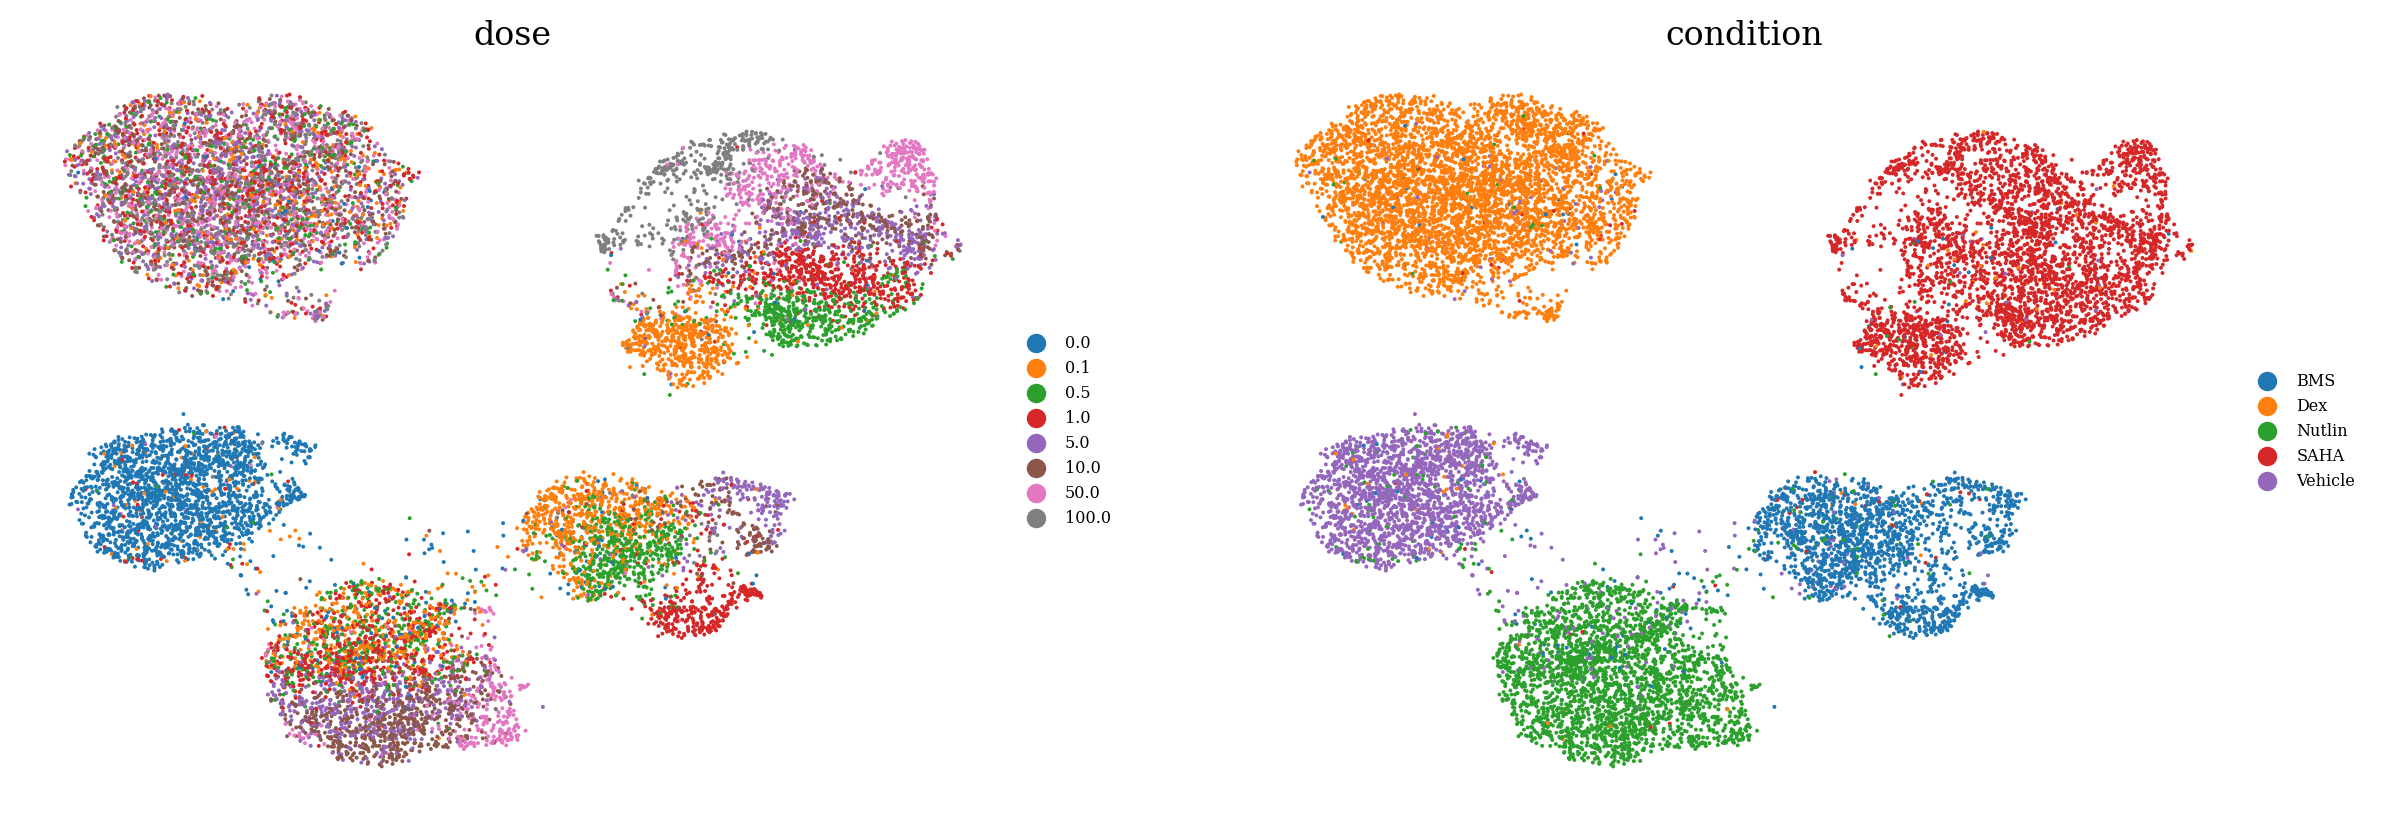

In [23]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent, 
        color=["dose", "condition"], 
        ncols=2,
        frameon=False,
        color_map="inferno",
        legend_fontsize="xx-small"
    )

In [24]:
from tardis._disentanglementmanager import DisentanglementManager as DM

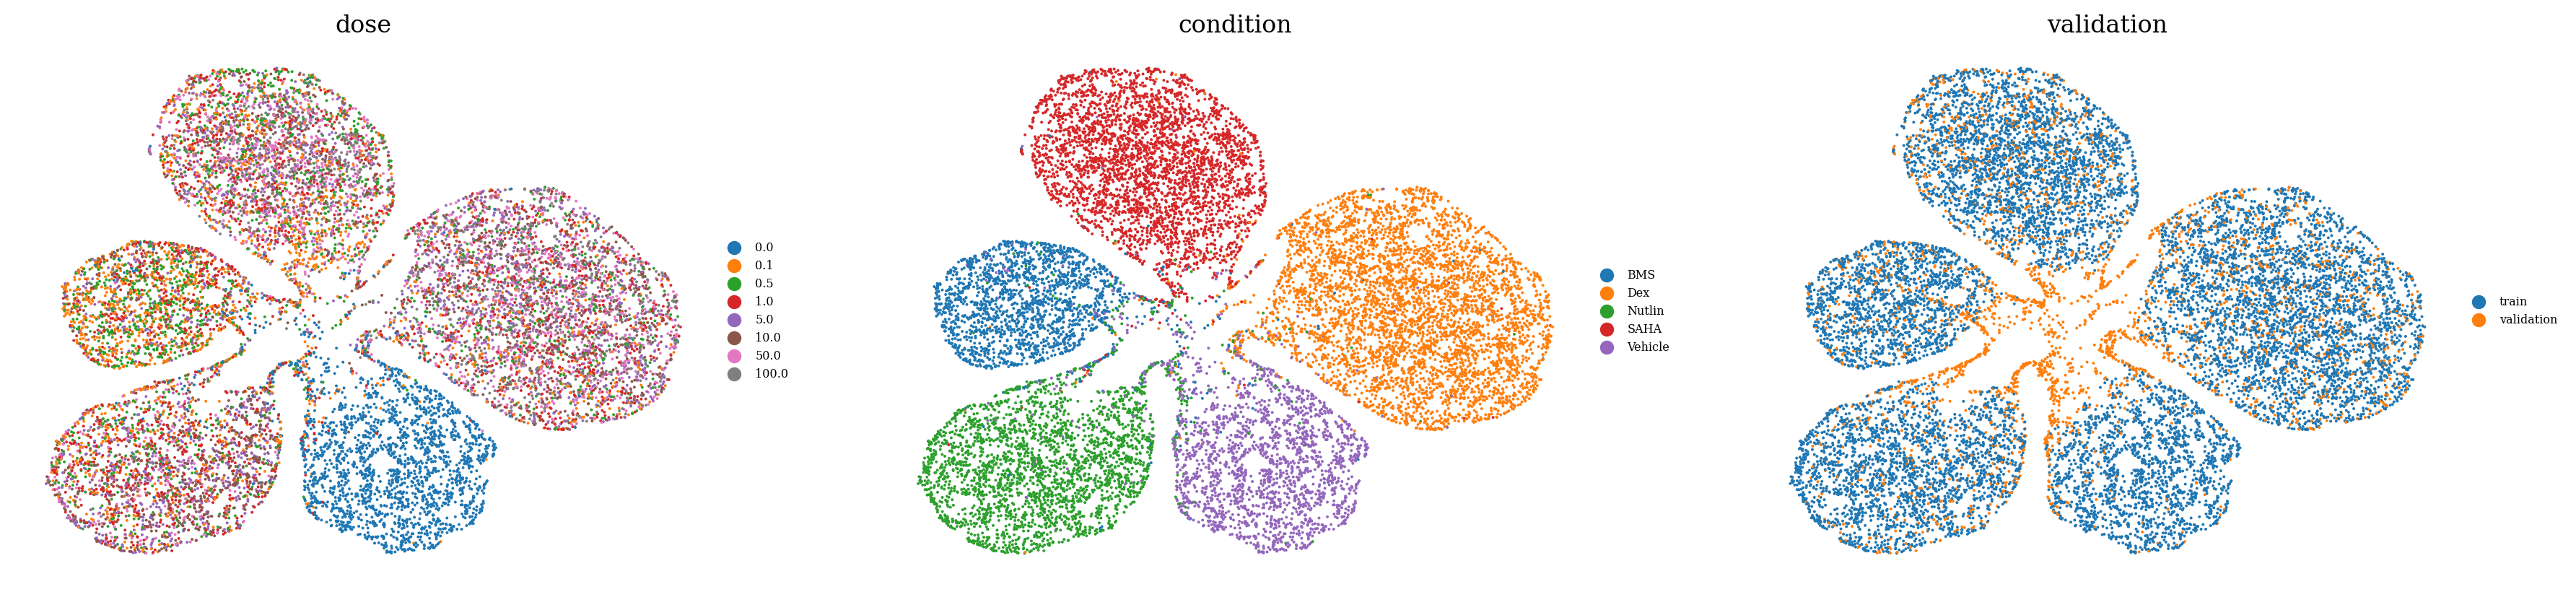

In [25]:
latent = ad.AnnData(X=vae.get_latent_representation()[:, DM.configurations.get_by_obs_key(obs_key).reserved_latent_indices], obs=adata.obs.copy())
sc.pp.neighbors(latent)
sc.tl.umap(latent)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent, 
        color=["dose", "condition", "validation"], 
        ncols=3,
        frameon=False,
        color_map="inferno",
        legend_fontsize="xx-small"
    )

In [26]:
adata_main = ad.read_h5ad(adata_file_path)
adata_main.obs.loc[adata_main.obs["dose"] == "0.0", "dose_val"] = 0.0
d = {i: ind for ind, i in enumerate(sorted(adata_main.obs["dose"].astype(float).unique()))}
adata_main.obs["dose_training"] = [d[float(i)] for i in adata_main.obs["dose"]]

adata_main.obs["ood"] = choices_bool.astype(int).astype(str)
adata_main.obs["ood"] = adata_main.obs["ood"].astype("category")

adata_ood = adata_main[adata_main.obs["ood"] == "1"].copy()

In [27]:
# latent_main = ad.AnnData(X=vae.get_latent_representation(adata_main)[:, DM.configurations.get_by_obs_key("age").reserved_latent_indices], obs=adata_main.obs.copy())
latent_main = ad.AnnData(X=vae.get_latent_representation(adata_main), obs=adata_main.obs.copy())
sc.pp.neighbors(latent_main, n_neighbors = 30)
sc.tl.umap(latent_main)

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


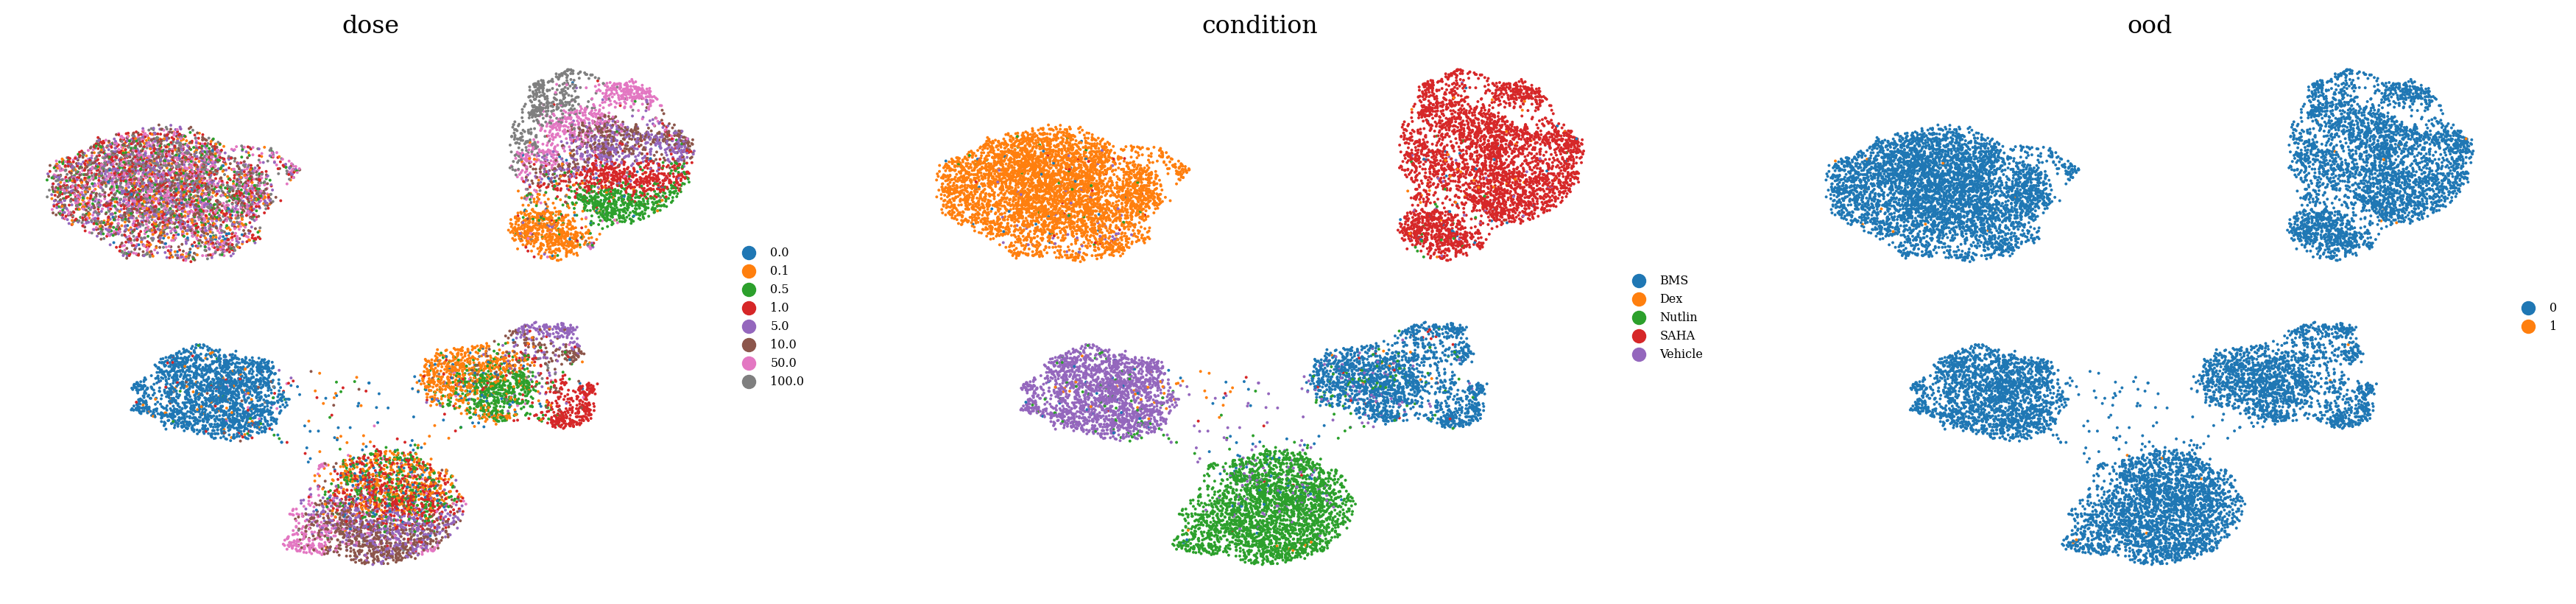

In [28]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent_main, 
        color=["dose", "condition", "ood"], 
        ncols=3,
        frameon=False,
        color_map="inferno",
        legend_fontsize="xx-small"
    )

In [29]:
k = obs_key

latent = ad.AnnData(X=vae.get_latent_representation(adata)[:, DM.configurations.get_by_obs_key(k).reserved_latent_indices], obs=adata.obs.copy())
sc.pp.neighbors(latent)
latent_ood = ad.AnnData(X=vae.get_latent_representation(adata_ood)[:, DM.configurations.get_by_obs_key(k).reserved_latent_indices], obs=adata_ood.obs.copy())
sc.pp.neighbors(latent_ood)
sc.tl.umap(latent_ood)
label_transfer(latent, latent_ood, cluster_list=[k], neighbors_count=30)
predicted = latent_ood.obs[f"transf_{k}"].astype(str).values
true = latent_ood.obs[k].astype(str).values

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


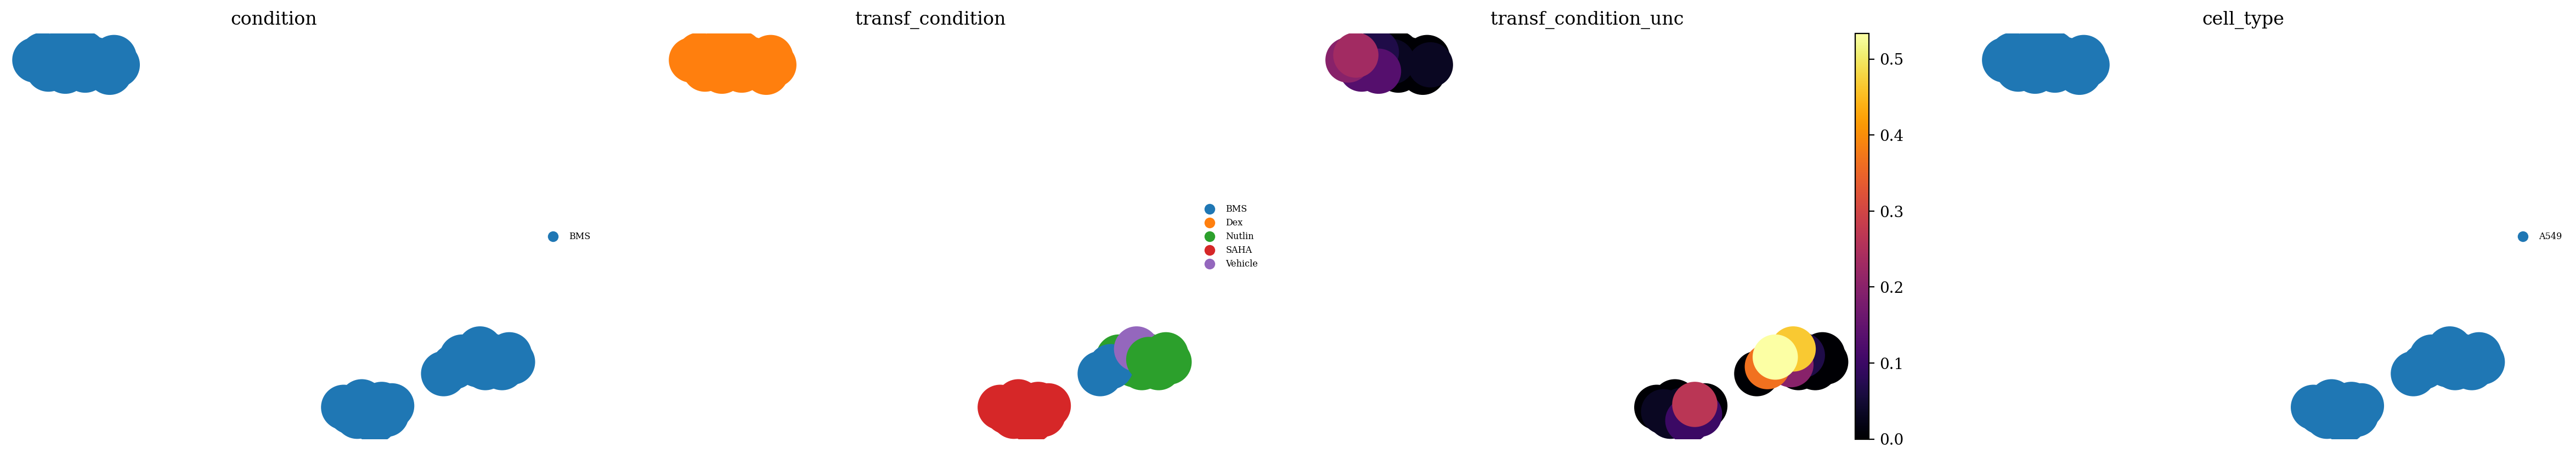

In [30]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent_ood, 
        color=[k, f"transf_{k}", f"transf_{k}_unc", "cell_type"], 
        ncols=4,
        frameon=False,
        color_map="inferno",
        legend_fontsize="xx-small"
    )

In [31]:
metrics = {}
metrics['accuracy'] = sklearn.metrics.accuracy_score(true, predicted)
metrics['precision_macro'] = sklearn.metrics.precision_score(true, predicted, average='macro', zero_division=0)
metrics['recall_macro'] = sklearn.metrics.recall_score(true, predicted, average='macro', zero_division=0)
metrics['f1_score_macro'] = sklearn.metrics.f1_score(true, predicted, average='macro', zero_division=0)
metrics['precision_micro'] = sklearn.metrics.precision_score(true, predicted, average='micro', zero_division=0)
metrics['recall_micro'] = sklearn.metrics.recall_score(true, predicted, average='micro', zero_division=0)
metrics['f1_score_micro'] = sklearn.metrics.f1_score(true, predicted, average='micro', zero_division=0)
metrics['precision_weighted'] = sklearn.metrics.precision_score(true, predicted, average='weighted', zero_division=0)
metrics['recall_weighted'] = sklearn.metrics.recall_score(true, predicted, average='weighted', zero_division=0)
metrics['f1_score_weighted'] = sklearn.metrics.f1_score(true, predicted, average='weighted', zero_division=0)
metrics['confusion_matrix'] = sklearn.metrics.confusion_matrix(true, predicted)
metrics

{'accuracy': 0.058823529411764705,
 'precision_macro': 0.2,
 'recall_macro': 0.011764705882352941,
 'f1_score_macro': 0.02222222222222222,
 'precision_micro': 0.058823529411764705,
 'recall_micro': 0.058823529411764705,
 'f1_score_micro': 0.058823529411764705,
 'precision_weighted': 1.0,
 'recall_weighted': 0.058823529411764705,
 'f1_score_weighted': 0.1111111111111111,
 'confusion_matrix': array([[ 2, 14,  8,  9,  1],
        [ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0]])}

In [32]:
t = latent_main.obs[k].astype(str).to_numpy().copy()
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(t.reshape(-1, 1), t)
dummy_predictions = dummy_clf.predict(t.reshape(-1, 1))
print("Baseline Accuracy:", sklearn.metrics.accuracy_score(t, dummy_predictions))

Baseline Accuracy: 0.3016676794274526


In [33]:
t = latent_main.obs[k].astype(str).to_numpy().copy()
dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(t.reshape(-1, 1), t)
dummy_predictions = dummy_clf.predict(t.reshape(-1, 1))
print("Baseline Accuracy:", sklearn.metrics.accuracy_score(t, dummy_predictions))

Baseline Accuracy: 0.2234150293700628
